In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
from datetime import datetime
import math

In [4]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.1.3


In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
import os
os.chdir('C:\\Users\\adars\\Desktop\\Purdue Syllabus IMP\\Fall Semester Mod 2\\Data Mining\\LSTM Project\\M3C')

In [5]:
pwd

'C:\\Users\\adars\\Desktop\\Purdue Syllabus IMP\\Fall Semester Mod 2\\Data Mining\\LSTM Project\\M3C'

In [6]:
example = pd.read_csv('example_1.csv', parse_dates=['time'], index_col='time', squeeze = True)

In [7]:
example.head()

time
1979-01-01    4419
1979-02-01    4336
1979-03-01    4214
1979-04-01    4294
1979-05-01    4650
Name: value, dtype: int64

In [6]:
def train_test_split(data, n_test):
    train, test = data[0:-n_test], data[-n_test:]
    return train, test

In [7]:
def log_transform(data):
    log_data = np.log(data)
    return log_data

In [8]:
from statsmodels.tsa.stattools import adfuller

def test_for_stationarity(y):
    # perform Augmented Dickey Fuller test
    #print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
#     for key, value in dftest[4].items():
#         dfoutput['Critical Value ({})'.format(key)] = value
#     print(dfoutput)
    return dfoutput[1]
# apply the function to the time series


C:\Users\adars\Anaconda2\envs\py36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
def inverse_difference(history, yhat):
    yhat = pd.Series(yhat)
    yhat = yhat.cumsum() + history[-1]
    #yhat = np.exp(yhat)
    return yhat.tolist()

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is pd.Series else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(raw_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    
    train = supervised_values
    
    return scaler, train

In [12]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_neurons):
    
    val_size = int(train.shape[0]*0.2)
    train, val = train[0:-val_size, :], train[-val_size: , :]
    # reshape training into [samples, timesteps, features]
    trainX, trainy = train[:, 0:n_lag], train[:, n_lag:]
    trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], 1)
    
    # reshape validation data into [samples, timesteps, features]
    valX, valy = val[:, 0:n_lag], val[:, n_lag:]
    valX = valX.reshape(valX.shape[0], valX.shape[1], 1)
    
    n_batch_train = train.shape[0]
    
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(trainX.shape[1], 1), dropout=0.2, activation = 'relu'))
    #model.add(LSTM(64, stateful = True, dropout=0.2, activation = 'relu'))
    model.add(Dense(trainy.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    model.fit(trainX, trainy, epochs=250, batch_size=n_batch_train, validation_data = (valX, valy), verbose=2, shuffle=False)
        
#     new_model = Sequential()
#     new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch_pred, trainX.shape[1], 1), stateful=True, dropout=0.2))
#     new_model.add(Dense(trainy.shape[1]))
#     # copy weights
#     old_weights = model.get_weights()
#     new_model.set_weights(old_weights)
#     # compile model
#     new_model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
    return model

In [13]:
def forecast_lstm(model, X):
    X = X.reshape(1, len(X), 1)
    forecast = model.predict(X)
    #model.reset_states()
    return [x for x in forecast[0, :]]

In [14]:
def make_forecasts(model, points, n_lag, n_seq):
    forecasts = list()
    X = points[-1][len(points[-1])- n_lag:]
    forecast = forecast_lstm(model, X)
    forecasts.append(forecast)
    return forecasts

In [15]:
def inverse_transform(forecasts, scaler):
    inverted = list()
    for i in range(len(forecasts)):
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        inverted.append(inv_scale)
    return inverted

In [16]:
n_lag = 6
n_seq = 18
neurons = 20

In [17]:
lstm_data = pd.read_csv('LSTM_M3_Monthly.csv', parse_dates=['time'], index_col='time')

In [18]:
def LstmDict(lstm_data):
    lstm_dict={}
    keys = list(lstm_data.batchID.unique())

    for i in keys:
    
        value=[]
        value=lstm_data[lstm_data.batchID == i]
        value = value.drop(['batchID'], axis =1).squeeze()
        lstm_dict[i]=value
    
    return lstm_dict

In [19]:
Lstm_errors = {}
keys = list(LstmDict(lstm_data).keys())

In [20]:
#train1, test = train_test_split(LstmDict(lstm_data)['N1413'], 18)


from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)


# stl = decompose(train1, period=12)
# seas = stl.seasonal
# tr = stl.trend
# res = stl.resid
# stl.plot()
# plt.show()

In [22]:
for batch in keys[1265:]:

    train1, test = train_test_split(LstmDict(lstm_data)[batch], 18)
    #train1 = train1.ewm(alpha = 0.5).mean()
    #train1 = log_transform(train1)
    #decomposition = seasonal_decompose(train1)
    stl = decompose(train1, period=12)
    tr = stl.trend
    seas = stl.seasonal #stl.seasonal #
    res = stl.resid
    res = res.ewm(alpha = 0.3).mean()
    obs = seas + tr + res
    #obs = obs.ewm(alpha = 0.5).mean()
    # if test_for_stationarity(obs) > 0.05:

    #     data_diff = obs.diff().dropna()
    #     scaler, train = prepare_data(obs, n_lag, n_seq)
    #     #n_batch_train = train.shape[0]
    #     model = fit_lstm(train, n_lag, n_seq, neurons)
    #     forecasts = make_forecasts(model, train, n_lag, n_seq)
    #     forecasts = inverse_transform(forecasts, scaler)
    #     forecast = forecasts[0].tolist()
    #     forecast = inverse_difference(obs, forecast)
        #forecast = np.exp(forecast)

    # else:
    scaler, train = prepare_data(obs, n_lag, n_seq)
    #n_batch_train = train.shape[0]
    model= fit_lstm(train, n_lag, n_seq, neurons)
    forecasts = make_forecasts(model, train, n_lag, n_seq)
    forecasts = inverse_transform(forecasts, scaler)
    forecast = forecasts[0].tolist()
    #fcast_seasonal = seasonality(seasonal, 12, 18)
    #fcast = np.add(forecast, fcast_seasonal).tolist()
    
    print(batch)
    error_mape = []
    error_mape = evaluate_forecasts(test, forecast)
    Lstm_errors[batch] = error_mape

Train on 76 samples, validate on 18 samples
Epoch 1/250
 - 1s - loss: 0.1590 - val_loss: 0.3582
Epoch 2/250
 - 0s - loss: 0.1581 - val_loss: 0.3565
Epoch 3/250
 - 0s - loss: 0.1571 - val_loss: 0.3549
Epoch 4/250
 - 0s - loss: 0.1566 - val_loss: 0.3532
Epoch 5/250
 - 0s - loss: 0.1556 - val_loss: 0.3515
Epoch 6/250
 - 0s - loss: 0.1553 - val_loss: 0.3498
Epoch 7/250
 - 0s - loss: 0.1539 - val_loss: 0.3481
Epoch 8/250
 - 0s - loss: 0.1533 - val_loss: 0.3464
Epoch 9/250
 - 0s - loss: 0.1532 - val_loss: 0.3447
Epoch 10/250
 - 0s - loss: 0.1522 - val_loss: 0.3430
Epoch 11/250
 - 0s - loss: 0.1505 - val_loss: 0.3413
Epoch 12/250
 - 0s - loss: 0.1506 - val_loss: 0.3396
Epoch 13/250
 - 0s - loss: 0.1512 - val_loss: 0.3379
Epoch 14/250
 - 0s - loss: 0.1494 - val_loss: 0.3362
Epoch 15/250
 - 0s - loss: 0.1475 - val_loss: 0.3345
Epoch 16/250
 - 0s - loss: 0.1468 - val_loss: 0.3327
Epoch 17/250
 - 0s - loss: 0.1468 - val_loss: 0.3310
Epoch 18/250
 - 0s - loss: 0.1469 - val_loss: 0.3292
Epoch 19/25

Epoch 154/250
 - 0s - loss: 0.0468 - val_loss: 0.0278
Epoch 155/250
 - 0s - loss: 0.0469 - val_loss: 0.0275
Epoch 156/250
 - 0s - loss: 0.0434 - val_loss: 0.0273
Epoch 157/250
 - 0s - loss: 0.0311 - val_loss: 0.0273
Epoch 158/250
 - 0s - loss: 0.0362 - val_loss: 0.0275
Epoch 159/250
 - 0s - loss: 0.0370 - val_loss: 0.0279
Epoch 160/250
 - 0s - loss: 0.0392 - val_loss: 0.0283
Epoch 161/250
 - 0s - loss: 0.0535 - val_loss: 0.0286
Epoch 162/250
 - 0s - loss: 0.0367 - val_loss: 0.0288
Epoch 163/250
 - 0s - loss: 0.0499 - val_loss: 0.0288
Epoch 164/250
 - 0s - loss: 0.0347 - val_loss: 0.0285
Epoch 165/250
 - 0s - loss: 0.0525 - val_loss: 0.0279
Epoch 166/250
 - 0s - loss: 0.0360 - val_loss: 0.0275
Epoch 167/250
 - 0s - loss: 0.0299 - val_loss: 0.0272
Epoch 168/250
 - 0s - loss: 0.0312 - val_loss: 0.0271
Epoch 169/250
 - 0s - loss: 0.0416 - val_loss: 0.0270
Epoch 170/250
 - 0s - loss: 0.0432 - val_loss: 0.0269
Epoch 171/250
 - 0s - loss: 0.0395 - val_loss: 0.0265
Epoch 172/250
 - 0s - loss: 

Epoch 56/250
 - 0s - loss: 0.2228 - val_loss: 0.3536
Epoch 57/250
 - 0s - loss: 0.2055 - val_loss: 0.3603
Epoch 58/250
 - 0s - loss: 0.2041 - val_loss: 0.3675
Epoch 59/250
 - 0s - loss: 0.1974 - val_loss: 0.3751
Epoch 60/250
 - 0s - loss: 0.1964 - val_loss: 0.3833
Epoch 61/250
 - 0s - loss: 0.1828 - val_loss: 0.3920
Epoch 62/250
 - 0s - loss: 0.1847 - val_loss: 0.4013
Epoch 63/250
 - 0s - loss: 0.1709 - val_loss: 0.4111
Epoch 64/250
 - 0s - loss: 0.1679 - val_loss: 0.4216
Epoch 65/250
 - 0s - loss: 0.1550 - val_loss: 0.4327
Epoch 66/250
 - 0s - loss: 0.1549 - val_loss: 0.4444
Epoch 67/250
 - 0s - loss: 0.1443 - val_loss: 0.4567
Epoch 68/250
 - 0s - loss: 0.1507 - val_loss: 0.4695
Epoch 69/250
 - 0s - loss: 0.1339 - val_loss: 0.4824
Epoch 70/250
 - 0s - loss: 0.1318 - val_loss: 0.4954
Epoch 71/250
 - 0s - loss: 0.1303 - val_loss: 0.5081
Epoch 72/250
 - 0s - loss: 0.1420 - val_loss: 0.5206
Epoch 73/250
 - 0s - loss: 0.1292 - val_loss: 0.5325
Epoch 74/250
 - 0s - loss: 0.1281 - val_loss: 

Epoch 209/250
 - 0s - loss: 0.0420 - val_loss: 0.8155
Epoch 210/250
 - 0s - loss: 0.0420 - val_loss: 0.8148
Epoch 211/250
 - 0s - loss: 0.0410 - val_loss: 0.8147
Epoch 212/250
 - 0s - loss: 0.0409 - val_loss: 0.8146
Epoch 213/250
 - 0s - loss: 0.0422 - val_loss: 0.8152
Epoch 214/250
 - 0s - loss: 0.0420 - val_loss: 0.8157
Epoch 215/250
 - 0s - loss: 0.0433 - val_loss: 0.8164
Epoch 216/250
 - 0s - loss: 0.0435 - val_loss: 0.8181
Epoch 217/250
 - 0s - loss: 0.0415 - val_loss: 0.8199
Epoch 218/250
 - 0s - loss: 0.0437 - val_loss: 0.8222
Epoch 219/250
 - 0s - loss: 0.0402 - val_loss: 0.8241
Epoch 220/250
 - 0s - loss: 0.0416 - val_loss: 0.8250
Epoch 221/250
 - 0s - loss: 0.0425 - val_loss: 0.8250
Epoch 222/250
 - 0s - loss: 0.0417 - val_loss: 0.8245
Epoch 223/250
 - 0s - loss: 0.0448 - val_loss: 0.8229
Epoch 224/250
 - 0s - loss: 0.0415 - val_loss: 0.8217
Epoch 225/250
 - 0s - loss: 0.0430 - val_loss: 0.8209
Epoch 226/250
 - 0s - loss: 0.0415 - val_loss: 0.8198
Epoch 227/250
 - 0s - loss: 

Epoch 112/250
 - 0s - loss: 0.0407 - val_loss: 0.0594
Epoch 113/250
 - 0s - loss: 0.0526 - val_loss: 0.0576
Epoch 114/250
 - 0s - loss: 0.0455 - val_loss: 0.0558
Epoch 115/250
 - 0s - loss: 0.0526 - val_loss: 0.0542
Epoch 116/250
 - 0s - loss: 0.0555 - val_loss: 0.0527
Epoch 117/250
 - 0s - loss: 0.0476 - val_loss: 0.0512
Epoch 118/250
 - 0s - loss: 0.0479 - val_loss: 0.0499
Epoch 119/250
 - 0s - loss: 0.0603 - val_loss: 0.0488
Epoch 120/250
 - 0s - loss: 0.0641 - val_loss: 0.0477
Epoch 121/250
 - 0s - loss: 0.0553 - val_loss: 0.0466
Epoch 122/250
 - 0s - loss: 0.0518 - val_loss: 0.0455
Epoch 123/250
 - 0s - loss: 0.0512 - val_loss: 0.0443
Epoch 124/250
 - 0s - loss: 0.0432 - val_loss: 0.0431
Epoch 125/250
 - 0s - loss: 0.0474 - val_loss: 0.0418
Epoch 126/250
 - 0s - loss: 0.0482 - val_loss: 0.0406
Epoch 127/250
 - 0s - loss: 0.0401 - val_loss: 0.0395
Epoch 128/250
 - 0s - loss: 0.0395 - val_loss: 0.0383
Epoch 129/250
 - 0s - loss: 0.0431 - val_loss: 0.0373
Epoch 130/250
 - 0s - loss: 

Epoch 13/250
 - 0s - loss: 0.2208 - val_loss: 0.5290
Epoch 14/250
 - 0s - loss: 0.2204 - val_loss: 0.5254
Epoch 15/250
 - 0s - loss: 0.2186 - val_loss: 0.5219
Epoch 16/250
 - 0s - loss: 0.2181 - val_loss: 0.5182
Epoch 17/250
 - 0s - loss: 0.2164 - val_loss: 0.5145
Epoch 18/250
 - 0s - loss: 0.2150 - val_loss: 0.5108
Epoch 19/250
 - 0s - loss: 0.2141 - val_loss: 0.5070
Epoch 20/250
 - 0s - loss: 0.2124 - val_loss: 0.5032
Epoch 21/250
 - 0s - loss: 0.2101 - val_loss: 0.4993
Epoch 22/250
 - 0s - loss: 0.2100 - val_loss: 0.4953
Epoch 23/250
 - 0s - loss: 0.2072 - val_loss: 0.4913
Epoch 24/250
 - 0s - loss: 0.2078 - val_loss: 0.4872
Epoch 25/250
 - 0s - loss: 0.2074 - val_loss: 0.4831
Epoch 26/250
 - 0s - loss: 0.2059 - val_loss: 0.4789
Epoch 27/250
 - 0s - loss: 0.2035 - val_loss: 0.4747
Epoch 28/250
 - 0s - loss: 0.2016 - val_loss: 0.4703
Epoch 29/250
 - 0s - loss: 0.2001 - val_loss: 0.4659
Epoch 30/250
 - 0s - loss: 0.1992 - val_loss: 0.4614
Epoch 31/250
 - 0s - loss: 0.1942 - val_loss: 

Epoch 167/250
 - 0s - loss: 0.0369 - val_loss: 0.0387
Epoch 168/250
 - 0s - loss: 0.0386 - val_loss: 0.0387
Epoch 169/250
 - 0s - loss: 0.0371 - val_loss: 0.0386
Epoch 170/250
 - 0s - loss: 0.0429 - val_loss: 0.0386
Epoch 171/250
 - 0s - loss: 0.0445 - val_loss: 0.0388
Epoch 172/250
 - 0s - loss: 0.0366 - val_loss: 0.0384
Epoch 173/250
 - 0s - loss: 0.0388 - val_loss: 0.0379
Epoch 174/250
 - 0s - loss: 0.0351 - val_loss: 0.0374
Epoch 175/250
 - 0s - loss: 0.0398 - val_loss: 0.0373
Epoch 176/250
 - 0s - loss: 0.0386 - val_loss: 0.0369
Epoch 177/250
 - 0s - loss: 0.0336 - val_loss: 0.0364
Epoch 178/250
 - 0s - loss: 0.0341 - val_loss: 0.0362
Epoch 179/250
 - 0s - loss: 0.0435 - val_loss: 0.0361
Epoch 180/250
 - 0s - loss: 0.0349 - val_loss: 0.0357
Epoch 181/250
 - 0s - loss: 0.0356 - val_loss: 0.0351
Epoch 182/250
 - 0s - loss: 0.0454 - val_loss: 0.0346
Epoch 183/250
 - 0s - loss: 0.0394 - val_loss: 0.0345
Epoch 184/250
 - 0s - loss: 0.0382 - val_loss: 0.0345
Epoch 185/250
 - 0s - loss: 

Epoch 69/250
 - 0s - loss: 0.1633 - val_loss: 0.1911
Epoch 70/250
 - 0s - loss: 0.1519 - val_loss: 0.1979
Epoch 71/250
 - 0s - loss: 0.1450 - val_loss: 0.2053
Epoch 72/250
 - 0s - loss: 0.1517 - val_loss: 0.2133
Epoch 73/250
 - 0s - loss: 0.1479 - val_loss: 0.2217
Epoch 74/250
 - 0s - loss: 0.1299 - val_loss: 0.2298
Epoch 75/250
 - 0s - loss: 0.1408 - val_loss: 0.2374
Epoch 76/250
 - 0s - loss: 0.1351 - val_loss: 0.2439
Epoch 77/250
 - 0s - loss: 0.1308 - val_loss: 0.2493
Epoch 78/250
 - 0s - loss: 0.1239 - val_loss: 0.2525
Epoch 79/250
 - 0s - loss: 0.1293 - val_loss: 0.2541
Epoch 80/250
 - 0s - loss: 0.1251 - val_loss: 0.2537
Epoch 81/250
 - 0s - loss: 0.1097 - val_loss: 0.2506
Epoch 82/250
 - 0s - loss: 0.1111 - val_loss: 0.2469
Epoch 83/250
 - 0s - loss: 0.1068 - val_loss: 0.2419
Epoch 84/250
 - 0s - loss: 0.1041 - val_loss: 0.2362
Epoch 85/250
 - 0s - loss: 0.0994 - val_loss: 0.2303
Epoch 86/250
 - 0s - loss: 0.1000 - val_loss: 0.2248
Epoch 87/250
 - 0s - loss: 0.0973 - val_loss: 

Epoch 222/250
 - 0s - loss: 0.0461 - val_loss: 0.1938
Epoch 223/250
 - 0s - loss: 0.0403 - val_loss: 0.1945
Epoch 224/250
 - 0s - loss: 0.0447 - val_loss: 0.1939
Epoch 225/250
 - 0s - loss: 0.0481 - val_loss: 0.1922
Epoch 226/250
 - 0s - loss: 0.0403 - val_loss: 0.1897
Epoch 227/250
 - 0s - loss: 0.0431 - val_loss: 0.1869
Epoch 228/250
 - 0s - loss: 0.0478 - val_loss: 0.1854
Epoch 229/250
 - 0s - loss: 0.0431 - val_loss: 0.1837
Epoch 230/250
 - 0s - loss: 0.0402 - val_loss: 0.1817
Epoch 231/250
 - 0s - loss: 0.0427 - val_loss: 0.1797
Epoch 232/250
 - 0s - loss: 0.0456 - val_loss: 0.1798
Epoch 233/250
 - 0s - loss: 0.0436 - val_loss: 0.1800
Epoch 234/250
 - 0s - loss: 0.0431 - val_loss: 0.1823
Epoch 235/250
 - 0s - loss: 0.0421 - val_loss: 0.1838
Epoch 236/250
 - 0s - loss: 0.0405 - val_loss: 0.1844
Epoch 237/250
 - 0s - loss: 0.0412 - val_loss: 0.1851
Epoch 238/250
 - 0s - loss: 0.0426 - val_loss: 0.1850
Epoch 239/250
 - 0s - loss: 0.0421 - val_loss: 0.1862
Epoch 240/250
 - 0s - loss: 

Epoch 125/250
 - 0s - loss: 0.0816 - val_loss: 0.0367
Epoch 126/250
 - 0s - loss: 0.0859 - val_loss: 0.0364
Epoch 127/250
 - 0s - loss: 0.0712 - val_loss: 0.0364
Epoch 128/250
 - 0s - loss: 0.0897 - val_loss: 0.0362
Epoch 129/250
 - 0s - loss: 0.0812 - val_loss: 0.0359
Epoch 130/250
 - 0s - loss: 0.0794 - val_loss: 0.0358
Epoch 131/250
 - 0s - loss: 0.0768 - val_loss: 0.0356
Epoch 132/250
 - 0s - loss: 0.0758 - val_loss: 0.0355
Epoch 133/250
 - 0s - loss: 0.0691 - val_loss: 0.0356
Epoch 134/250
 - 0s - loss: 0.0758 - val_loss: 0.0357
Epoch 135/250
 - 0s - loss: 0.0814 - val_loss: 0.0357
Epoch 136/250
 - 0s - loss: 0.0691 - val_loss: 0.0359
Epoch 137/250
 - 0s - loss: 0.0822 - val_loss: 0.0360
Epoch 138/250
 - 0s - loss: 0.0737 - val_loss: 0.0361
Epoch 139/250
 - 0s - loss: 0.0877 - val_loss: 0.0360
Epoch 140/250
 - 0s - loss: 0.0845 - val_loss: 0.0357
Epoch 141/250
 - 0s - loss: 0.0738 - val_loss: 0.0354
Epoch 142/250
 - 0s - loss: 0.0909 - val_loss: 0.0350
Epoch 143/250
 - 0s - loss: 

Epoch 26/250
 - 0s - loss: 0.3953 - val_loss: 0.2363
Epoch 27/250
 - 0s - loss: 0.3932 - val_loss: 0.2352
Epoch 28/250
 - 0s - loss: 0.3911 - val_loss: 0.2340
Epoch 29/250
 - 0s - loss: 0.3895 - val_loss: 0.2328
Epoch 30/250
 - 0s - loss: 0.3877 - val_loss: 0.2315
Epoch 31/250
 - 0s - loss: 0.3856 - val_loss: 0.2303
Epoch 32/250
 - 0s - loss: 0.3834 - val_loss: 0.2290
Epoch 33/250
 - 0s - loss: 0.3812 - val_loss: 0.2277
Epoch 34/250
 - 0s - loss: 0.3790 - val_loss: 0.2263
Epoch 35/250
 - 0s - loss: 0.3768 - val_loss: 0.2250
Epoch 36/250
 - 0s - loss: 0.3751 - val_loss: 0.2236
Epoch 37/250
 - 0s - loss: 0.3721 - val_loss: 0.2222
Epoch 38/250
 - 0s - loss: 0.3703 - val_loss: 0.2208
Epoch 39/250
 - 0s - loss: 0.3671 - val_loss: 0.2194
Epoch 40/250
 - 0s - loss: 0.3643 - val_loss: 0.2179
Epoch 41/250
 - 0s - loss: 0.3629 - val_loss: 0.2164
Epoch 42/250
 - 0s - loss: 0.3595 - val_loss: 0.2150
Epoch 43/250
 - 0s - loss: 0.3579 - val_loss: 0.2134
Epoch 44/250
 - 0s - loss: 0.3548 - val_loss: 

 - 0s - loss: 0.0340 - val_loss: 0.2629
Epoch 180/250
 - 0s - loss: 0.0357 - val_loss: 0.2658
Epoch 181/250
 - 0s - loss: 0.0422 - val_loss: 0.2698
Epoch 182/250
 - 0s - loss: 0.0333 - val_loss: 0.2731
Epoch 183/250
 - 0s - loss: 0.0350 - val_loss: 0.2769
Epoch 184/250
 - 0s - loss: 0.0439 - val_loss: 0.2782
Epoch 185/250
 - 0s - loss: 0.0371 - val_loss: 0.2783
Epoch 186/250
 - 0s - loss: 0.0405 - val_loss: 0.2783
Epoch 187/250
 - 0s - loss: 0.0418 - val_loss: 0.2765
Epoch 188/250
 - 0s - loss: 0.0336 - val_loss: 0.2729
Epoch 189/250
 - 0s - loss: 0.0367 - val_loss: 0.2702
Epoch 190/250
 - 0s - loss: 0.0376 - val_loss: 0.2677
Epoch 191/250
 - 0s - loss: 0.0400 - val_loss: 0.2647
Epoch 192/250
 - 0s - loss: 0.0331 - val_loss: 0.2627
Epoch 193/250
 - 0s - loss: 0.0435 - val_loss: 0.2606
Epoch 194/250
 - 0s - loss: 0.0415 - val_loss: 0.2592
Epoch 195/250
 - 0s - loss: 0.0407 - val_loss: 0.2578
Epoch 196/250
 - 0s - loss: 0.0342 - val_loss: 0.2584
Epoch 197/250
 - 0s - loss: 0.0377 - val_l

Epoch 82/250
 - 0s - loss: 0.1117 - val_loss: 0.1811
Epoch 83/250
 - 0s - loss: 0.1043 - val_loss: 0.1917
Epoch 84/250
 - 0s - loss: 0.1050 - val_loss: 0.2060
Epoch 85/250
 - 0s - loss: 0.0856 - val_loss: 0.2242
Epoch 86/250
 - 0s - loss: 0.0846 - val_loss: 0.2464
Epoch 87/250
 - 0s - loss: 0.0796 - val_loss: 0.2721
Epoch 88/250
 - 0s - loss: 0.0784 - val_loss: 0.2999
Epoch 89/250
 - 0s - loss: 0.0803 - val_loss: 0.3285
Epoch 90/250
 - 0s - loss: 0.0793 - val_loss: 0.3519
Epoch 91/250
 - 0s - loss: 0.0859 - val_loss: 0.3689
Epoch 92/250
 - 0s - loss: 0.0774 - val_loss: 0.3768
Epoch 93/250
 - 0s - loss: 0.0773 - val_loss: 0.3768
Epoch 94/250
 - 0s - loss: 0.0730 - val_loss: 0.3697
Epoch 95/250
 - 0s - loss: 0.0700 - val_loss: 0.3580
Epoch 96/250
 - 0s - loss: 0.0673 - val_loss: 0.3421
Epoch 97/250
 - 0s - loss: 0.0643 - val_loss: 0.3237
Epoch 98/250
 - 0s - loss: 0.0636 - val_loss: 0.3049
Epoch 99/250
 - 0s - loss: 0.0592 - val_loss: 0.2865
Epoch 100/250
 - 0s - loss: 0.0588 - val_loss:

Epoch 235/250
 - 0s - loss: 0.0226 - val_loss: 0.2060
Epoch 236/250
 - 0s - loss: 0.0164 - val_loss: 0.2075
Epoch 237/250
 - 0s - loss: 0.0204 - val_loss: 0.2087
Epoch 238/250
 - 0s - loss: 0.0202 - val_loss: 0.2090
Epoch 239/250
 - 0s - loss: 0.0166 - val_loss: 0.2092
Epoch 240/250
 - 0s - loss: 0.0209 - val_loss: 0.2086
Epoch 241/250
 - 0s - loss: 0.0220 - val_loss: 0.2081
Epoch 242/250
 - 0s - loss: 0.0177 - val_loss: 0.2059
Epoch 243/250
 - 0s - loss: 0.0232 - val_loss: 0.2044
Epoch 244/250
 - 0s - loss: 0.0156 - val_loss: 0.2031
Epoch 245/250
 - 0s - loss: 0.0226 - val_loss: 0.2022
Epoch 246/250
 - 0s - loss: 0.0217 - val_loss: 0.2022
Epoch 247/250
 - 0s - loss: 0.0146 - val_loss: 0.2024
Epoch 248/250
 - 0s - loss: 0.0207 - val_loss: 0.2025
Epoch 249/250
 - 0s - loss: 0.0283 - val_loss: 0.2025
Epoch 250/250
 - 0s - loss: 0.0239 - val_loss: 0.2020
N2674
MAPE:  23.819488058370634
Train on 76 samples, validate on 18 samples
Epoch 1/250
 - 1s - loss: 0.4944 - val_loss: 0.2663
Epoch 2/

Epoch 138/250
 - 0s - loss: 0.0504 - val_loss: 0.6641
Epoch 139/250
 - 0s - loss: 0.0442 - val_loss: 0.6656
Epoch 140/250
 - 0s - loss: 0.0448 - val_loss: 0.6663
Epoch 141/250
 - 0s - loss: 0.0463 - val_loss: 0.6683
Epoch 142/250
 - 0s - loss: 0.0497 - val_loss: 0.6706
Epoch 143/250
 - 0s - loss: 0.0448 - val_loss: 0.6721
Epoch 144/250
 - 0s - loss: 0.0480 - val_loss: 0.6733
Epoch 145/250
 - 0s - loss: 0.0483 - val_loss: 0.6746
Epoch 146/250
 - 0s - loss: 0.0453 - val_loss: 0.6752
Epoch 147/250
 - 0s - loss: 0.0447 - val_loss: 0.6741
Epoch 148/250
 - 0s - loss: 0.0451 - val_loss: 0.6722
Epoch 149/250
 - 0s - loss: 0.0458 - val_loss: 0.6704
Epoch 150/250
 - 0s - loss: 0.0428 - val_loss: 0.6683
Epoch 151/250
 - 0s - loss: 0.0483 - val_loss: 0.6667
Epoch 152/250
 - 0s - loss: 0.0458 - val_loss: 0.6651
Epoch 153/250
 - 0s - loss: 0.0457 - val_loss: 0.6634
Epoch 154/250
 - 0s - loss: 0.0480 - val_loss: 0.6615
Epoch 155/250
 - 0s - loss: 0.0458 - val_loss: 0.6600
Epoch 156/250
 - 0s - loss: 

Epoch 40/250
 - 0s - loss: 0.3306 - val_loss: 0.2052
Epoch 41/250
 - 0s - loss: 0.3298 - val_loss: 0.2028
Epoch 42/250
 - 0s - loss: 0.3265 - val_loss: 0.2004
Epoch 43/250
 - 0s - loss: 0.3239 - val_loss: 0.1980
Epoch 44/250
 - 0s - loss: 0.3236 - val_loss: 0.1956
Epoch 45/250
 - 0s - loss: 0.3140 - val_loss: 0.1931
Epoch 46/250
 - 0s - loss: 0.3124 - val_loss: 0.1907
Epoch 47/250
 - 0s - loss: 0.3117 - val_loss: 0.1883
Epoch 48/250
 - 0s - loss: 0.3077 - val_loss: 0.1858
Epoch 49/250
 - 0s - loss: 0.3026 - val_loss: 0.1834
Epoch 50/250
 - 0s - loss: 0.2955 - val_loss: 0.1810
Epoch 51/250
 - 0s - loss: 0.2972 - val_loss: 0.1786
Epoch 52/250
 - 0s - loss: 0.2975 - val_loss: 0.1762
Epoch 53/250
 - 0s - loss: 0.2851 - val_loss: 0.1738
Epoch 54/250
 - 0s - loss: 0.2837 - val_loss: 0.1715
Epoch 55/250
 - 0s - loss: 0.2863 - val_loss: 0.1692
Epoch 56/250
 - 0s - loss: 0.2719 - val_loss: 0.1670
Epoch 57/250
 - 0s - loss: 0.2692 - val_loss: 0.1648
Epoch 58/250
 - 0s - loss: 0.2650 - val_loss: 

Epoch 193/250
 - 0s - loss: 0.0219 - val_loss: 0.2841
Epoch 194/250
 - 0s - loss: 0.0421 - val_loss: 0.2844
Epoch 195/250
 - 0s - loss: 0.0206 - val_loss: 0.2866
Epoch 196/250
 - 0s - loss: 0.0148 - val_loss: 0.2899
Epoch 197/250
 - 0s - loss: 0.0203 - val_loss: 0.2941
Epoch 198/250
 - 0s - loss: 0.0349 - val_loss: 0.2979
Epoch 199/250
 - 0s - loss: 0.0472 - val_loss: 0.3012
Epoch 200/250
 - 0s - loss: 0.0168 - val_loss: 0.3034
Epoch 201/250
 - 0s - loss: 0.0249 - val_loss: 0.3059
Epoch 202/250
 - 0s - loss: 0.0216 - val_loss: 0.3076
Epoch 203/250
 - 0s - loss: 0.0279 - val_loss: 0.3110
Epoch 204/250
 - 0s - loss: 0.0243 - val_loss: 0.3134
Epoch 205/250
 - 0s - loss: 0.0245 - val_loss: 0.3145
Epoch 206/250
 - 0s - loss: 0.0193 - val_loss: 0.3148
Epoch 207/250
 - 0s - loss: 0.0211 - val_loss: 0.3125
Epoch 208/250
 - 0s - loss: 0.0215 - val_loss: 0.3093
Epoch 209/250
 - 0s - loss: 0.0119 - val_loss: 0.3035
Epoch 210/250
 - 0s - loss: 0.0237 - val_loss: 0.2996
Epoch 211/250
 - 0s - loss: 

 - 0s - loss: 0.0951 - val_loss: 0.6775
Epoch 96/250
 - 0s - loss: 0.0898 - val_loss: 0.6725
Epoch 97/250
 - 0s - loss: 0.0872 - val_loss: 0.6690
Epoch 98/250
 - 0s - loss: 0.0869 - val_loss: 0.6660
Epoch 99/250
 - 0s - loss: 0.0844 - val_loss: 0.6639
Epoch 100/250
 - 0s - loss: 0.0818 - val_loss: 0.6631
Epoch 101/250
 - 0s - loss: 0.0826 - val_loss: 0.6641
Epoch 102/250
 - 0s - loss: 0.0790 - val_loss: 0.6661
Epoch 103/250
 - 0s - loss: 0.0774 - val_loss: 0.6697
Epoch 104/250
 - 0s - loss: 0.0764 - val_loss: 0.6745
Epoch 105/250
 - 0s - loss: 0.0777 - val_loss: 0.6806
Epoch 106/250
 - 0s - loss: 0.0757 - val_loss: 0.6875
Epoch 107/250
 - 0s - loss: 0.0728 - val_loss: 0.6948
Epoch 108/250
 - 0s - loss: 0.0725 - val_loss: 0.7026
Epoch 109/250
 - 0s - loss: 0.0720 - val_loss: 0.7106
Epoch 110/250
 - 0s - loss: 0.0663 - val_loss: 0.7184
Epoch 111/250
 - 0s - loss: 0.0688 - val_loss: 0.7258
Epoch 112/250
 - 0s - loss: 0.0698 - val_loss: 0.7322
Epoch 113/250
 - 0s - loss: 0.0665 - val_loss:

Epoch 248/250
 - 0s - loss: 0.0481 - val_loss: 0.7491
Epoch 249/250
 - 0s - loss: 0.0437 - val_loss: 0.7477
Epoch 250/250
 - 0s - loss: 0.0471 - val_loss: 0.7446
N2677
MAPE:  7.304840346606954
Train on 76 samples, validate on 18 samples
Epoch 1/250
 - 1s - loss: 0.3984 - val_loss: 0.2234
Epoch 2/250
 - 0s - loss: 0.3967 - val_loss: 0.2239
Epoch 3/250
 - 0s - loss: 0.3941 - val_loss: 0.2245
Epoch 4/250
 - 0s - loss: 0.3919 - val_loss: 0.2251
Epoch 5/250
 - 0s - loss: 0.3892 - val_loss: 0.2257
Epoch 6/250
 - 0s - loss: 0.3872 - val_loss: 0.2263
Epoch 7/250
 - 0s - loss: 0.3844 - val_loss: 0.2269
Epoch 8/250
 - 0s - loss: 0.3825 - val_loss: 0.2275
Epoch 9/250
 - 0s - loss: 0.3798 - val_loss: 0.2282
Epoch 10/250
 - 0s - loss: 0.3779 - val_loss: 0.2288
Epoch 11/250
 - 0s - loss: 0.3749 - val_loss: 0.2295
Epoch 12/250
 - 0s - loss: 0.3734 - val_loss: 0.2301
Epoch 13/250
 - 0s - loss: 0.3715 - val_loss: 0.2308
Epoch 14/250
 - 0s - loss: 0.3681 - val_loss: 0.2315
Epoch 15/250
 - 0s - loss: 0.3

Epoch 151/250
 - 0s - loss: 0.0446 - val_loss: 0.8147
Epoch 152/250
 - 0s - loss: 0.0451 - val_loss: 0.8151
Epoch 153/250
 - 0s - loss: 0.0426 - val_loss: 0.8162
Epoch 154/250
 - 0s - loss: 0.0427 - val_loss: 0.8172
Epoch 155/250
 - 0s - loss: 0.0402 - val_loss: 0.8185
Epoch 156/250
 - 0s - loss: 0.0427 - val_loss: 0.8200
Epoch 157/250
 - 0s - loss: 0.0407 - val_loss: 0.8209
Epoch 158/250
 - 0s - loss: 0.0439 - val_loss: 0.8209
Epoch 159/250
 - 0s - loss: 0.0404 - val_loss: 0.8203
Epoch 160/250
 - 0s - loss: 0.0424 - val_loss: 0.8194
Epoch 161/250
 - 0s - loss: 0.0376 - val_loss: 0.8192
Epoch 162/250
 - 0s - loss: 0.0421 - val_loss: 0.8189
Epoch 163/250
 - 0s - loss: 0.0447 - val_loss: 0.8184
Epoch 164/250
 - 0s - loss: 0.0389 - val_loss: 0.8192
Epoch 165/250
 - 0s - loss: 0.0413 - val_loss: 0.8200
Epoch 166/250
 - 0s - loss: 0.0392 - val_loss: 0.8210
Epoch 167/250
 - 0s - loss: 0.0402 - val_loss: 0.8234
Epoch 168/250
 - 0s - loss: 0.0403 - val_loss: 0.8262
Epoch 169/250
 - 0s - loss: 

Epoch 53/250
 - 0s - loss: 0.2765 - val_loss: 0.1789
Epoch 54/250
 - 0s - loss: 0.2705 - val_loss: 0.1813
Epoch 55/250
 - 0s - loss: 0.2614 - val_loss: 0.1840
Epoch 56/250
 - 0s - loss: 0.2609 - val_loss: 0.1868
Epoch 57/250
 - 0s - loss: 0.2552 - val_loss: 0.1900
Epoch 58/250
 - 0s - loss: 0.2514 - val_loss: 0.1934
Epoch 59/250
 - 0s - loss: 0.2501 - val_loss: 0.1972
Epoch 60/250
 - 0s - loss: 0.2366 - val_loss: 0.2014
Epoch 61/250
 - 0s - loss: 0.2315 - val_loss: 0.2059
Epoch 62/250
 - 0s - loss: 0.2268 - val_loss: 0.2109
Epoch 63/250
 - 0s - loss: 0.2176 - val_loss: 0.2164
Epoch 64/250
 - 0s - loss: 0.2174 - val_loss: 0.2223
Epoch 65/250
 - 0s - loss: 0.2180 - val_loss: 0.2288
Epoch 66/250
 - 0s - loss: 0.2097 - val_loss: 0.2359
Epoch 67/250
 - 0s - loss: 0.1996 - val_loss: 0.2436
Epoch 68/250
 - 0s - loss: 0.1923 - val_loss: 0.2520
Epoch 69/250
 - 0s - loss: 0.1939 - val_loss: 0.2610
Epoch 70/250
 - 0s - loss: 0.1842 - val_loss: 0.2707
Epoch 71/250
 - 0s - loss: 0.1779 - val_loss: 

Epoch 206/250
 - 0s - loss: 0.0504 - val_loss: 0.5238
Epoch 207/250
 - 0s - loss: 0.0478 - val_loss: 0.5266
Epoch 208/250
 - 0s - loss: 0.0509 - val_loss: 0.5294
Epoch 209/250
 - 0s - loss: 0.0484 - val_loss: 0.5306
Epoch 210/250
 - 0s - loss: 0.0522 - val_loss: 0.5323
Epoch 211/250
 - 0s - loss: 0.0424 - val_loss: 0.5323
Epoch 212/250
 - 0s - loss: 0.0439 - val_loss: 0.5310
Epoch 213/250
 - 0s - loss: 0.0463 - val_loss: 0.5283
Epoch 214/250
 - 0s - loss: 0.0484 - val_loss: 0.5256
Epoch 215/250
 - 0s - loss: 0.0443 - val_loss: 0.5247
Epoch 216/250
 - 0s - loss: 0.0511 - val_loss: 0.5237
Epoch 217/250
 - 0s - loss: 0.0450 - val_loss: 0.5224
Epoch 218/250
 - 0s - loss: 0.0502 - val_loss: 0.5219
Epoch 219/250
 - 0s - loss: 0.0496 - val_loss: 0.5222
Epoch 220/250
 - 0s - loss: 0.0452 - val_loss: 0.5220
Epoch 221/250
 - 0s - loss: 0.0479 - val_loss: 0.5220
Epoch 222/250
 - 0s - loss: 0.0439 - val_loss: 0.5208
Epoch 223/250
 - 0s - loss: 0.0455 - val_loss: 0.5199
Epoch 224/250
 - 0s - loss: 

Epoch 109/250
 - 0s - loss: 0.1046 - val_loss: 0.3472
Epoch 110/250
 - 0s - loss: 0.1028 - val_loss: 0.3502
Epoch 111/250
 - 0s - loss: 0.0953 - val_loss: 0.3497
Epoch 112/250
 - 0s - loss: 0.0895 - val_loss: 0.3461
Epoch 113/250
 - 0s - loss: 0.0844 - val_loss: 0.3413
Epoch 114/250
 - 0s - loss: 0.0781 - val_loss: 0.3356
Epoch 115/250
 - 0s - loss: 0.0850 - val_loss: 0.3289
Epoch 116/250
 - 0s - loss: 0.0758 - val_loss: 0.3222
Epoch 117/250
 - 0s - loss: 0.0808 - val_loss: 0.3168
Epoch 118/250
 - 0s - loss: 0.0749 - val_loss: 0.3122
Epoch 119/250
 - 0s - loss: 0.0694 - val_loss: 0.3081
Epoch 120/250
 - 0s - loss: 0.0663 - val_loss: 0.3044
Epoch 121/250
 - 0s - loss: 0.0642 - val_loss: 0.3021
Epoch 122/250
 - 0s - loss: 0.0706 - val_loss: 0.3015
Epoch 123/250
 - 0s - loss: 0.0633 - val_loss: 0.3026
Epoch 124/250
 - 0s - loss: 0.0609 - val_loss: 0.3051
Epoch 125/250
 - 0s - loss: 0.0595 - val_loss: 0.3090
Epoch 126/250
 - 0s - loss: 0.0608 - val_loss: 0.3147
Epoch 127/250
 - 0s - loss: 

Epoch 10/250
 - 0s - loss: 0.4451 - val_loss: 0.3979
Epoch 11/250
 - 0s - loss: 0.4413 - val_loss: 0.3986
Epoch 12/250
 - 0s - loss: 0.4403 - val_loss: 0.3993
Epoch 13/250
 - 0s - loss: 0.4363 - val_loss: 0.4001
Epoch 14/250
 - 0s - loss: 0.4339 - val_loss: 0.4009
Epoch 15/250
 - 0s - loss: 0.4300 - val_loss: 0.4017
Epoch 16/250
 - 0s - loss: 0.4288 - val_loss: 0.4025
Epoch 17/250
 - 0s - loss: 0.4248 - val_loss: 0.4034
Epoch 18/250
 - 0s - loss: 0.4231 - val_loss: 0.4043
Epoch 19/250
 - 0s - loss: 0.4191 - val_loss: 0.4052
Epoch 20/250
 - 0s - loss: 0.4162 - val_loss: 0.4062
Epoch 21/250
 - 0s - loss: 0.4137 - val_loss: 0.4072
Epoch 22/250
 - 0s - loss: 0.4115 - val_loss: 0.4082
Epoch 23/250
 - 0s - loss: 0.4082 - val_loss: 0.4093
Epoch 24/250
 - 0s - loss: 0.4053 - val_loss: 0.4104
Epoch 25/250
 - 0s - loss: 0.4028 - val_loss: 0.4116
Epoch 26/250
 - 0s - loss: 0.3982 - val_loss: 0.4128
Epoch 27/250
 - 0s - loss: 0.3978 - val_loss: 0.4141
Epoch 28/250
 - 0s - loss: 0.3957 - val_loss: 

Epoch 164/250
 - 0s - loss: 0.0365 - val_loss: 1.0796
Epoch 165/250
 - 0s - loss: 0.0378 - val_loss: 1.0796
Epoch 166/250
 - 0s - loss: 0.0368 - val_loss: 1.0794
Epoch 167/250
 - 0s - loss: 0.0357 - val_loss: 1.0793
Epoch 168/250
 - 0s - loss: 0.0369 - val_loss: 1.0800
Epoch 169/250
 - 0s - loss: 0.0373 - val_loss: 1.0803
Epoch 170/250
 - 0s - loss: 0.0358 - val_loss: 1.0812
Epoch 171/250
 - 0s - loss: 0.0368 - val_loss: 1.0823
Epoch 172/250
 - 0s - loss: 0.0403 - val_loss: 1.0824
Epoch 173/250
 - 0s - loss: 0.0355 - val_loss: 1.0821
Epoch 174/250
 - 0s - loss: 0.0369 - val_loss: 1.0823
Epoch 175/250
 - 0s - loss: 0.0360 - val_loss: 1.0822
Epoch 176/250
 - 0s - loss: 0.0371 - val_loss: 1.0823
Epoch 177/250
 - 0s - loss: 0.0353 - val_loss: 1.0818
Epoch 178/250
 - 0s - loss: 0.0384 - val_loss: 1.0813
Epoch 179/250
 - 0s - loss: 0.0365 - val_loss: 1.0813
Epoch 180/250
 - 0s - loss: 0.0364 - val_loss: 1.0812
Epoch 181/250
 - 0s - loss: 0.0362 - val_loss: 1.0818
Epoch 182/250
 - 0s - loss: 

Epoch 66/250
 - 0s - loss: 0.1649 - val_loss: 0.4094
Epoch 67/250
 - 0s - loss: 0.1627 - val_loss: 0.4164
Epoch 68/250
 - 0s - loss: 0.1600 - val_loss: 0.4236
Epoch 69/250
 - 0s - loss: 0.1536 - val_loss: 0.4310
Epoch 70/250
 - 0s - loss: 0.1523 - val_loss: 0.4387
Epoch 71/250
 - 0s - loss: 0.1529 - val_loss: 0.4466
Epoch 72/250
 - 0s - loss: 0.1497 - val_loss: 0.4547
Epoch 73/250
 - 0s - loss: 0.1458 - val_loss: 0.4631
Epoch 74/250
 - 0s - loss: 0.1458 - val_loss: 0.4715
Epoch 75/250
 - 0s - loss: 0.1402 - val_loss: 0.4800
Epoch 76/250
 - 0s - loss: 0.1409 - val_loss: 0.4883
Epoch 77/250
 - 0s - loss: 0.1396 - val_loss: 0.4964
Epoch 78/250
 - 0s - loss: 0.1362 - val_loss: 0.5043
Epoch 79/250
 - 0s - loss: 0.1360 - val_loss: 0.5119
Epoch 80/250
 - 0s - loss: 0.1348 - val_loss: 0.5190
Epoch 81/250
 - 0s - loss: 0.1327 - val_loss: 0.5257
Epoch 82/250
 - 0s - loss: 0.1310 - val_loss: 0.5317
Epoch 83/250
 - 0s - loss: 0.1298 - val_loss: 0.5367
Epoch 84/250
 - 0s - loss: 0.1269 - val_loss: 

Epoch 219/250
 - 0s - loss: 0.0603 - val_loss: 0.5963
Epoch 220/250
 - 0s - loss: 0.0578 - val_loss: 0.5961
Epoch 221/250
 - 0s - loss: 0.0614 - val_loss: 0.5972
Epoch 222/250
 - 0s - loss: 0.0629 - val_loss: 0.5983
Epoch 223/250
 - 0s - loss: 0.0616 - val_loss: 0.5998
Epoch 224/250
 - 0s - loss: 0.0605 - val_loss: 0.6008
Epoch 225/250
 - 0s - loss: 0.0594 - val_loss: 0.6009
Epoch 226/250
 - 0s - loss: 0.0620 - val_loss: 0.6009
Epoch 227/250
 - 0s - loss: 0.0611 - val_loss: 0.6011
Epoch 228/250
 - 0s - loss: 0.0620 - val_loss: 0.6003
Epoch 229/250
 - 0s - loss: 0.0580 - val_loss: 0.5996
Epoch 230/250
 - 0s - loss: 0.0615 - val_loss: 0.5972
Epoch 231/250
 - 0s - loss: 0.0579 - val_loss: 0.5957
Epoch 232/250
 - 0s - loss: 0.0600 - val_loss: 0.5944
Epoch 233/250
 - 0s - loss: 0.0596 - val_loss: 0.5922
Epoch 234/250
 - 0s - loss: 0.0617 - val_loss: 0.5920
Epoch 235/250
 - 0s - loss: 0.0612 - val_loss: 0.5917
Epoch 236/250
 - 0s - loss: 0.0597 - val_loss: 0.5930
Epoch 237/250
 - 0s - loss: 

Epoch 122/250
 - 0s - loss: 0.1280 - val_loss: 0.3430
Epoch 123/250
 - 0s - loss: 0.1273 - val_loss: 0.3437
Epoch 124/250
 - 0s - loss: 0.1302 - val_loss: 0.3444
Epoch 125/250
 - 0s - loss: 0.1255 - val_loss: 0.3451
Epoch 126/250
 - 0s - loss: 0.1270 - val_loss: 0.3458
Epoch 127/250
 - 0s - loss: 0.1198 - val_loss: 0.3465
Epoch 128/250
 - 0s - loss: 0.1270 - val_loss: 0.3472
Epoch 129/250
 - 0s - loss: 0.1266 - val_loss: 0.3477
Epoch 130/250
 - 0s - loss: 0.1214 - val_loss: 0.3483
Epoch 131/250
 - 0s - loss: 0.1221 - val_loss: 0.3487
Epoch 132/250
 - 0s - loss: 0.1290 - val_loss: 0.3491
Epoch 133/250
 - 0s - loss: 0.1227 - val_loss: 0.3496
Epoch 134/250
 - 0s - loss: 0.1198 - val_loss: 0.3499
Epoch 135/250
 - 0s - loss: 0.1192 - val_loss: 0.3503
Epoch 136/250
 - 0s - loss: 0.1246 - val_loss: 0.3505
Epoch 137/250
 - 0s - loss: 0.1233 - val_loss: 0.3505
Epoch 138/250
 - 0s - loss: 0.1269 - val_loss: 0.3502
Epoch 139/250
 - 0s - loss: 0.1202 - val_loss: 0.3498
Epoch 140/250
 - 0s - loss: 

Epoch 23/250
 - 0s - loss: 0.2199 - val_loss: 0.3475
Epoch 24/250
 - 0s - loss: 0.2185 - val_loss: 0.3497
Epoch 25/250
 - 0s - loss: 0.2204 - val_loss: 0.3519
Epoch 26/250
 - 0s - loss: 0.2161 - val_loss: 0.3543
Epoch 27/250
 - 0s - loss: 0.2122 - val_loss: 0.3566
Epoch 28/250
 - 0s - loss: 0.2122 - val_loss: 0.3591
Epoch 29/250
 - 0s - loss: 0.2097 - val_loss: 0.3616
Epoch 30/250
 - 0s - loss: 0.2061 - val_loss: 0.3643
Epoch 31/250
 - 0s - loss: 0.2071 - val_loss: 0.3670
Epoch 32/250
 - 0s - loss: 0.2035 - val_loss: 0.3698
Epoch 33/250
 - 0s - loss: 0.2021 - val_loss: 0.3727
Epoch 34/250
 - 0s - loss: 0.2007 - val_loss: 0.3756
Epoch 35/250
 - 0s - loss: 0.2015 - val_loss: 0.3788
Epoch 36/250
 - 0s - loss: 0.1952 - val_loss: 0.3820
Epoch 37/250
 - 0s - loss: 0.1909 - val_loss: 0.3853
Epoch 38/250
 - 0s - loss: 0.1934 - val_loss: 0.3889
Epoch 39/250
 - 0s - loss: 0.1888 - val_loss: 0.3925
Epoch 40/250
 - 0s - loss: 0.1863 - val_loss: 0.3963
Epoch 41/250
 - 0s - loss: 0.1826 - val_loss: 

 - 0s - loss: 0.0613 - val_loss: 1.1044
Epoch 177/250
 - 0s - loss: 0.0667 - val_loss: 1.0960
Epoch 178/250
 - 0s - loss: 0.0667 - val_loss: 1.0861
Epoch 179/250
 - 0s - loss: 0.0577 - val_loss: 1.0744
Epoch 180/250
 - 0s - loss: 0.0603 - val_loss: 1.0633
Epoch 181/250
 - 0s - loss: 0.0607 - val_loss: 1.0562
Epoch 182/250
 - 0s - loss: 0.0568 - val_loss: 1.0511
Epoch 183/250
 - 0s - loss: 0.0618 - val_loss: 1.0487
Epoch 184/250
 - 0s - loss: 0.0541 - val_loss: 1.0522
Epoch 185/250
 - 0s - loss: 0.0591 - val_loss: 1.0567
Epoch 186/250
 - 0s - loss: 0.0605 - val_loss: 1.0617
Epoch 187/250
 - 0s - loss: 0.0635 - val_loss: 1.0677
Epoch 188/250
 - 0s - loss: 0.0610 - val_loss: 1.0683
Epoch 189/250
 - 0s - loss: 0.0631 - val_loss: 1.0677
Epoch 190/250
 - 0s - loss: 0.0601 - val_loss: 1.0632
Epoch 191/250
 - 0s - loss: 0.0588 - val_loss: 1.0598
Epoch 192/250
 - 0s - loss: 0.0627 - val_loss: 1.0590
Epoch 193/250
 - 0s - loss: 0.0585 - val_loss: 1.0620
Epoch 194/250
 - 0s - loss: 0.0627 - val_l

Epoch 78/250
 - 0s - loss: 0.1803 - val_loss: 0.1518
Epoch 79/250
 - 0s - loss: 0.1724 - val_loss: 0.1634
Epoch 80/250
 - 0s - loss: 0.1703 - val_loss: 0.1763
Epoch 81/250
 - 0s - loss: 0.1653 - val_loss: 0.1904
Epoch 82/250
 - 0s - loss: 0.1565 - val_loss: 0.2055
Epoch 83/250
 - 0s - loss: 0.1569 - val_loss: 0.2208
Epoch 84/250
 - 0s - loss: 0.1455 - val_loss: 0.2356
Epoch 85/250
 - 0s - loss: 0.1461 - val_loss: 0.2491
Epoch 86/250
 - 0s - loss: 0.1397 - val_loss: 0.2603
Epoch 87/250
 - 0s - loss: 0.1371 - val_loss: 0.2691
Epoch 88/250
 - 0s - loss: 0.1359 - val_loss: 0.2747
Epoch 89/250
 - 0s - loss: 0.1312 - val_loss: 0.2772
Epoch 90/250
 - 0s - loss: 0.1286 - val_loss: 0.2773
Epoch 91/250
 - 0s - loss: 0.1210 - val_loss: 0.2751
Epoch 92/250
 - 0s - loss: 0.1120 - val_loss: 0.2719
Epoch 93/250
 - 0s - loss: 0.1137 - val_loss: 0.2673
Epoch 94/250
 - 0s - loss: 0.1040 - val_loss: 0.2624
Epoch 95/250
 - 0s - loss: 0.1048 - val_loss: 0.2574
Epoch 96/250
 - 0s - loss: 0.0983 - val_loss: 

 - 0s - loss: 0.0166 - val_loss: 0.3041
Epoch 231/250
 - 0s - loss: 0.0174 - val_loss: 0.3013
Epoch 232/250
 - 0s - loss: 0.0220 - val_loss: 0.2984
Epoch 233/250
 - 0s - loss: 0.0225 - val_loss: 0.2967
Epoch 234/250
 - 0s - loss: 0.0179 - val_loss: 0.2969
Epoch 235/250
 - 0s - loss: 0.0185 - val_loss: 0.2962
Epoch 236/250
 - 0s - loss: 0.0195 - val_loss: 0.2974
Epoch 237/250
 - 0s - loss: 0.0227 - val_loss: 0.2987
Epoch 238/250
 - 0s - loss: 0.0145 - val_loss: 0.3006
Epoch 239/250
 - 0s - loss: 0.0175 - val_loss: 0.3011
Epoch 240/250
 - 0s - loss: 0.0165 - val_loss: 0.3014
Epoch 241/250
 - 0s - loss: 0.0174 - val_loss: 0.3018
Epoch 242/250
 - 0s - loss: 0.0130 - val_loss: 0.3038
Epoch 243/250
 - 0s - loss: 0.0207 - val_loss: 0.3049
Epoch 244/250
 - 0s - loss: 0.0155 - val_loss: 0.3056
Epoch 245/250
 - 0s - loss: 0.0237 - val_loss: 0.3062
Epoch 246/250
 - 0s - loss: 0.0187 - val_loss: 0.3074
Epoch 247/250
 - 0s - loss: 0.0214 - val_loss: 0.3060
Epoch 248/250
 - 0s - loss: 0.0209 - val_l

Epoch 133/250
 - 0s - loss: 0.0443 - val_loss: 0.5404
Epoch 134/250
 - 0s - loss: 0.0460 - val_loss: 0.5422
Epoch 135/250
 - 0s - loss: 0.0467 - val_loss: 0.5435
Epoch 136/250
 - 0s - loss: 0.0453 - val_loss: 0.5442
Epoch 137/250
 - 0s - loss: 0.0459 - val_loss: 0.5442
Epoch 138/250
 - 0s - loss: 0.0465 - val_loss: 0.5446
Epoch 139/250
 - 0s - loss: 0.0458 - val_loss: 0.5443
Epoch 140/250
 - 0s - loss: 0.0459 - val_loss: 0.5437
Epoch 141/250
 - 0s - loss: 0.0457 - val_loss: 0.5434
Epoch 142/250
 - 0s - loss: 0.0460 - val_loss: 0.5434
Epoch 143/250
 - 0s - loss: 0.0451 - val_loss: 0.5434
Epoch 144/250
 - 0s - loss: 0.0470 - val_loss: 0.5433
Epoch 145/250
 - 0s - loss: 0.0447 - val_loss: 0.5441
Epoch 146/250
 - 0s - loss: 0.0462 - val_loss: 0.5447
Epoch 147/250
 - 0s - loss: 0.0475 - val_loss: 0.5454
Epoch 148/250
 - 0s - loss: 0.0421 - val_loss: 0.5465
Epoch 149/250
 - 0s - loss: 0.0459 - val_loss: 0.5473
Epoch 150/250
 - 0s - loss: 0.0481 - val_loss: 0.5474
Epoch 151/250
 - 0s - loss: 

 - 0s - loss: 0.2959 - val_loss: 0.1779
Epoch 35/250
 - 0s - loss: 0.2918 - val_loss: 0.1754
Epoch 36/250
 - 0s - loss: 0.2886 - val_loss: 0.1729
Epoch 37/250
 - 0s - loss: 0.2907 - val_loss: 0.1704
Epoch 38/250
 - 0s - loss: 0.2843 - val_loss: 0.1678
Epoch 39/250
 - 0s - loss: 0.2823 - val_loss: 0.1653
Epoch 40/250
 - 0s - loss: 0.2805 - val_loss: 0.1627
Epoch 41/250
 - 0s - loss: 0.2764 - val_loss: 0.1601
Epoch 42/250
 - 0s - loss: 0.2785 - val_loss: 0.1576
Epoch 43/250
 - 0s - loss: 0.2712 - val_loss: 0.1551
Epoch 44/250
 - 0s - loss: 0.2706 - val_loss: 0.1526
Epoch 45/250
 - 0s - loss: 0.2707 - val_loss: 0.1502
Epoch 46/250
 - 0s - loss: 0.2661 - val_loss: 0.1478
Epoch 47/250
 - 0s - loss: 0.2605 - val_loss: 0.1455
Epoch 48/250
 - 0s - loss: 0.2638 - val_loss: 0.1432
Epoch 49/250
 - 0s - loss: 0.2547 - val_loss: 0.1411
Epoch 50/250
 - 0s - loss: 0.2578 - val_loss: 0.1390
Epoch 51/250
 - 0s - loss: 0.2527 - val_loss: 0.1370
Epoch 52/250
 - 0s - loss: 0.2505 - val_loss: 0.1352
Epoch 

Epoch 188/250
 - 0s - loss: 0.1495 - val_loss: 0.2031
Epoch 189/250
 - 0s - loss: 0.1618 - val_loss: 0.2040
Epoch 190/250
 - 0s - loss: 0.1570 - val_loss: 0.2038
Epoch 191/250
 - 0s - loss: 0.1551 - val_loss: 0.2036
Epoch 192/250
 - 0s - loss: 0.1524 - val_loss: 0.2020
Epoch 193/250
 - 0s - loss: 0.1416 - val_loss: 0.1992
Epoch 194/250
 - 0s - loss: 0.1611 - val_loss: 0.1954
Epoch 195/250
 - 0s - loss: 0.1637 - val_loss: 0.1904
Epoch 196/250
 - 0s - loss: 0.1465 - val_loss: 0.1868
Epoch 197/250
 - 0s - loss: 0.1364 - val_loss: 0.1839
Epoch 198/250
 - 0s - loss: 0.1514 - val_loss: 0.1805
Epoch 199/250
 - 0s - loss: 0.1389 - val_loss: 0.1769
Epoch 200/250
 - 0s - loss: 0.1515 - val_loss: 0.1736
Epoch 201/250
 - 0s - loss: 0.1451 - val_loss: 0.1713
Epoch 202/250
 - 0s - loss: 0.1402 - val_loss: 0.1703
Epoch 203/250
 - 0s - loss: 0.1540 - val_loss: 0.1712
Epoch 204/250
 - 0s - loss: 0.1512 - val_loss: 0.1719
Epoch 205/250
 - 0s - loss: 0.1342 - val_loss: 0.1735
Epoch 206/250
 - 0s - loss: 

 - 0s - loss: 0.3090 - val_loss: 0.2605
Epoch 91/250
 - 0s - loss: 0.3056 - val_loss: 0.2684
Epoch 92/250
 - 0s - loss: 0.3028 - val_loss: 0.2806
Epoch 93/250
 - 0s - loss: 0.3026 - val_loss: 0.2987
Epoch 94/250
 - 0s - loss: 0.2996 - val_loss: 0.3242
Epoch 95/250
 - 0s - loss: 0.3046 - val_loss: 0.3555
Epoch 96/250
 - 0s - loss: 0.2954 - val_loss: 0.3972
Epoch 97/250
 - 0s - loss: 0.2935 - val_loss: 0.4516
Epoch 98/250
 - 0s - loss: 0.2975 - val_loss: 0.5199
Epoch 99/250
 - 0s - loss: 0.2987 - val_loss: 0.5980
Epoch 100/250
 - 0s - loss: 0.2910 - val_loss: 0.6958
Epoch 101/250
 - 0s - loss: 0.2895 - val_loss: 0.8175
Epoch 102/250
 - 0s - loss: 0.2892 - val_loss: 0.9686
Epoch 103/250
 - 0s - loss: 0.2883 - val_loss: 1.1541
Epoch 104/250
 - 0s - loss: 0.2776 - val_loss: 1.3986
Epoch 105/250
 - 0s - loss: 0.2795 - val_loss: 1.7085
Epoch 106/250
 - 0s - loss: 0.2786 - val_loss: 2.1031
Epoch 107/250
 - 0s - loss: 0.2763 - val_loss: 2.6066
Epoch 108/250
 - 0s - loss: 0.2827 - val_loss: 3.16

Epoch 237/250
 - 0s - loss: 0.1529 - val_loss: 517.1634
Epoch 238/250
 - 0s - loss: 0.1270 - val_loss: 498.5045
Epoch 239/250
 - 0s - loss: 0.1324 - val_loss: 477.5282
Epoch 240/250
 - 0s - loss: 0.1389 - val_loss: 453.3275
Epoch 241/250
 - 0s - loss: 0.1104 - val_loss: 434.5091
Epoch 242/250
 - 0s - loss: 0.1366 - val_loss: 412.3782
Epoch 243/250
 - 0s - loss: 0.1293 - val_loss: 396.5593
Epoch 244/250
 - 0s - loss: 0.1210 - val_loss: 377.3242
Epoch 245/250
 - 0s - loss: 0.1368 - val_loss: 355.2415
Epoch 246/250
 - 0s - loss: 0.1212 - val_loss: 335.1488
Epoch 247/250
 - 0s - loss: 0.1353 - val_loss: 311.5825
Epoch 248/250
 - 0s - loss: 0.1504 - val_loss: 287.0717
Epoch 249/250
 - 0s - loss: 0.1560 - val_loss: 261.4134
Epoch 250/250
 - 0s - loss: 0.1414 - val_loss: 242.0926
N2688
MAPE:  39.019057497036286
Train on 76 samples, validate on 18 samples
Epoch 1/250
 - 2s - loss: 0.2520 - val_loss: 0.8276
Epoch 2/250
 - 0s - loss: 0.2506 - val_loss: 0.8229
Epoch 3/250
 - 0s - loss: 0.2493 - v

Epoch 139/250
 - 0s - loss: 0.0644 - val_loss: 0.0644
Epoch 140/250
 - 0s - loss: 0.0460 - val_loss: 0.0694
Epoch 141/250
 - 0s - loss: 0.0518 - val_loss: 0.0727
Epoch 142/250
 - 0s - loss: 0.0341 - val_loss: 0.0746
Epoch 143/250
 - 0s - loss: 0.0460 - val_loss: 0.0737
Epoch 144/250
 - 0s - loss: 0.0675 - val_loss: 0.0726
Epoch 145/250
 - 0s - loss: 0.0475 - val_loss: 0.0693
Epoch 146/250
 - 0s - loss: 0.0549 - val_loss: 0.0656
Epoch 147/250
 - 0s - loss: 0.0464 - val_loss: 0.0631
Epoch 148/250
 - 0s - loss: 0.0607 - val_loss: 0.0613
Epoch 149/250
 - 0s - loss: 0.0498 - val_loss: 0.0593
Epoch 150/250
 - 0s - loss: 0.0638 - val_loss: 0.0553
Epoch 151/250
 - 0s - loss: 0.0458 - val_loss: 0.0523
Epoch 152/250
 - 0s - loss: 0.0337 - val_loss: 0.0491
Epoch 153/250
 - 0s - loss: 0.0319 - val_loss: 0.0454
Epoch 154/250
 - 0s - loss: 0.0408 - val_loss: 0.0428
Epoch 155/250
 - 0s - loss: 0.0398 - val_loss: 0.0404
Epoch 156/250
 - 0s - loss: 0.0507 - val_loss: 0.0392
Epoch 157/250
 - 0s - loss: 

Epoch 40/250
 - 0s - loss: 0.1489 - val_loss: 0.6638
Epoch 41/250
 - 0s - loss: 0.1477 - val_loss: 0.6583
Epoch 42/250
 - 0s - loss: 0.1462 - val_loss: 0.6526
Epoch 43/250
 - 0s - loss: 0.1434 - val_loss: 0.6468
Epoch 44/250
 - 0s - loss: 0.1445 - val_loss: 0.6408
Epoch 45/250
 - 0s - loss: 0.1431 - val_loss: 0.6347
Epoch 46/250
 - 0s - loss: 0.1429 - val_loss: 0.6285
Epoch 47/250
 - 0s - loss: 0.1399 - val_loss: 0.6221
Epoch 48/250
 - 0s - loss: 0.1415 - val_loss: 0.6155
Epoch 49/250
 - 0s - loss: 0.1395 - val_loss: 0.6087
Epoch 50/250
 - 0s - loss: 0.1366 - val_loss: 0.6017
Epoch 51/250
 - 0s - loss: 0.1366 - val_loss: 0.5946
Epoch 52/250
 - 0s - loss: 0.1374 - val_loss: 0.5872
Epoch 53/250
 - 0s - loss: 0.1343 - val_loss: 0.5797
Epoch 54/250
 - 0s - loss: 0.1316 - val_loss: 0.5718
Epoch 55/250
 - 0s - loss: 0.1292 - val_loss: 0.5637
Epoch 56/250
 - 0s - loss: 0.1327 - val_loss: 0.5554
Epoch 57/250
 - 0s - loss: 0.1286 - val_loss: 0.5469
Epoch 58/250
 - 0s - loss: 0.1264 - val_loss: 

Epoch 193/250
 - 0s - loss: 0.0271 - val_loss: 0.0801
Epoch 194/250
 - 0s - loss: 0.0232 - val_loss: 0.0801
Epoch 195/250
 - 0s - loss: 0.0200 - val_loss: 0.0802
Epoch 196/250
 - 0s - loss: 0.0245 - val_loss: 0.0819
Epoch 197/250
 - 0s - loss: 0.0244 - val_loss: 0.0825
Epoch 198/250
 - 0s - loss: 0.0329 - val_loss: 0.0838
Epoch 199/250
 - 0s - loss: 0.0269 - val_loss: 0.0853
Epoch 200/250
 - 0s - loss: 0.0206 - val_loss: 0.0860
Epoch 201/250
 - 0s - loss: 0.0319 - val_loss: 0.0866
Epoch 202/250
 - 0s - loss: 0.0181 - val_loss: 0.0865
Epoch 203/250
 - 0s - loss: 0.0202 - val_loss: 0.0868
Epoch 204/250
 - 0s - loss: 0.0280 - val_loss: 0.0868
Epoch 205/250
 - 0s - loss: 0.0199 - val_loss: 0.0857
Epoch 206/250
 - 0s - loss: 0.0218 - val_loss: 0.0841
Epoch 207/250
 - 0s - loss: 0.0330 - val_loss: 0.0828
Epoch 208/250
 - 0s - loss: 0.0266 - val_loss: 0.0828
Epoch 209/250
 - 0s - loss: 0.0377 - val_loss: 0.0852
Epoch 210/250
 - 0s - loss: 0.0343 - val_loss: 0.0872
Epoch 211/250
 - 0s - loss: 

 - 0s - loss: 0.1112 - val_loss: 0.0975
Epoch 96/250
 - 0s - loss: 0.0823 - val_loss: 0.0922
Epoch 97/250
 - 0s - loss: 0.0987 - val_loss: 0.0878
Epoch 98/250
 - 0s - loss: 0.1070 - val_loss: 0.0844
Epoch 99/250
 - 0s - loss: 0.0919 - val_loss: 0.0812
Epoch 100/250
 - 0s - loss: 0.0721 - val_loss: 0.0779
Epoch 101/250
 - 0s - loss: 0.0579 - val_loss: 0.0747
Epoch 102/250
 - 0s - loss: 0.0679 - val_loss: 0.0712
Epoch 103/250
 - 0s - loss: 0.0741 - val_loss: 0.0685
Epoch 104/250
 - 0s - loss: 0.0940 - val_loss: 0.0667
Epoch 105/250
 - 0s - loss: 0.0699 - val_loss: 0.0649
Epoch 106/250
 - 0s - loss: 0.0839 - val_loss: 0.0635
Epoch 107/250
 - 0s - loss: 0.0665 - val_loss: 0.0626
Epoch 108/250
 - 0s - loss: 0.0951 - val_loss: 0.0617
Epoch 109/250
 - 0s - loss: 0.0511 - val_loss: 0.0597
Epoch 110/250
 - 0s - loss: 0.0837 - val_loss: 0.0587
Epoch 111/250
 - 0s - loss: 0.0868 - val_loss: 0.0573
Epoch 112/250
 - 0s - loss: 0.0717 - val_loss: 0.0565
Epoch 113/250
 - 0s - loss: 0.0717 - val_loss:

 - 0s - loss: 0.0296 - val_loss: 0.0391
Epoch 248/250
 - 0s - loss: 0.0392 - val_loss: 0.0379
Epoch 249/250
 - 0s - loss: 0.0364 - val_loss: 0.0370
Epoch 250/250
 - 0s - loss: 0.0361 - val_loss: 0.0363
N2691
MAPE:  0.22447734079855264
Train on 76 samples, validate on 18 samples
Epoch 1/250
 - 2s - loss: 0.3695 - val_loss: 0.8303
Epoch 2/250
 - 0s - loss: 0.3673 - val_loss: 0.8267
Epoch 3/250
 - 0s - loss: 0.3661 - val_loss: 0.8231
Epoch 4/250
 - 0s - loss: 0.3643 - val_loss: 0.8195
Epoch 5/250
 - 0s - loss: 0.3634 - val_loss: 0.8159
Epoch 6/250
 - 0s - loss: 0.3617 - val_loss: 0.8123
Epoch 7/250
 - 0s - loss: 0.3595 - val_loss: 0.8087
Epoch 8/250
 - 0s - loss: 0.3584 - val_loss: 0.8051
Epoch 9/250
 - 0s - loss: 0.3563 - val_loss: 0.8015
Epoch 10/250
 - 0s - loss: 0.3548 - val_loss: 0.7978
Epoch 11/250
 - 0s - loss: 0.3530 - val_loss: 0.7941
Epoch 12/250
 - 0s - loss: 0.3529 - val_loss: 0.7904
Epoch 13/250
 - 0s - loss: 0.3521 - val_loss: 0.7866
Epoch 14/250
 - 0s - loss: 0.3496 - val_l

Epoch 150/250
 - 0s - loss: 0.0350 - val_loss: 0.0354
Epoch 151/250
 - 0s - loss: 0.0242 - val_loss: 0.0353
Epoch 152/250
 - 0s - loss: 0.0492 - val_loss: 0.0357
Epoch 153/250
 - 0s - loss: 0.0249 - val_loss: 0.0357
Epoch 154/250
 - 0s - loss: 0.0325 - val_loss: 0.0353
Epoch 155/250
 - 0s - loss: 0.0366 - val_loss: 0.0342
Epoch 156/250
 - 0s - loss: 0.0385 - val_loss: 0.0327
Epoch 157/250
 - 0s - loss: 0.0298 - val_loss: 0.0314
Epoch 158/250
 - 0s - loss: 0.0405 - val_loss: 0.0309
Epoch 159/250
 - 0s - loss: 0.0543 - val_loss: 0.0304
Epoch 160/250
 - 0s - loss: 0.0495 - val_loss: 0.0305
Epoch 161/250
 - 0s - loss: 0.0404 - val_loss: 0.0310
Epoch 162/250
 - 0s - loss: 0.0462 - val_loss: 0.0309
Epoch 163/250
 - 0s - loss: 0.0262 - val_loss: 0.0306
Epoch 164/250
 - 0s - loss: 0.0332 - val_loss: 0.0304
Epoch 165/250
 - 0s - loss: 0.0474 - val_loss: 0.0301
Epoch 166/250
 - 0s - loss: 0.0340 - val_loss: 0.0300
Epoch 167/250
 - 0s - loss: 0.0343 - val_loss: 0.0298
Epoch 168/250
 - 0s - loss: 

Epoch 52/250
 - 0s - loss: 0.3424 - val_loss: 0.5326
Epoch 53/250
 - 0s - loss: 0.3393 - val_loss: 0.5218
Epoch 54/250
 - 0s - loss: 0.3245 - val_loss: 0.5106
Epoch 55/250
 - 0s - loss: 0.3181 - val_loss: 0.4992
Epoch 56/250
 - 0s - loss: 0.3141 - val_loss: 0.4874
Epoch 57/250
 - 0s - loss: 0.3189 - val_loss: 0.4754
Epoch 58/250
 - 0s - loss: 0.3174 - val_loss: 0.4633
Epoch 59/250
 - 0s - loss: 0.2993 - val_loss: 0.4508
Epoch 60/250
 - 0s - loss: 0.3063 - val_loss: 0.4382
Epoch 61/250
 - 0s - loss: 0.3042 - val_loss: 0.4254
Epoch 62/250
 - 0s - loss: 0.2904 - val_loss: 0.4124
Epoch 63/250
 - 0s - loss: 0.2699 - val_loss: 0.3991
Epoch 64/250
 - 0s - loss: 0.2647 - val_loss: 0.3858
Epoch 65/250
 - 0s - loss: 0.2616 - val_loss: 0.3722
Epoch 66/250
 - 0s - loss: 0.2716 - val_loss: 0.3587
Epoch 67/250
 - 0s - loss: 0.2619 - val_loss: 0.3453
Epoch 68/250
 - 0s - loss: 0.2457 - val_loss: 0.3319
Epoch 69/250
 - 0s - loss: 0.2385 - val_loss: 0.3187
Epoch 70/250
 - 0s - loss: 0.2297 - val_loss: 

Epoch 205/250
 - 0s - loss: 0.0558 - val_loss: 0.0105
Epoch 206/250
 - 0s - loss: 0.0430 - val_loss: 0.0099
Epoch 207/250
 - 0s - loss: 0.0486 - val_loss: 0.0093
Epoch 208/250
 - 0s - loss: 0.0727 - val_loss: 0.0087
Epoch 209/250
 - 0s - loss: 0.0310 - val_loss: 0.0083
Epoch 210/250
 - 0s - loss: 0.0373 - val_loss: 0.0081
Epoch 211/250
 - 0s - loss: 0.0195 - val_loss: 0.0079
Epoch 212/250
 - 0s - loss: 0.0370 - val_loss: 0.0076
Epoch 213/250
 - 0s - loss: 0.0245 - val_loss: 0.0075
Epoch 214/250
 - 0s - loss: 0.0140 - val_loss: 0.0074
Epoch 215/250
 - 0s - loss: 0.0337 - val_loss: 0.0074
Epoch 216/250
 - 0s - loss: 0.0222 - val_loss: 0.0074
Epoch 217/250
 - 0s - loss: 0.0630 - val_loss: 0.0074
Epoch 218/250
 - 0s - loss: 0.0168 - val_loss: 0.0076
Epoch 219/250
 - 0s - loss: 0.0241 - val_loss: 0.0079
Epoch 220/250
 - 0s - loss: 0.0409 - val_loss: 0.0081
Epoch 221/250
 - 0s - loss: 0.0384 - val_loss: 0.0079
Epoch 222/250
 - 0s - loss: 0.0376 - val_loss: 0.0077
Epoch 223/250
 - 0s - loss: 

Epoch 108/250
 - 0s - loss: 0.0465 - val_loss: 0.0982
Epoch 109/250
 - 0s - loss: 0.0553 - val_loss: 0.0977
Epoch 110/250
 - 0s - loss: 0.0513 - val_loss: 0.0982
Epoch 111/250
 - 0s - loss: 0.0560 - val_loss: 0.0985
Epoch 112/250
 - 0s - loss: 0.0379 - val_loss: 0.0993
Epoch 113/250
 - 0s - loss: 0.0501 - val_loss: 0.0994
Epoch 114/250
 - 0s - loss: 0.0328 - val_loss: 0.0997
Epoch 115/250
 - 0s - loss: 0.0651 - val_loss: 0.0986
Epoch 116/250
 - 0s - loss: 0.0528 - val_loss: 0.0969
Epoch 117/250
 - 0s - loss: 0.0522 - val_loss: 0.0947
Epoch 118/250
 - 0s - loss: 0.0728 - val_loss: 0.0928
Epoch 119/250
 - 0s - loss: 0.0385 - val_loss: 0.0907
Epoch 120/250
 - 0s - loss: 0.0395 - val_loss: 0.0888
Epoch 121/250
 - 0s - loss: 0.0459 - val_loss: 0.0875
Epoch 122/250
 - 0s - loss: 0.0551 - val_loss: 0.0861
Epoch 123/250
 - 0s - loss: 0.0492 - val_loss: 0.0854
Epoch 124/250
 - 0s - loss: 0.0434 - val_loss: 0.0850
Epoch 125/250
 - 0s - loss: 0.0534 - val_loss: 0.0849
Epoch 126/250
 - 0s - loss: 

Epoch 9/250
 - 0s - loss: 0.2522 - val_loss: 0.5948
Epoch 10/250
 - 0s - loss: 0.2503 - val_loss: 0.5939
Epoch 11/250
 - 0s - loss: 0.2500 - val_loss: 0.5930
Epoch 12/250
 - 0s - loss: 0.2467 - val_loss: 0.5921
Epoch 13/250
 - 0s - loss: 0.2459 - val_loss: 0.5911
Epoch 14/250
 - 0s - loss: 0.2442 - val_loss: 0.5901
Epoch 15/250
 - 0s - loss: 0.2428 - val_loss: 0.5890
Epoch 16/250
 - 0s - loss: 0.2414 - val_loss: 0.5879
Epoch 17/250
 - 0s - loss: 0.2397 - val_loss: 0.5867
Epoch 18/250
 - 0s - loss: 0.2390 - val_loss: 0.5854
Epoch 19/250
 - 0s - loss: 0.2392 - val_loss: 0.5840
Epoch 20/250
 - 0s - loss: 0.2343 - val_loss: 0.5826
Epoch 21/250
 - 0s - loss: 0.2340 - val_loss: 0.5810
Epoch 22/250
 - 0s - loss: 0.2341 - val_loss: 0.5794
Epoch 23/250
 - 0s - loss: 0.2302 - val_loss: 0.5776
Epoch 24/250
 - 0s - loss: 0.2300 - val_loss: 0.5757
Epoch 25/250
 - 0s - loss: 0.2326 - val_loss: 0.5738
Epoch 26/250
 - 0s - loss: 0.2273 - val_loss: 0.5718
Epoch 27/250
 - 0s - loss: 0.2252 - val_loss: 0

Epoch 163/250
 - 0s - loss: 0.0501 - val_loss: 1.0580
Epoch 164/250
 - 0s - loss: 0.0579 - val_loss: 1.0872
Epoch 165/250
 - 0s - loss: 0.0959 - val_loss: 1.0940
Epoch 166/250
 - 0s - loss: 0.0361 - val_loss: 1.1050
Epoch 167/250
 - 0s - loss: 0.0473 - val_loss: 1.1136
Epoch 168/250
 - 0s - loss: 0.0478 - val_loss: 1.1362
Epoch 169/250
 - 0s - loss: 0.0349 - val_loss: 1.1762
Epoch 170/250
 - 0s - loss: 0.0380 - val_loss: 1.2332
Epoch 171/250
 - 0s - loss: 0.0699 - val_loss: 1.2292
Epoch 172/250
 - 0s - loss: 0.0383 - val_loss: 1.2221
Epoch 173/250
 - 0s - loss: 0.0729 - val_loss: 1.1726
Epoch 174/250
 - 0s - loss: 0.0370 - val_loss: 1.1268
Epoch 175/250
 - 0s - loss: 0.0518 - val_loss: 1.0969
Epoch 176/250
 - 0s - loss: 0.0435 - val_loss: 1.0689
Epoch 177/250
 - 0s - loss: 0.0447 - val_loss: 1.0542
Epoch 178/250
 - 0s - loss: 0.0434 - val_loss: 1.0529
Epoch 179/250
 - 0s - loss: 0.0360 - val_loss: 1.0393
Epoch 180/250
 - 0s - loss: 0.0399 - val_loss: 1.0301
Epoch 181/250
 - 0s - loss: 

Epoch 65/250
 - 0s - loss: 0.0782 - val_loss: 0.1232
Epoch 66/250
 - 0s - loss: 0.0810 - val_loss: 0.1236
Epoch 67/250
 - 0s - loss: 0.0720 - val_loss: 0.1239
Epoch 68/250
 - 0s - loss: 0.0808 - val_loss: 0.1242
Epoch 69/250
 - 0s - loss: 0.0694 - val_loss: 0.1244
Epoch 70/250
 - 0s - loss: 0.0786 - val_loss: 0.1247
Epoch 71/250
 - 0s - loss: 0.0861 - val_loss: 0.1248
Epoch 72/250
 - 0s - loss: 0.0697 - val_loss: 0.1250
Epoch 73/250
 - 0s - loss: 0.0770 - val_loss: 0.1251
Epoch 74/250
 - 0s - loss: 0.0737 - val_loss: 0.1253
Epoch 75/250
 - 0s - loss: 0.0659 - val_loss: 0.1255
Epoch 76/250
 - 0s - loss: 0.0751 - val_loss: 0.1257
Epoch 77/250
 - 0s - loss: 0.0840 - val_loss: 0.1260
Epoch 78/250
 - 0s - loss: 0.0843 - val_loss: 0.1262
Epoch 79/250
 - 0s - loss: 0.0847 - val_loss: 0.1265
Epoch 80/250
 - 0s - loss: 0.0691 - val_loss: 0.1267
Epoch 81/250
 - 0s - loss: 0.0680 - val_loss: 0.1269
Epoch 82/250
 - 0s - loss: 0.0652 - val_loss: 0.1271
Epoch 83/250
 - 0s - loss: 0.0686 - val_loss: 

 - 0s - loss: 0.0544 - val_loss: 22.0766
Epoch 218/250
 - 0s - loss: 0.0465 - val_loss: 24.4400
Epoch 219/250
 - 0s - loss: 0.0446 - val_loss: 26.8498
Epoch 220/250
 - 0s - loss: 0.0530 - val_loss: 29.0805
Epoch 221/250
 - 0s - loss: 0.0332 - val_loss: 31.5479
Epoch 222/250
 - 0s - loss: 0.0520 - val_loss: 34.1319
Epoch 223/250
 - 0s - loss: 0.0504 - val_loss: 37.0121
Epoch 224/250
 - 0s - loss: 0.0474 - val_loss: 40.2572
Epoch 225/250
 - 0s - loss: 0.0623 - val_loss: 44.0208
Epoch 226/250
 - 0s - loss: 0.0492 - val_loss: 48.3578
Epoch 227/250
 - 0s - loss: 0.0521 - val_loss: 53.2265
Epoch 228/250
 - 0s - loss: 0.0385 - val_loss: 58.5003
Epoch 229/250
 - 0s - loss: 0.0505 - val_loss: 64.2407
Epoch 230/250
 - 0s - loss: 0.0498 - val_loss: 70.3278
Epoch 231/250
 - 0s - loss: 0.0417 - val_loss: 76.9831
Epoch 232/250
 - 0s - loss: 0.0449 - val_loss: 83.5287
Epoch 233/250
 - 0s - loss: 0.0519 - val_loss: 89.6746
Epoch 234/250
 - 0s - loss: 0.0453 - val_loss: 96.1162
Epoch 235/250
 - 0s - lo

Epoch 119/250
 - 0s - loss: 0.0503 - val_loss: 0.1942
Epoch 120/250
 - 0s - loss: 0.0754 - val_loss: 0.1868
Epoch 121/250
 - 0s - loss: 0.0572 - val_loss: 0.1799
Epoch 122/250
 - 0s - loss: 0.0673 - val_loss: 0.1738
Epoch 123/250
 - 0s - loss: 0.0688 - val_loss: 0.1684
Epoch 124/250
 - 0s - loss: 0.0835 - val_loss: 0.1639
Epoch 125/250
 - 0s - loss: 0.0327 - val_loss: 0.1598
Epoch 126/250
 - 0s - loss: 0.0503 - val_loss: 0.1565
Epoch 127/250
 - 0s - loss: 0.0650 - val_loss: 0.1540
Epoch 128/250
 - 0s - loss: 0.0655 - val_loss: 0.1524
Epoch 129/250
 - 0s - loss: 0.0531 - val_loss: 0.1517
Epoch 130/250
 - 0s - loss: 0.0694 - val_loss: 0.1517
Epoch 131/250
 - 0s - loss: 0.0574 - val_loss: 0.1526
Epoch 132/250
 - 0s - loss: 0.0320 - val_loss: 0.1547
Epoch 133/250
 - 0s - loss: 0.0659 - val_loss: 0.1574
Epoch 134/250
 - 0s - loss: 0.0572 - val_loss: 0.1609
Epoch 135/250
 - 0s - loss: 0.0794 - val_loss: 0.1643
Epoch 136/250
 - 0s - loss: 0.0515 - val_loss: 0.1680
Epoch 137/250
 - 0s - loss: 

Epoch 20/250
 - 0s - loss: 0.2441 - val_loss: 0.5040
Epoch 21/250
 - 0s - loss: 0.2454 - val_loss: 0.5041
Epoch 22/250
 - 0s - loss: 0.2428 - val_loss: 0.5041
Epoch 23/250
 - 0s - loss: 0.2403 - val_loss: 0.5041
Epoch 24/250
 - 0s - loss: 0.2340 - val_loss: 0.5041
Epoch 25/250
 - 0s - loss: 0.2347 - val_loss: 0.5039
Epoch 26/250
 - 0s - loss: 0.2351 - val_loss: 0.5038
Epoch 27/250
 - 0s - loss: 0.2327 - val_loss: 0.5037
Epoch 28/250
 - 0s - loss: 0.2358 - val_loss: 0.5036
Epoch 29/250
 - 0s - loss: 0.2265 - val_loss: 0.5034
Epoch 30/250
 - 0s - loss: 0.2298 - val_loss: 0.5033
Epoch 31/250
 - 0s - loss: 0.2166 - val_loss: 0.5030
Epoch 32/250
 - 0s - loss: 0.2162 - val_loss: 0.5026
Epoch 33/250
 - 0s - loss: 0.2265 - val_loss: 0.5023
Epoch 34/250
 - 0s - loss: 0.2170 - val_loss: 0.5019
Epoch 35/250
 - 0s - loss: 0.2133 - val_loss: 0.5015
Epoch 36/250
 - 0s - loss: 0.2182 - val_loss: 0.5011
Epoch 37/250
 - 0s - loss: 0.2116 - val_loss: 0.5007
Epoch 38/250
 - 0s - loss: 0.2057 - val_loss: 

 - 0s - loss: 0.0556 - val_loss: 3.8187
Epoch 174/250
 - 0s - loss: 0.0745 - val_loss: 3.8136
Epoch 175/250
 - 0s - loss: 0.0752 - val_loss: 3.7721
Epoch 176/250
 - 0s - loss: 0.0717 - val_loss: 3.7250
Epoch 177/250
 - 0s - loss: 0.0572 - val_loss: 3.6762
Epoch 178/250
 - 0s - loss: 0.0594 - val_loss: 3.6546
Epoch 179/250
 - 0s - loss: 0.0678 - val_loss: 3.5546
Epoch 180/250
 - 0s - loss: 0.0794 - val_loss: 3.4772
Epoch 181/250
 - 0s - loss: 0.0523 - val_loss: 3.3850
Epoch 182/250
 - 0s - loss: 0.0529 - val_loss: 3.2865
Epoch 183/250
 - 0s - loss: 0.0528 - val_loss: 3.1715
Epoch 184/250
 - 0s - loss: 0.0458 - val_loss: 3.1069
Epoch 185/250
 - 0s - loss: 0.0680 - val_loss: 3.0452
Epoch 186/250
 - 0s - loss: 0.0492 - val_loss: 3.0129
Epoch 187/250
 - 0s - loss: 0.0739 - val_loss: 2.9668
Epoch 188/250
 - 0s - loss: 0.0503 - val_loss: 2.9025
Epoch 189/250
 - 0s - loss: 0.0697 - val_loss: 2.8393
Epoch 190/250
 - 0s - loss: 0.0517 - val_loss: 2.7701
Epoch 191/250
 - 0s - loss: 0.0416 - val_l

 - 0s - loss: 0.1010 - val_loss: 0.1812
Epoch 76/250
 - 0s - loss: 0.0918 - val_loss: 0.1792
Epoch 77/250
 - 0s - loss: 0.0906 - val_loss: 0.1791
Epoch 78/250
 - 0s - loss: 0.0850 - val_loss: 0.1807
Epoch 79/250
 - 0s - loss: 0.0898 - val_loss: 0.1838
Epoch 80/250
 - 0s - loss: 0.0802 - val_loss: 0.1883
Epoch 81/250
 - 0s - loss: 0.0830 - val_loss: 0.1932
Epoch 82/250
 - 0s - loss: 0.0850 - val_loss: 0.1979
Epoch 83/250
 - 0s - loss: 0.0800 - val_loss: 0.2005
Epoch 84/250
 - 0s - loss: 0.0785 - val_loss: 0.2003
Epoch 85/250
 - 0s - loss: 0.0898 - val_loss: 0.1990
Epoch 86/250
 - 0s - loss: 0.0712 - val_loss: 0.1948
Epoch 87/250
 - 0s - loss: 0.0773 - val_loss: 0.1880
Epoch 88/250
 - 0s - loss: 0.0759 - val_loss: 0.1798
Epoch 89/250
 - 0s - loss: 0.0675 - val_loss: 0.1711
Epoch 90/250
 - 0s - loss: 0.0744 - val_loss: 0.1626
Epoch 91/250
 - 0s - loss: 0.0725 - val_loss: 0.1533
Epoch 92/250
 - 0s - loss: 0.0652 - val_loss: 0.1445
Epoch 93/250
 - 0s - loss: 0.0675 - val_loss: 0.1367
Epoch 

Epoch 228/250
 - 0s - loss: 0.0373 - val_loss: 0.0505
Epoch 229/250
 - 0s - loss: 0.0276 - val_loss: 0.0502
Epoch 230/250
 - 0s - loss: 0.0341 - val_loss: 0.0498
Epoch 231/250
 - 0s - loss: 0.0335 - val_loss: 0.0496
Epoch 232/250
 - 0s - loss: 0.0364 - val_loss: 0.0497
Epoch 233/250
 - 0s - loss: 0.0437 - val_loss: 0.0501
Epoch 234/250
 - 0s - loss: 0.0317 - val_loss: 0.0498
Epoch 235/250
 - 0s - loss: 0.0335 - val_loss: 0.0504
Epoch 236/250
 - 0s - loss: 0.0318 - val_loss: 0.0503
Epoch 237/250
 - 0s - loss: 0.0279 - val_loss: 0.0490
Epoch 238/250
 - 0s - loss: 0.0360 - val_loss: 0.0476
Epoch 239/250
 - 0s - loss: 0.0407 - val_loss: 0.0461
Epoch 240/250
 - 0s - loss: 0.0297 - val_loss: 0.0447
Epoch 241/250
 - 0s - loss: 0.0351 - val_loss: 0.0434
Epoch 242/250
 - 0s - loss: 0.0402 - val_loss: 0.0435
Epoch 243/250
 - 0s - loss: 0.0340 - val_loss: 0.0443
Epoch 244/250
 - 0s - loss: 0.0314 - val_loss: 0.0450
Epoch 245/250
 - 0s - loss: 0.0308 - val_loss: 0.0461
Epoch 246/250
 - 0s - loss: 

Epoch 131/250
 - 0s - loss: 0.0640 - val_loss: 0.5364
Epoch 132/250
 - 0s - loss: 0.0628 - val_loss: 0.5368
Epoch 133/250
 - 0s - loss: 0.0639 - val_loss: 0.5370
Epoch 134/250
 - 0s - loss: 0.0618 - val_loss: 0.5375
Epoch 135/250
 - 0s - loss: 0.0621 - val_loss: 0.5381
Epoch 136/250
 - 0s - loss: 0.0612 - val_loss: 0.5389
Epoch 137/250
 - 0s - loss: 0.0621 - val_loss: 0.5396
Epoch 138/250
 - 0s - loss: 0.0632 - val_loss: 0.5405
Epoch 139/250
 - 0s - loss: 0.0634 - val_loss: 0.5414
Epoch 140/250
 - 0s - loss: 0.0619 - val_loss: 0.5423
Epoch 141/250
 - 0s - loss: 0.0617 - val_loss: 0.5430
Epoch 142/250
 - 0s - loss: 0.0643 - val_loss: 0.5433
Epoch 143/250
 - 0s - loss: 0.0648 - val_loss: 0.5436
Epoch 144/250
 - 0s - loss: 0.0609 - val_loss: 0.5440
Epoch 145/250
 - 0s - loss: 0.0594 - val_loss: 0.5447
Epoch 146/250
 - 0s - loss: 0.0598 - val_loss: 0.5452
Epoch 147/250
 - 0s - loss: 0.0596 - val_loss: 0.5457
Epoch 148/250
 - 0s - loss: 0.0607 - val_loss: 0.5459
Epoch 149/250
 - 0s - loss: 

Epoch 33/250
 - 0s - loss: 0.2605 - val_loss: 0.6303
Epoch 34/250
 - 0s - loss: 0.2511 - val_loss: 0.6247
Epoch 35/250
 - 0s - loss: 0.2573 - val_loss: 0.6192
Epoch 36/250
 - 0s - loss: 0.2511 - val_loss: 0.6137
Epoch 37/250
 - 0s - loss: 0.2497 - val_loss: 0.6081
Epoch 38/250
 - 0s - loss: 0.2543 - val_loss: 0.6026
Epoch 39/250
 - 0s - loss: 0.2427 - val_loss: 0.5970
Epoch 40/250
 - 0s - loss: 0.2473 - val_loss: 0.5913
Epoch 41/250
 - 0s - loss: 0.2424 - val_loss: 0.5856
Epoch 42/250
 - 0s - loss: 0.2403 - val_loss: 0.5799
Epoch 43/250
 - 0s - loss: 0.2411 - val_loss: 0.5741
Epoch 44/250
 - 0s - loss: 0.2334 - val_loss: 0.5683
Epoch 45/250
 - 0s - loss: 0.2328 - val_loss: 0.5624
Epoch 46/250
 - 0s - loss: 0.2351 - val_loss: 0.5566
Epoch 47/250
 - 0s - loss: 0.2375 - val_loss: 0.5507
Epoch 48/250
 - 0s - loss: 0.2290 - val_loss: 0.5449
Epoch 49/250
 - 0s - loss: 0.2327 - val_loss: 0.5390
Epoch 50/250
 - 0s - loss: 0.2308 - val_loss: 0.5331
Epoch 51/250
 - 0s - loss: 0.2202 - val_loss: 

Epoch 186/250
 - 0s - loss: 0.0266 - val_loss: 0.0565
Epoch 187/250
 - 0s - loss: 0.0618 - val_loss: 0.0556
Epoch 188/250
 - 0s - loss: 0.0306 - val_loss: 0.0541
Epoch 189/250
 - 0s - loss: 0.0394 - val_loss: 0.0524
Epoch 190/250
 - 0s - loss: 0.0654 - val_loss: 0.0502
Epoch 191/250
 - 0s - loss: 0.0483 - val_loss: 0.0482
Epoch 192/250
 - 0s - loss: 0.0381 - val_loss: 0.0463
Epoch 193/250
 - 0s - loss: 0.0399 - val_loss: 0.0442
Epoch 194/250
 - 0s - loss: 0.0314 - val_loss: 0.0422
Epoch 195/250
 - 0s - loss: 0.0352 - val_loss: 0.0406
Epoch 196/250
 - 0s - loss: 0.0325 - val_loss: 0.0392
Epoch 197/250
 - 0s - loss: 0.0348 - val_loss: 0.0382
Epoch 198/250
 - 0s - loss: 0.0344 - val_loss: 0.0375
Epoch 199/250
 - 0s - loss: 0.0271 - val_loss: 0.0370
Epoch 200/250
 - 0s - loss: 0.0397 - val_loss: 0.0367
Epoch 201/250
 - 0s - loss: 0.0318 - val_loss: 0.0367
Epoch 202/250
 - 0s - loss: 0.0208 - val_loss: 0.0362
Epoch 203/250
 - 0s - loss: 0.0484 - val_loss: 0.0367
Epoch 204/250
 - 0s - loss: 

Epoch 89/250
 - 0s - loss: 0.0803 - val_loss: 0.7919
Epoch 90/250
 - 0s - loss: 0.0855 - val_loss: 0.8118
Epoch 91/250
 - 0s - loss: 0.0872 - val_loss: 0.8205
Epoch 92/250
 - 0s - loss: 0.0781 - val_loss: 0.8211
Epoch 93/250
 - 0s - loss: 0.0811 - val_loss: 0.8130
Epoch 94/250
 - 0s - loss: 0.0767 - val_loss: 0.7982
Epoch 95/250
 - 0s - loss: 0.0769 - val_loss: 0.7790
Epoch 96/250
 - 0s - loss: 0.0681 - val_loss: 0.7584
Epoch 97/250
 - 0s - loss: 0.0635 - val_loss: 0.7381
Epoch 98/250
 - 0s - loss: 0.0659 - val_loss: 0.7194
Epoch 99/250
 - 0s - loss: 0.0621 - val_loss: 0.7020
Epoch 100/250
 - 0s - loss: 0.0585 - val_loss: 0.6877
Epoch 101/250
 - 0s - loss: 0.0580 - val_loss: 0.6762
Epoch 102/250
 - 0s - loss: 0.0567 - val_loss: 0.6668
Epoch 103/250
 - 0s - loss: 0.0580 - val_loss: 0.6601
Epoch 104/250
 - 0s - loss: 0.0541 - val_loss: 0.6560
Epoch 105/250
 - 0s - loss: 0.0600 - val_loss: 0.6546
Epoch 106/250
 - 0s - loss: 0.0525 - val_loss: 0.6555
Epoch 107/250
 - 0s - loss: 0.0542 - va

Epoch 241/250
 - 0s - loss: 0.0382 - val_loss: 0.7065
Epoch 242/250
 - 0s - loss: 0.0354 - val_loss: 0.7069
Epoch 243/250
 - 0s - loss: 0.0356 - val_loss: 0.7070
Epoch 244/250
 - 0s - loss: 0.0394 - val_loss: 0.7067
Epoch 245/250
 - 0s - loss: 0.0341 - val_loss: 0.7060
Epoch 246/250
 - 0s - loss: 0.0388 - val_loss: 0.7055
Epoch 247/250
 - 0s - loss: 0.0352 - val_loss: 0.7048
Epoch 248/250
 - 0s - loss: 0.0400 - val_loss: 0.7039
Epoch 249/250
 - 0s - loss: 0.0385 - val_loss: 0.7032
Epoch 250/250
 - 0s - loss: 0.0399 - val_loss: 0.7033
N2702
MAPE:  6.710749327641557
Train on 76 samples, validate on 18 samples
Epoch 1/250
 - 3s - loss: 0.3185 - val_loss: 0.3487
Epoch 2/250
 - 0s - loss: 0.3154 - val_loss: 0.3461
Epoch 3/250
 - 0s - loss: 0.3149 - val_loss: 0.3435
Epoch 4/250
 - 0s - loss: 0.3134 - val_loss: 0.3410
Epoch 5/250
 - 0s - loss: 0.3126 - val_loss: 0.3384
Epoch 6/250
 - 0s - loss: 0.3109 - val_loss: 0.3358
Epoch 7/250
 - 0s - loss: 0.3127 - val_loss: 0.3332
Epoch 8/250
 - 0s - l

Epoch 144/250
 - 0s - loss: 0.0924 - val_loss: 0.0294
Epoch 145/250
 - 0s - loss: 0.1032 - val_loss: 0.0288
Epoch 146/250
 - 0s - loss: 0.0905 - val_loss: 0.0285
Epoch 147/250
 - 0s - loss: 0.1295 - val_loss: 0.0284
Epoch 148/250
 - 0s - loss: 0.0905 - val_loss: 0.0284
Epoch 149/250
 - 0s - loss: 0.0991 - val_loss: 0.0284
Epoch 150/250
 - 0s - loss: 0.1282 - val_loss: 0.0285
Epoch 151/250
 - 0s - loss: 0.0874 - val_loss: 0.0282
Epoch 152/250
 - 0s - loss: 0.0938 - val_loss: 0.0279
Epoch 153/250
 - 0s - loss: 0.1079 - val_loss: 0.0276
Epoch 154/250
 - 0s - loss: 0.0935 - val_loss: 0.0275
Epoch 155/250
 - 0s - loss: 0.0993 - val_loss: 0.0276
Epoch 156/250
 - 0s - loss: 0.1263 - val_loss: 0.0278
Epoch 157/250
 - 0s - loss: 0.1045 - val_loss: 0.0283
Epoch 158/250
 - 0s - loss: 0.0942 - val_loss: 0.0287
Epoch 159/250
 - 0s - loss: 0.1088 - val_loss: 0.0292
Epoch 160/250
 - 0s - loss: 0.1190 - val_loss: 0.0295
Epoch 161/250
 - 0s - loss: 0.0927 - val_loss: 0.0297
Epoch 162/250
 - 0s - loss: 

Epoch 46/250
 - 0s - loss: 0.3087 - val_loss: 0.1645
Epoch 47/250
 - 0s - loss: 0.2988 - val_loss: 0.1636
Epoch 48/250
 - 0s - loss: 0.2975 - val_loss: 0.1628
Epoch 49/250
 - 0s - loss: 0.2886 - val_loss: 0.1622
Epoch 50/250
 - 0s - loss: 0.2844 - val_loss: 0.1619
Epoch 51/250
 - 0s - loss: 0.2827 - val_loss: 0.1619
Epoch 52/250
 - 0s - loss: 0.2753 - val_loss: 0.1621
Epoch 53/250
 - 0s - loss: 0.2754 - val_loss: 0.1628
Epoch 54/250
 - 0s - loss: 0.2690 - val_loss: 0.1638
Epoch 55/250
 - 0s - loss: 0.2502 - val_loss: 0.1652
Epoch 56/250
 - 0s - loss: 0.2669 - val_loss: 0.1671
Epoch 57/250
 - 0s - loss: 0.2461 - val_loss: 0.1696
Epoch 58/250
 - 0s - loss: 0.2488 - val_loss: 0.1726
Epoch 59/250
 - 0s - loss: 0.2459 - val_loss: 0.1763
Epoch 60/250
 - 0s - loss: 0.2414 - val_loss: 0.1807
Epoch 61/250
 - 0s - loss: 0.2262 - val_loss: 0.1857
Epoch 62/250
 - 0s - loss: 0.2168 - val_loss: 0.1915
Epoch 63/250
 - 0s - loss: 0.2193 - val_loss: 0.1980
Epoch 64/250
 - 0s - loss: 0.2014 - val_loss: 

Epoch 199/250
 - 0s - loss: 0.0293 - val_loss: 0.3527
Epoch 200/250
 - 0s - loss: 0.0239 - val_loss: 0.3532
Epoch 201/250
 - 0s - loss: 0.0259 - val_loss: 0.3531
Epoch 202/250
 - 0s - loss: 0.0156 - val_loss: 0.3554
Epoch 203/250
 - 0s - loss: 0.0202 - val_loss: 0.3586
Epoch 204/250
 - 0s - loss: 0.0301 - val_loss: 0.3612
Epoch 205/250
 - 0s - loss: 0.0227 - val_loss: 0.3616
Epoch 206/250
 - 0s - loss: 0.0171 - val_loss: 0.3618
Epoch 207/250
 - 0s - loss: 0.0241 - val_loss: 0.3619
Epoch 208/250
 - 0s - loss: 0.0142 - val_loss: 0.3633
Epoch 209/250
 - 0s - loss: 0.0331 - val_loss: 0.3631
Epoch 210/250
 - 0s - loss: 0.0240 - val_loss: 0.3622
Epoch 211/250
 - 0s - loss: 0.0215 - val_loss: 0.3633
Epoch 212/250
 - 0s - loss: 0.0151 - val_loss: 0.3622
Epoch 213/250
 - 0s - loss: 0.0251 - val_loss: 0.3608
Epoch 214/250
 - 0s - loss: 0.0255 - val_loss: 0.3580
Epoch 215/250
 - 0s - loss: 0.0192 - val_loss: 0.3563
Epoch 216/250
 - 0s - loss: 0.0133 - val_loss: 0.3541
Epoch 217/250
 - 0s - loss: 

Epoch 102/250
 - 0s - loss: 0.0773 - val_loss: 0.7889
Epoch 103/250
 - 0s - loss: 0.0765 - val_loss: 0.7970
Epoch 104/250
 - 0s - loss: 0.0758 - val_loss: 0.8049
Epoch 105/250
 - 0s - loss: 0.0753 - val_loss: 0.8124
Epoch 106/250
 - 0s - loss: 0.0744 - val_loss: 0.8189
Epoch 107/250
 - 0s - loss: 0.0767 - val_loss: 0.8242
Epoch 108/250
 - 0s - loss: 0.0725 - val_loss: 0.8289
Epoch 109/250
 - 0s - loss: 0.0728 - val_loss: 0.8319
Epoch 110/250
 - 0s - loss: 0.0745 - val_loss: 0.8334
Epoch 111/250
 - 0s - loss: 0.0728 - val_loss: 0.8337
Epoch 112/250
 - 0s - loss: 0.0735 - val_loss: 0.8327
Epoch 113/250
 - 0s - loss: 0.0763 - val_loss: 0.8310
Epoch 114/250
 - 0s - loss: 0.0725 - val_loss: 0.8288
Epoch 115/250
 - 0s - loss: 0.0713 - val_loss: 0.8264
Epoch 116/250
 - 0s - loss: 0.0708 - val_loss: 0.8239
Epoch 117/250
 - 0s - loss: 0.0685 - val_loss: 0.8214
Epoch 118/250
 - 0s - loss: 0.0685 - val_loss: 0.8193
Epoch 119/250
 - 0s - loss: 0.0711 - val_loss: 0.8178
Epoch 120/250
 - 0s - loss: 

Epoch 3/250
 - 0s - loss: 0.3218 - val_loss: 0.2884
Epoch 4/250
 - 0s - loss: 0.3190 - val_loss: 0.2896
Epoch 5/250
 - 0s - loss: 0.3162 - val_loss: 0.2907
Epoch 6/250
 - 0s - loss: 0.3150 - val_loss: 0.2918
Epoch 7/250
 - 0s - loss: 0.3132 - val_loss: 0.2930
Epoch 8/250
 - 0s - loss: 0.3099 - val_loss: 0.2942
Epoch 9/250
 - 0s - loss: 0.3076 - val_loss: 0.2954
Epoch 10/250
 - 0s - loss: 0.3058 - val_loss: 0.2967
Epoch 11/250
 - 0s - loss: 0.3033 - val_loss: 0.2980
Epoch 12/250
 - 0s - loss: 0.3017 - val_loss: 0.2993
Epoch 13/250
 - 0s - loss: 0.2994 - val_loss: 0.3006
Epoch 14/250
 - 0s - loss: 0.2969 - val_loss: 0.3020
Epoch 15/250
 - 0s - loss: 0.2950 - val_loss: 0.3034
Epoch 16/250
 - 0s - loss: 0.2928 - val_loss: 0.3048
Epoch 17/250
 - 0s - loss: 0.2904 - val_loss: 0.3063
Epoch 18/250
 - 0s - loss: 0.2886 - val_loss: 0.3078
Epoch 19/250
 - 0s - loss: 0.2865 - val_loss: 0.3093
Epoch 20/250
 - 0s - loss: 0.2840 - val_loss: 0.3109
Epoch 21/250
 - 0s - loss: 0.2814 - val_loss: 0.3125


Epoch 157/250
 - 0s - loss: 0.0503 - val_loss: 0.8546
Epoch 158/250
 - 0s - loss: 0.0492 - val_loss: 0.8553
Epoch 159/250
 - 0s - loss: 0.0505 - val_loss: 0.8554
Epoch 160/250
 - 0s - loss: 0.0463 - val_loss: 0.8567
Epoch 161/250
 - 0s - loss: 0.0472 - val_loss: 0.8584
Epoch 162/250
 - 0s - loss: 0.0499 - val_loss: 0.8603
Epoch 163/250
 - 0s - loss: 0.0456 - val_loss: 0.8624
Epoch 164/250
 - 0s - loss: 0.0505 - val_loss: 0.8634
Epoch 165/250
 - 0s - loss: 0.0456 - val_loss: 0.8641
Epoch 166/250
 - 0s - loss: 0.0451 - val_loss: 0.8648
Epoch 167/250
 - 0s - loss: 0.0493 - val_loss: 0.8647
Epoch 168/250
 - 0s - loss: 0.0471 - val_loss: 0.8636
Epoch 169/250
 - 0s - loss: 0.0476 - val_loss: 0.8626
Epoch 170/250
 - 0s - loss: 0.0472 - val_loss: 0.8618
Epoch 171/250
 - 0s - loss: 0.0509 - val_loss: 0.8603
Epoch 172/250
 - 0s - loss: 0.0487 - val_loss: 0.8590
Epoch 173/250
 - 0s - loss: 0.0467 - val_loss: 0.8573
Epoch 174/250
 - 0s - loss: 0.0430 - val_loss: 0.8563
Epoch 175/250
 - 0s - loss: 

Epoch 59/250
 - 0s - loss: 0.2546 - val_loss: 0.2047
Epoch 60/250
 - 0s - loss: 0.2463 - val_loss: 0.2084
Epoch 61/250
 - 0s - loss: 0.2469 - val_loss: 0.2123
Epoch 62/250
 - 0s - loss: 0.2378 - val_loss: 0.2165
Epoch 63/250
 - 0s - loss: 0.2412 - val_loss: 0.2211
Epoch 64/250
 - 0s - loss: 0.2260 - val_loss: 0.2260
Epoch 65/250
 - 0s - loss: 0.2267 - val_loss: 0.2312
Epoch 66/250
 - 0s - loss: 0.2204 - val_loss: 0.2369
Epoch 67/250
 - 0s - loss: 0.2128 - val_loss: 0.2430
Epoch 68/250
 - 0s - loss: 0.2085 - val_loss: 0.2495
Epoch 69/250
 - 0s - loss: 0.2017 - val_loss: 0.2566
Epoch 70/250
 - 0s - loss: 0.1934 - val_loss: 0.2642
Epoch 71/250
 - 0s - loss: 0.1898 - val_loss: 0.2725
Epoch 72/250
 - 0s - loss: 0.1910 - val_loss: 0.2813
Epoch 73/250
 - 0s - loss: 0.1764 - val_loss: 0.2909
Epoch 74/250
 - 0s - loss: 0.1688 - val_loss: 0.3012
Epoch 75/250
 - 0s - loss: 0.1697 - val_loss: 0.3123
Epoch 76/250
 - 0s - loss: 0.1504 - val_loss: 0.3242
Epoch 77/250
 - 0s - loss: 0.1618 - val_loss: 

Epoch 212/250
 - 0s - loss: 0.0459 - val_loss: 0.5737
Epoch 213/250
 - 0s - loss: 0.0436 - val_loss: 0.5744
Epoch 214/250
 - 0s - loss: 0.0405 - val_loss: 0.5741
Epoch 215/250
 - 0s - loss: 0.0418 - val_loss: 0.5743
Epoch 216/250
 - 0s - loss: 0.0479 - val_loss: 0.5741
Epoch 217/250
 - 0s - loss: 0.0421 - val_loss: 0.5724
Epoch 218/250
 - 0s - loss: 0.0494 - val_loss: 0.5718
Epoch 219/250
 - 0s - loss: 0.0441 - val_loss: 0.5713
Epoch 220/250
 - 0s - loss: 0.0412 - val_loss: 0.5721
Epoch 221/250
 - 0s - loss: 0.0428 - val_loss: 0.5736
Epoch 222/250
 - 0s - loss: 0.0437 - val_loss: 0.5756
Epoch 223/250
 - 0s - loss: 0.0457 - val_loss: 0.5768
Epoch 224/250
 - 0s - loss: 0.0443 - val_loss: 0.5758
Epoch 225/250
 - 0s - loss: 0.0435 - val_loss: 0.5752
Epoch 226/250
 - 0s - loss: 0.0456 - val_loss: 0.5730
Epoch 227/250
 - 0s - loss: 0.0429 - val_loss: 0.5709
Epoch 228/250
 - 0s - loss: 0.0414 - val_loss: 0.5685
Epoch 229/250
 - 0s - loss: 0.0447 - val_loss: 0.5670
Epoch 230/250
 - 0s - loss: 

Epoch 115/250
 - 0s - loss: 0.0753 - val_loss: 0.7562
Epoch 116/250
 - 0s - loss: 0.0725 - val_loss: 0.7594
Epoch 117/250
 - 0s - loss: 0.0753 - val_loss: 0.7623
Epoch 118/250
 - 0s - loss: 0.0744 - val_loss: 0.7651
Epoch 119/250
 - 0s - loss: 0.0704 - val_loss: 0.7673
Epoch 120/250
 - 0s - loss: 0.0727 - val_loss: 0.7684
Epoch 121/250
 - 0s - loss: 0.0706 - val_loss: 0.7692
Epoch 122/250
 - 0s - loss: 0.0752 - val_loss: 0.7700
Epoch 123/250
 - 0s - loss: 0.0694 - val_loss: 0.7709
Epoch 124/250
 - 0s - loss: 0.0711 - val_loss: 0.7715
Epoch 125/250
 - 0s - loss: 0.0691 - val_loss: 0.7717
Epoch 126/250
 - 0s - loss: 0.0680 - val_loss: 0.7720
Epoch 127/250
 - 0s - loss: 0.0660 - val_loss: 0.7722
Epoch 128/250
 - 0s - loss: 0.0684 - val_loss: 0.7724
Epoch 129/250
 - 0s - loss: 0.0719 - val_loss: 0.7731
Epoch 130/250
 - 0s - loss: 0.0684 - val_loss: 0.7744
Epoch 131/250
 - 0s - loss: 0.0720 - val_loss: 0.7758
Epoch 132/250
 - 0s - loss: 0.0665 - val_loss: 0.7777
Epoch 133/250
 - 0s - loss: 

Epoch 16/250
 - 0s - loss: 0.2116 - val_loss: 0.2598
Epoch 17/250
 - 0s - loss: 0.2107 - val_loss: 0.2606
Epoch 18/250
 - 0s - loss: 0.2098 - val_loss: 0.2614
Epoch 19/250
 - 0s - loss: 0.2080 - val_loss: 0.2621
Epoch 20/250
 - 0s - loss: 0.2087 - val_loss: 0.2629
Epoch 21/250
 - 0s - loss: 0.2080 - val_loss: 0.2637
Epoch 22/250
 - 0s - loss: 0.2053 - val_loss: 0.2644
Epoch 23/250
 - 0s - loss: 0.2065 - val_loss: 0.2652
Epoch 24/250
 - 0s - loss: 0.2043 - val_loss: 0.2660
Epoch 25/250
 - 0s - loss: 0.2050 - val_loss: 0.2667
Epoch 26/250
 - 0s - loss: 0.2032 - val_loss: 0.2675
Epoch 27/250
 - 0s - loss: 0.2040 - val_loss: 0.2683
Epoch 28/250
 - 0s - loss: 0.2020 - val_loss: 0.2690
Epoch 29/250
 - 0s - loss: 0.2020 - val_loss: 0.2698
Epoch 30/250
 - 0s - loss: 0.2007 - val_loss: 0.2706
Epoch 31/250
 - 0s - loss: 0.2004 - val_loss: 0.2714
Epoch 32/250
 - 0s - loss: 0.2002 - val_loss: 0.2722
Epoch 33/250
 - 0s - loss: 0.1990 - val_loss: 0.2729
Epoch 34/250
 - 0s - loss: 0.1976 - val_loss: 

Epoch 170/250
 - 0s - loss: 0.1237 - val_loss: 0.3128
Epoch 171/250
 - 0s - loss: 0.1226 - val_loss: 0.3102
Epoch 172/250
 - 0s - loss: 0.1282 - val_loss: 0.3081
Epoch 173/250
 - 0s - loss: 0.1182 - val_loss: 0.3076
Epoch 174/250
 - 0s - loss: 0.1257 - val_loss: 0.3066
Epoch 175/250
 - 0s - loss: 0.1139 - val_loss: 0.3056
Epoch 176/250
 - 0s - loss: 0.1188 - val_loss: 0.3051
Epoch 177/250
 - 0s - loss: 0.1090 - val_loss: 0.3039
Epoch 178/250
 - 0s - loss: 0.1199 - val_loss: 0.3029
Epoch 179/250
 - 0s - loss: 0.1101 - val_loss: 0.3019
Epoch 180/250
 - 0s - loss: 0.1116 - val_loss: 0.3010
Epoch 181/250
 - 0s - loss: 0.1237 - val_loss: 0.3000
Epoch 182/250
 - 0s - loss: 0.1191 - val_loss: 0.2993
Epoch 183/250
 - 0s - loss: 0.1084 - val_loss: 0.2990
Epoch 184/250
 - 0s - loss: 0.1023 - val_loss: 0.2990
Epoch 185/250
 - 0s - loss: 0.1089 - val_loss: 0.2996
Epoch 186/250
 - 0s - loss: 0.1082 - val_loss: 0.2993
Epoch 187/250
 - 0s - loss: 0.1129 - val_loss: 0.2987
Epoch 188/250
 - 0s - loss: 

Epoch 72/250
 - 0s - loss: 0.2194 - val_loss: 0.4498
Epoch 73/250
 - 0s - loss: 0.2116 - val_loss: 0.4393
Epoch 74/250
 - 0s - loss: 0.2239 - val_loss: 0.4289
Epoch 75/250
 - 0s - loss: 0.2234 - val_loss: 0.4189
Epoch 76/250
 - 0s - loss: 0.2183 - val_loss: 0.4088
Epoch 77/250
 - 0s - loss: 0.2120 - val_loss: 0.3982
Epoch 78/250
 - 0s - loss: 0.2078 - val_loss: 0.3868
Epoch 79/250
 - 0s - loss: 0.1950 - val_loss: 0.3740
Epoch 80/250
 - 0s - loss: 0.2073 - val_loss: 0.3609
Epoch 81/250
 - 0s - loss: 0.2131 - val_loss: 0.3480
Epoch 82/250
 - 0s - loss: 0.1930 - val_loss: 0.3340
Epoch 83/250
 - 0s - loss: 0.2011 - val_loss: 0.3197
Epoch 84/250
 - 0s - loss: 0.1921 - val_loss: 0.3048
Epoch 85/250
 - 0s - loss: 0.1746 - val_loss: 0.2885
Epoch 86/250
 - 0s - loss: 0.2059 - val_loss: 0.2732
Epoch 87/250
 - 0s - loss: 0.1997 - val_loss: 0.2582
Epoch 88/250
 - 0s - loss: 0.1883 - val_loss: 0.2431
Epoch 89/250
 - 0s - loss: 0.1891 - val_loss: 0.2282
Epoch 90/250
 - 0s - loss: 0.1910 - val_loss: 

Epoch 224/250
 - 0s - loss: 0.0638 - val_loss: 4.7603
Epoch 225/250
 - 0s - loss: 0.0623 - val_loss: 4.7069
Epoch 226/250
 - 0s - loss: 0.0833 - val_loss: 4.6561
Epoch 227/250
 - 0s - loss: 0.0564 - val_loss: 4.6648
Epoch 228/250
 - 0s - loss: 0.0566 - val_loss: 4.6796
Epoch 229/250
 - 0s - loss: 0.0882 - val_loss: 4.5538
Epoch 230/250
 - 0s - loss: 0.0364 - val_loss: 4.4974
Epoch 231/250
 - 0s - loss: 0.0582 - val_loss: 4.4315
Epoch 232/250
 - 0s - loss: 0.0420 - val_loss: 4.4483
Epoch 233/250
 - 0s - loss: 0.0506 - val_loss: 4.5329
Epoch 234/250
 - 0s - loss: 0.0690 - val_loss: 4.5489
Epoch 235/250
 - 0s - loss: 0.0670 - val_loss: 4.4749
Epoch 236/250
 - 0s - loss: 0.0637 - val_loss: 4.2927
Epoch 237/250
 - 0s - loss: 0.0489 - val_loss: 4.1044
Epoch 238/250
 - 0s - loss: 0.0720 - val_loss: 4.0478
Epoch 239/250
 - 0s - loss: 0.0803 - val_loss: 3.9027
Epoch 240/250
 - 0s - loss: 0.0709 - val_loss: 3.7124
Epoch 241/250
 - 0s - loss: 0.0616 - val_loss: 3.5529
Epoch 242/250
 - 0s - loss: 

Epoch 127/250
 - 0s - loss: 0.0527 - val_loss: 0.3984
Epoch 128/250
 - 0s - loss: 0.0478 - val_loss: 0.4136
Epoch 129/250
 - 0s - loss: 0.0587 - val_loss: 0.4241
Epoch 130/250
 - 0s - loss: 0.0636 - val_loss: 0.4308
Epoch 131/250
 - 0s - loss: 0.0727 - val_loss: 0.4253
Epoch 132/250
 - 0s - loss: 0.0629 - val_loss: 0.4255
Epoch 133/250
 - 0s - loss: 0.0548 - val_loss: 0.4344
Epoch 134/250
 - 0s - loss: 0.0530 - val_loss: 0.4487
Epoch 135/250
 - 0s - loss: 0.0620 - val_loss: 0.4669
Epoch 136/250
 - 0s - loss: 0.0429 - val_loss: 0.4925
Epoch 137/250
 - 0s - loss: 0.0538 - val_loss: 0.5221
Epoch 138/250
 - 0s - loss: 0.0647 - val_loss: 0.5439
Epoch 139/250
 - 0s - loss: 0.0644 - val_loss: 0.5559
Epoch 140/250
 - 0s - loss: 0.0552 - val_loss: 0.5622
Epoch 141/250
 - 0s - loss: 0.0503 - val_loss: 0.5654
Epoch 142/250
 - 0s - loss: 0.0543 - val_loss: 0.5616
Epoch 143/250
 - 0s - loss: 0.0444 - val_loss: 0.5745
Epoch 144/250
 - 0s - loss: 0.0503 - val_loss: 0.5928
Epoch 145/250
 - 0s - loss: 

Epoch 28/250
 - 0s - loss: 0.2921 - val_loss: 0.4120
Epoch 29/250
 - 0s - loss: 0.2856 - val_loss: 0.4071
Epoch 30/250
 - 0s - loss: 0.2866 - val_loss: 0.4022
Epoch 31/250
 - 0s - loss: 0.2819 - val_loss: 0.3971
Epoch 32/250
 - 0s - loss: 0.2781 - val_loss: 0.3919
Epoch 33/250
 - 0s - loss: 0.2775 - val_loss: 0.3867
Epoch 34/250
 - 0s - loss: 0.2765 - val_loss: 0.3813
Epoch 35/250
 - 0s - loss: 0.2719 - val_loss: 0.3758
Epoch 36/250
 - 0s - loss: 0.2672 - val_loss: 0.3702
Epoch 37/250
 - 0s - loss: 0.2632 - val_loss: 0.3644
Epoch 38/250
 - 0s - loss: 0.2640 - val_loss: 0.3585
Epoch 39/250
 - 0s - loss: 0.2590 - val_loss: 0.3525
Epoch 40/250
 - 0s - loss: 0.2551 - val_loss: 0.3463
Epoch 41/250
 - 0s - loss: 0.2505 - val_loss: 0.3399
Epoch 42/250
 - 0s - loss: 0.2457 - val_loss: 0.3333
Epoch 43/250
 - 0s - loss: 0.2478 - val_loss: 0.3266
Epoch 44/250
 - 0s - loss: 0.2415 - val_loss: 0.3196
Epoch 45/250
 - 0s - loss: 0.2396 - val_loss: 0.3124
Epoch 46/250
 - 0s - loss: 0.2346 - val_loss: 

 - 0s - loss: 0.0488 - val_loss: 0.0504
Epoch 182/250
 - 0s - loss: 0.0444 - val_loss: 0.0507
Epoch 183/250
 - 0s - loss: 0.0361 - val_loss: 0.0513
Epoch 184/250
 - 0s - loss: 0.0320 - val_loss: 0.0518
Epoch 185/250
 - 0s - loss: 0.0371 - val_loss: 0.0525
Epoch 186/250
 - 0s - loss: 0.0400 - val_loss: 0.0535
Epoch 187/250
 - 0s - loss: 0.0428 - val_loss: 0.0547
Epoch 188/250
 - 0s - loss: 0.0413 - val_loss: 0.0558
Epoch 189/250
 - 0s - loss: 0.0383 - val_loss: 0.0563
Epoch 190/250
 - 0s - loss: 0.0353 - val_loss: 0.0563
Epoch 191/250
 - 0s - loss: 0.0420 - val_loss: 0.0562
Epoch 192/250
 - 0s - loss: 0.0450 - val_loss: 0.0561
Epoch 193/250
 - 0s - loss: 0.0408 - val_loss: 0.0558
Epoch 194/250
 - 0s - loss: 0.0592 - val_loss: 0.0566
Epoch 195/250
 - 0s - loss: 0.0462 - val_loss: 0.0569
Epoch 196/250
 - 0s - loss: 0.0419 - val_loss: 0.0577
Epoch 197/250
 - 0s - loss: 0.0431 - val_loss: 0.0588
Epoch 198/250
 - 0s - loss: 0.0465 - val_loss: 0.0600
Epoch 199/250
 - 0s - loss: 0.0400 - val_l

Epoch 84/250
 - 0s - loss: 0.0717 - val_loss: 0.2424
Epoch 85/250
 - 0s - loss: 0.0713 - val_loss: 0.2277
Epoch 86/250
 - 0s - loss: 0.0750 - val_loss: 0.2138
Epoch 87/250
 - 0s - loss: 0.0676 - val_loss: 0.2009
Epoch 88/250
 - 0s - loss: 0.0727 - val_loss: 0.1894
Epoch 89/250
 - 0s - loss: 0.0622 - val_loss: 0.1795
Epoch 90/250
 - 0s - loss: 0.0604 - val_loss: 0.1716
Epoch 91/250
 - 0s - loss: 0.0629 - val_loss: 0.1657
Epoch 92/250
 - 0s - loss: 0.0644 - val_loss: 0.1621
Epoch 93/250
 - 0s - loss: 0.0598 - val_loss: 0.1607
Epoch 94/250
 - 0s - loss: 0.0508 - val_loss: 0.1610
Epoch 95/250
 - 0s - loss: 0.0463 - val_loss: 0.1626
Epoch 96/250
 - 0s - loss: 0.0545 - val_loss: 0.1648
Epoch 97/250
 - 0s - loss: 0.0504 - val_loss: 0.1665
Epoch 98/250
 - 0s - loss: 0.0553 - val_loss: 0.1673
Epoch 99/250
 - 0s - loss: 0.0552 - val_loss: 0.1669
Epoch 100/250
 - 0s - loss: 0.0443 - val_loss: 0.1649
Epoch 101/250
 - 0s - loss: 0.0580 - val_loss: 0.1623
Epoch 102/250
 - 0s - loss: 0.0460 - val_los

 - 0s - loss: 0.0257 - val_loss: 0.0548
Epoch 237/250
 - 0s - loss: 0.0243 - val_loss: 0.0538
Epoch 238/250
 - 0s - loss: 0.0279 - val_loss: 0.0534
Epoch 239/250
 - 0s - loss: 0.0228 - val_loss: 0.0532
Epoch 240/250
 - 0s - loss: 0.0413 - val_loss: 0.0535
Epoch 241/250
 - 0s - loss: 0.0238 - val_loss: 0.0543
Epoch 242/250
 - 0s - loss: 0.0274 - val_loss: 0.0551
Epoch 243/250
 - 0s - loss: 0.0338 - val_loss: 0.0566
Epoch 244/250
 - 0s - loss: 0.0284 - val_loss: 0.0579
Epoch 245/250
 - 0s - loss: 0.0267 - val_loss: 0.0594
Epoch 246/250
 - 0s - loss: 0.0273 - val_loss: 0.0604
Epoch 247/250
 - 0s - loss: 0.0360 - val_loss: 0.0609
Epoch 248/250
 - 0s - loss: 0.0411 - val_loss: 0.0623
Epoch 249/250
 - 0s - loss: 0.0269 - val_loss: 0.0626
Epoch 250/250
 - 0s - loss: 0.0271 - val_loss: 0.0628
N2713
MAPE:  1.9278080272410378
Train on 76 samples, validate on 18 samples
Epoch 1/250
 - 3s - loss: 0.3234 - val_loss: 0.6054
Epoch 2/250
 - 0s - loss: 0.3225 - val_loss: 0.6015
Epoch 3/250
 - 0s - loss

Epoch 139/250
 - 0s - loss: 0.0644 - val_loss: 0.0421
Epoch 140/250
 - 0s - loss: 0.0576 - val_loss: 0.0422
Epoch 141/250
 - 0s - loss: 0.0554 - val_loss: 0.0424
Epoch 142/250
 - 0s - loss: 0.0545 - val_loss: 0.0418
Epoch 143/250
 - 0s - loss: 0.0663 - val_loss: 0.0418
Epoch 144/250
 - 0s - loss: 0.0544 - val_loss: 0.0413
Epoch 145/250
 - 0s - loss: 0.0571 - val_loss: 0.0415
Epoch 146/250
 - 0s - loss: 0.0534 - val_loss: 0.0420
Epoch 147/250
 - 0s - loss: 0.0543 - val_loss: 0.0425
Epoch 148/250
 - 0s - loss: 0.0622 - val_loss: 0.0434
Epoch 149/250
 - 0s - loss: 0.0609 - val_loss: 0.0445
Epoch 150/250
 - 0s - loss: 0.0596 - val_loss: 0.0460
Epoch 151/250
 - 0s - loss: 0.0566 - val_loss: 0.0481
Epoch 152/250
 - 0s - loss: 0.0585 - val_loss: 0.0500
Epoch 153/250
 - 0s - loss: 0.0651 - val_loss: 0.0505
Epoch 154/250
 - 0s - loss: 0.0518 - val_loss: 0.0509
Epoch 155/250
 - 0s - loss: 0.0601 - val_loss: 0.0523
Epoch 156/250
 - 0s - loss: 0.0437 - val_loss: 0.0536
Epoch 157/250
 - 0s - loss: 

Epoch 41/250
 - 0s - loss: 0.2994 - val_loss: 0.6212
Epoch 42/250
 - 0s - loss: 0.2948 - val_loss: 0.6152
Epoch 43/250
 - 0s - loss: 0.2921 - val_loss: 0.6091
Epoch 44/250
 - 0s - loss: 0.2911 - val_loss: 0.6030
Epoch 45/250
 - 0s - loss: 0.2847 - val_loss: 0.5967
Epoch 46/250
 - 0s - loss: 0.2826 - val_loss: 0.5904
Epoch 47/250
 - 0s - loss: 0.2795 - val_loss: 0.5839
Epoch 48/250
 - 0s - loss: 0.2744 - val_loss: 0.5774
Epoch 49/250
 - 0s - loss: 0.2795 - val_loss: 0.5708
Epoch 50/250
 - 0s - loss: 0.2707 - val_loss: 0.5641
Epoch 51/250
 - 0s - loss: 0.2701 - val_loss: 0.5572
Epoch 52/250
 - 0s - loss: 0.2673 - val_loss: 0.5503
Epoch 53/250
 - 0s - loss: 0.2580 - val_loss: 0.5432
Epoch 54/250
 - 0s - loss: 0.2543 - val_loss: 0.5360
Epoch 55/250
 - 0s - loss: 0.2591 - val_loss: 0.5286
Epoch 56/250
 - 0s - loss: 0.2552 - val_loss: 0.5212
Epoch 57/250
 - 0s - loss: 0.2511 - val_loss: 0.5136
Epoch 58/250
 - 0s - loss: 0.2528 - val_loss: 0.5058
Epoch 59/250
 - 0s - loss: 0.2483 - val_loss: 

Epoch 194/250
 - 0s - loss: 0.0359 - val_loss: 0.0620
Epoch 195/250
 - 0s - loss: 0.0350 - val_loss: 0.0597
Epoch 196/250
 - 0s - loss: 0.0432 - val_loss: 0.0577
Epoch 197/250
 - 0s - loss: 0.0351 - val_loss: 0.0563
Epoch 198/250
 - 0s - loss: 0.0413 - val_loss: 0.0556
Epoch 199/250
 - 0s - loss: 0.0459 - val_loss: 0.0543
Epoch 200/250
 - 0s - loss: 0.0443 - val_loss: 0.0537
Epoch 201/250
 - 0s - loss: 0.0399 - val_loss: 0.0537
Epoch 202/250
 - 0s - loss: 0.0461 - val_loss: 0.0546
Epoch 203/250
 - 0s - loss: 0.0288 - val_loss: 0.0567
Epoch 204/250
 - 0s - loss: 0.0379 - val_loss: 0.0592
Epoch 205/250
 - 0s - loss: 0.0387 - val_loss: 0.0606
Epoch 206/250
 - 0s - loss: 0.0330 - val_loss: 0.0595
Epoch 207/250
 - 0s - loss: 0.0287 - val_loss: 0.0583
Epoch 208/250
 - 0s - loss: 0.0500 - val_loss: 0.0563
Epoch 209/250
 - 0s - loss: 0.0206 - val_loss: 0.0545
Epoch 210/250
 - 0s - loss: 0.0256 - val_loss: 0.0525
Epoch 211/250
 - 0s - loss: 0.0421 - val_loss: 0.0492
Epoch 212/250
 - 0s - loss: 

Epoch 97/250
 - 0s - loss: 0.0795 - val_loss: 0.1006
Epoch 98/250
 - 0s - loss: 0.0567 - val_loss: 0.0949
Epoch 99/250
 - 0s - loss: 0.0594 - val_loss: 0.0897
Epoch 100/250
 - 0s - loss: 0.0800 - val_loss: 0.0848
Epoch 101/250
 - 0s - loss: 0.0489 - val_loss: 0.0811
Epoch 102/250
 - 0s - loss: 0.0617 - val_loss: 0.0778
Epoch 103/250
 - 0s - loss: 0.0515 - val_loss: 0.0756
Epoch 104/250
 - 0s - loss: 0.0695 - val_loss: 0.0741
Epoch 105/250
 - 0s - loss: 0.0390 - val_loss: 0.0729
Epoch 106/250
 - 0s - loss: 0.0526 - val_loss: 0.0721
Epoch 107/250
 - 0s - loss: 0.0454 - val_loss: 0.0718
Epoch 108/250
 - 0s - loss: 0.0400 - val_loss: 0.0719
Epoch 109/250
 - 0s - loss: 0.0502 - val_loss: 0.0725
Epoch 110/250
 - 0s - loss: 0.0611 - val_loss: 0.0730
Epoch 111/250
 - 0s - loss: 0.0653 - val_loss: 0.0740
Epoch 112/250
 - 0s - loss: 0.0624 - val_loss: 0.0745
Epoch 113/250
 - 0s - loss: 0.0742 - val_loss: 0.0740
Epoch 114/250
 - 0s - loss: 0.0554 - val_loss: 0.0730
Epoch 115/250
 - 0s - loss: 0.0

Epoch 249/250
 - 0s - loss: 0.0255 - val_loss: 0.0442
Epoch 250/250
 - 0s - loss: 0.0147 - val_loss: 0.0427
N2716
MAPE:  5.414197647515527
Train on 76 samples, validate on 18 samples
Epoch 1/250
 - 4s - loss: 0.1628 - val_loss: 0.1589
Epoch 2/250
 - 0s - loss: 0.1621 - val_loss: 0.1577
Epoch 3/250
 - 0s - loss: 0.1617 - val_loss: 0.1565
Epoch 4/250
 - 0s - loss: 0.1611 - val_loss: 0.1553
Epoch 5/250
 - 0s - loss: 0.1607 - val_loss: 0.1542
Epoch 6/250
 - 0s - loss: 0.1599 - val_loss: 0.1530
Epoch 7/250
 - 0s - loss: 0.1597 - val_loss: 0.1519
Epoch 8/250
 - 0s - loss: 0.1593 - val_loss: 0.1507
Epoch 9/250
 - 0s - loss: 0.1593 - val_loss: 0.1496
Epoch 10/250
 - 0s - loss: 0.1580 - val_loss: 0.1485
Epoch 11/250
 - 0s - loss: 0.1581 - val_loss: 0.1475
Epoch 12/250
 - 0s - loss: 0.1577 - val_loss: 0.1464
Epoch 13/250
 - 0s - loss: 0.1567 - val_loss: 0.1453
Epoch 14/250
 - 0s - loss: 0.1566 - val_loss: 0.1443
Epoch 15/250
 - 0s - loss: 0.1567 - val_loss: 0.1432
Epoch 16/250
 - 0s - loss: 0.15

Epoch 152/250
 - 0s - loss: 0.1348 - val_loss: 0.0932
Epoch 153/250
 - 0s - loss: 0.1376 - val_loss: 0.0930
Epoch 154/250
 - 0s - loss: 0.1358 - val_loss: 0.0928
Epoch 155/250
 - 0s - loss: 0.1371 - val_loss: 0.0926
Epoch 156/250
 - 0s - loss: 0.1367 - val_loss: 0.0925
Epoch 157/250
 - 0s - loss: 0.1374 - val_loss: 0.0924
Epoch 158/250
 - 0s - loss: 0.1359 - val_loss: 0.0923
Epoch 159/250
 - 0s - loss: 0.1345 - val_loss: 0.0923
Epoch 160/250
 - 0s - loss: 0.1325 - val_loss: 0.0922
Epoch 161/250
 - 0s - loss: 0.1363 - val_loss: 0.0921
Epoch 162/250
 - 0s - loss: 0.1368 - val_loss: 0.0920
Epoch 163/250
 - 0s - loss: 0.1369 - val_loss: 0.0920
Epoch 164/250
 - 0s - loss: 0.1367 - val_loss: 0.0919
Epoch 165/250
 - 0s - loss: 0.1362 - val_loss: 0.0918
Epoch 166/250
 - 0s - loss: 0.1327 - val_loss: 0.0917
Epoch 167/250
 - 0s - loss: 0.1369 - val_loss: 0.0917
Epoch 168/250
 - 0s - loss: 0.1338 - val_loss: 0.0916
Epoch 169/250
 - 0s - loss: 0.1340 - val_loss: 0.0915
Epoch 170/250
 - 0s - loss: 

Epoch 54/250
 - 0s - loss: 0.1845 - val_loss: 0.4753
Epoch 55/250
 - 0s - loss: 0.1871 - val_loss: 0.4643
Epoch 56/250
 - 0s - loss: 0.1829 - val_loss: 0.4531
Epoch 57/250
 - 0s - loss: 0.1825 - val_loss: 0.4416
Epoch 58/250
 - 0s - loss: 0.1744 - val_loss: 0.4298
Epoch 59/250
 - 0s - loss: 0.1751 - val_loss: 0.4176
Epoch 60/250
 - 0s - loss: 0.1639 - val_loss: 0.4052
Epoch 61/250
 - 0s - loss: 0.1594 - val_loss: 0.3924
Epoch 62/250
 - 0s - loss: 0.1597 - val_loss: 0.3793
Epoch 63/250
 - 0s - loss: 0.1641 - val_loss: 0.3662
Epoch 64/250
 - 0s - loss: 0.1646 - val_loss: 0.3530
Epoch 65/250
 - 0s - loss: 0.1502 - val_loss: 0.3397
Epoch 66/250
 - 0s - loss: 0.1474 - val_loss: 0.3263
Epoch 67/250
 - 0s - loss: 0.1363 - val_loss: 0.3131
Epoch 68/250
 - 0s - loss: 0.1394 - val_loss: 0.3001
Epoch 69/250
 - 0s - loss: 0.1357 - val_loss: 0.2875
Epoch 70/250
 - 0s - loss: 0.1487 - val_loss: 0.2755
Epoch 71/250
 - 0s - loss: 0.1309 - val_loss: 0.2643
Epoch 72/250
 - 0s - loss: 0.1302 - val_loss: 

Epoch 207/250
 - 0s - loss: 0.0233 - val_loss: 0.0323
Epoch 208/250
 - 0s - loss: 0.0396 - val_loss: 0.0319
Epoch 209/250
 - 0s - loss: 0.0236 - val_loss: 0.0321
Epoch 210/250
 - 0s - loss: 0.0202 - val_loss: 0.0325
Epoch 211/250
 - 0s - loss: 0.0252 - val_loss: 0.0332
Epoch 212/250
 - 0s - loss: 0.0176 - val_loss: 0.0332
Epoch 213/250
 - 0s - loss: 0.0326 - val_loss: 0.0334
Epoch 214/250
 - 0s - loss: 0.0236 - val_loss: 0.0333
Epoch 215/250
 - 0s - loss: 0.0351 - val_loss: 0.0332
Epoch 216/250
 - 0s - loss: 0.0309 - val_loss: 0.0337
Epoch 217/250
 - 0s - loss: 0.0237 - val_loss: 0.0337
Epoch 218/250
 - 0s - loss: 0.0209 - val_loss: 0.0334
Epoch 219/250
 - 0s - loss: 0.0277 - val_loss: 0.0329
Epoch 220/250
 - 0s - loss: 0.0233 - val_loss: 0.0321
Epoch 221/250
 - 0s - loss: 0.0309 - val_loss: 0.0323
Epoch 222/250
 - 0s - loss: 0.0247 - val_loss: 0.0317
Epoch 223/250
 - 0s - loss: 0.0286 - val_loss: 0.0314
Epoch 224/250
 - 0s - loss: 0.0297 - val_loss: 0.0304
Epoch 225/250
 - 0s - loss: 

Epoch 110/250
 - 0s - loss: 0.0361 - val_loss: 0.0635
Epoch 111/250
 - 0s - loss: 0.0635 - val_loss: 0.0638
Epoch 112/250
 - 0s - loss: 0.0581 - val_loss: 0.0646
Epoch 113/250
 - 0s - loss: 0.0412 - val_loss: 0.0650
Epoch 114/250
 - 0s - loss: 0.0572 - val_loss: 0.0659
Epoch 115/250
 - 0s - loss: 0.0321 - val_loss: 0.0671
Epoch 116/250
 - 0s - loss: 0.0542 - val_loss: 0.0668
Epoch 117/250
 - 0s - loss: 0.0473 - val_loss: 0.0661
Epoch 118/250
 - 0s - loss: 0.0381 - val_loss: 0.0652
Epoch 119/250
 - 0s - loss: 0.0348 - val_loss: 0.0633
Epoch 120/250
 - 0s - loss: 0.0376 - val_loss: 0.0607
Epoch 121/250
 - 0s - loss: 0.0485 - val_loss: 0.0574
Epoch 122/250
 - 0s - loss: 0.0401 - val_loss: 0.0544
Epoch 123/250
 - 0s - loss: 0.0469 - val_loss: 0.0523
Epoch 124/250
 - 0s - loss: 0.0379 - val_loss: 0.0500
Epoch 125/250
 - 0s - loss: 0.0478 - val_loss: 0.0483
Epoch 126/250
 - 0s - loss: 0.0335 - val_loss: 0.0464
Epoch 127/250
 - 0s - loss: 0.0401 - val_loss: 0.0449
Epoch 128/250
 - 0s - loss: 

Epoch 11/250
 - 0s - loss: 0.2880 - val_loss: 0.6462
Epoch 12/250
 - 0s - loss: 0.2873 - val_loss: 0.6401
Epoch 13/250
 - 0s - loss: 0.2867 - val_loss: 0.6341
Epoch 14/250
 - 0s - loss: 0.2823 - val_loss: 0.6280
Epoch 15/250
 - 0s - loss: 0.2804 - val_loss: 0.6220
Epoch 16/250
 - 0s - loss: 0.2783 - val_loss: 0.6158
Epoch 17/250
 - 0s - loss: 0.2801 - val_loss: 0.6098
Epoch 18/250
 - 0s - loss: 0.2776 - val_loss: 0.6037
Epoch 19/250
 - 0s - loss: 0.2720 - val_loss: 0.5976
Epoch 20/250
 - 0s - loss: 0.2670 - val_loss: 0.5913
Epoch 21/250
 - 0s - loss: 0.2668 - val_loss: 0.5850
Epoch 22/250
 - 0s - loss: 0.2662 - val_loss: 0.5786
Epoch 23/250
 - 0s - loss: 0.2598 - val_loss: 0.5721
Epoch 24/250
 - 0s - loss: 0.2614 - val_loss: 0.5656
Epoch 25/250
 - 0s - loss: 0.2585 - val_loss: 0.5590
Epoch 26/250
 - 0s - loss: 0.2574 - val_loss: 0.5523
Epoch 27/250
 - 0s - loss: 0.2557 - val_loss: 0.5455
Epoch 28/250
 - 0s - loss: 0.2526 - val_loss: 0.5387
Epoch 29/250
 - 0s - loss: 0.2489 - val_loss: 

Epoch 165/250
 - 0s - loss: 0.0411 - val_loss: 0.0566
Epoch 166/250
 - 0s - loss: 0.0515 - val_loss: 0.0566
Epoch 167/250
 - 0s - loss: 0.0388 - val_loss: 0.0562
Epoch 168/250
 - 0s - loss: 0.0337 - val_loss: 0.0559
Epoch 169/250
 - 0s - loss: 0.0313 - val_loss: 0.0552
Epoch 170/250
 - 0s - loss: 0.0430 - val_loss: 0.0549
Epoch 171/250
 - 0s - loss: 0.0461 - val_loss: 0.0547
Epoch 172/250
 - 0s - loss: 0.0514 - val_loss: 0.0553
Epoch 173/250
 - 0s - loss: 0.0330 - val_loss: 0.0559
Epoch 174/250
 - 0s - loss: 0.0407 - val_loss: 0.0572
Epoch 175/250
 - 0s - loss: 0.0367 - val_loss: 0.0589
Epoch 176/250
 - 0s - loss: 0.0345 - val_loss: 0.0602
Epoch 177/250
 - 0s - loss: 0.0294 - val_loss: 0.0611
Epoch 178/250
 - 0s - loss: 0.0507 - val_loss: 0.0623
Epoch 179/250
 - 0s - loss: 0.0357 - val_loss: 0.0622
Epoch 180/250
 - 0s - loss: 0.0411 - val_loss: 0.0625
Epoch 181/250
 - 0s - loss: 0.0289 - val_loss: 0.0625
Epoch 182/250
 - 0s - loss: 0.0322 - val_loss: 0.0615
Epoch 183/250
 - 0s - loss: 

Epoch 67/250
 - 0s - loss: 0.0848 - val_loss: 0.4920
Epoch 68/250
 - 0s - loss: 0.0821 - val_loss: 0.4895
Epoch 69/250
 - 0s - loss: 0.0780 - val_loss: 0.4870
Epoch 70/250
 - 0s - loss: 0.0740 - val_loss: 0.4844
Epoch 71/250
 - 0s - loss: 0.0757 - val_loss: 0.4817
Epoch 72/250
 - 0s - loss: 0.0770 - val_loss: 0.4790
Epoch 73/250
 - 0s - loss: 0.0854 - val_loss: 0.4762
Epoch 74/250
 - 0s - loss: 0.0802 - val_loss: 0.4735
Epoch 75/250
 - 0s - loss: 0.0705 - val_loss: 0.4707
Epoch 76/250
 - 0s - loss: 0.0679 - val_loss: 0.4677
Epoch 77/250
 - 0s - loss: 0.0723 - val_loss: 0.4648
Epoch 78/250
 - 0s - loss: 0.0711 - val_loss: 0.4617
Epoch 79/250
 - 0s - loss: 0.0708 - val_loss: 0.4585
Epoch 80/250
 - 0s - loss: 0.0725 - val_loss: 0.4554
Epoch 81/250
 - 0s - loss: 0.0765 - val_loss: 0.4522
Epoch 82/250
 - 0s - loss: 0.0774 - val_loss: 0.4490
Epoch 83/250
 - 0s - loss: 0.0774 - val_loss: 0.4459
Epoch 84/250
 - 0s - loss: 0.0838 - val_loss: 0.4428
Epoch 85/250
 - 0s - loss: 0.0588 - val_loss: 

Epoch 220/250
 - 0s - loss: 0.0208 - val_loss: 0.1471
Epoch 221/250
 - 0s - loss: 0.0219 - val_loss: 0.1595
Epoch 222/250
 - 0s - loss: 0.0302 - val_loss: 0.1733
Epoch 223/250
 - 0s - loss: 0.0206 - val_loss: 0.1840
Epoch 224/250
 - 0s - loss: 0.0230 - val_loss: 0.1906
Epoch 225/250
 - 0s - loss: 0.0328 - val_loss: 0.1889
Epoch 226/250
 - 0s - loss: 0.0194 - val_loss: 0.1870
Epoch 227/250
 - 0s - loss: 0.0346 - val_loss: 0.1817
Epoch 228/250
 - 0s - loss: 0.0292 - val_loss: 0.1770
Epoch 229/250
 - 0s - loss: 0.0269 - val_loss: 0.1688
Epoch 230/250
 - 0s - loss: 0.0216 - val_loss: 0.1656
Epoch 231/250
 - 0s - loss: 0.0326 - val_loss: 0.1618
Epoch 232/250
 - 0s - loss: 0.0304 - val_loss: 0.1542
Epoch 233/250
 - 0s - loss: 0.0297 - val_loss: 0.1459
Epoch 234/250
 - 0s - loss: 0.0272 - val_loss: 0.1427
Epoch 235/250
 - 0s - loss: 0.0376 - val_loss: 0.1374
Epoch 236/250
 - 0s - loss: 0.0207 - val_loss: 0.1327
Epoch 237/250
 - 0s - loss: 0.0298 - val_loss: 0.1268
Epoch 238/250
 - 0s - loss: 

Epoch 123/250
 - 0s - loss: 0.0985 - val_loss: 0.5294
Epoch 124/250
 - 0s - loss: 0.0965 - val_loss: 0.5232
Epoch 125/250
 - 0s - loss: 0.0842 - val_loss: 0.5164
Epoch 126/250
 - 0s - loss: 0.1000 - val_loss: 0.5098
Epoch 127/250
 - 0s - loss: 0.0869 - val_loss: 0.5021
Epoch 128/250
 - 0s - loss: 0.0885 - val_loss: 0.4940
Epoch 129/250
 - 0s - loss: 0.0765 - val_loss: 0.4851
Epoch 130/250
 - 0s - loss: 0.0974 - val_loss: 0.4765
Epoch 131/250
 - 0s - loss: 0.1036 - val_loss: 0.4694
Epoch 132/250
 - 0s - loss: 0.0834 - val_loss: 0.4621
Epoch 133/250
 - 0s - loss: 0.0812 - val_loss: 0.4546
Epoch 134/250
 - 0s - loss: 0.1091 - val_loss: 0.4479
Epoch 135/250
 - 0s - loss: 0.0807 - val_loss: 0.4405
Epoch 136/250
 - 0s - loss: 0.0956 - val_loss: 0.4336
Epoch 137/250
 - 0s - loss: 0.0777 - val_loss: 0.4259
Epoch 138/250
 - 0s - loss: 0.0753 - val_loss: 0.4169
Epoch 139/250
 - 0s - loss: 0.0851 - val_loss: 0.4071
Epoch 140/250
 - 0s - loss: 0.0871 - val_loss: 0.3973
Epoch 141/250
 - 0s - loss: 

Epoch 24/250
 - 0s - loss: 0.1214 - val_loss: 0.4608
Epoch 25/250
 - 0s - loss: 0.1201 - val_loss: 0.4603
Epoch 26/250
 - 0s - loss: 0.1194 - val_loss: 0.4598
Epoch 27/250
 - 0s - loss: 0.1199 - val_loss: 0.4592
Epoch 28/250
 - 0s - loss: 0.1181 - val_loss: 0.4586
Epoch 29/250
 - 0s - loss: 0.1163 - val_loss: 0.4578
Epoch 30/250
 - 0s - loss: 0.1170 - val_loss: 0.4570
Epoch 31/250
 - 0s - loss: 0.1163 - val_loss: 0.4561
Epoch 32/250
 - 0s - loss: 0.1144 - val_loss: 0.4551
Epoch 33/250
 - 0s - loss: 0.1132 - val_loss: 0.4540
Epoch 34/250
 - 0s - loss: 0.1127 - val_loss: 0.4528
Epoch 35/250
 - 0s - loss: 0.1123 - val_loss: 0.4515
Epoch 36/250
 - 0s - loss: 0.1092 - val_loss: 0.4501
Epoch 37/250
 - 0s - loss: 0.1108 - val_loss: 0.4486
Epoch 38/250
 - 0s - loss: 0.1083 - val_loss: 0.4470
Epoch 39/250
 - 0s - loss: 0.1063 - val_loss: 0.4452
Epoch 40/250
 - 0s - loss: 0.1050 - val_loss: 0.4432
Epoch 41/250
 - 0s - loss: 0.1051 - val_loss: 0.4412
Epoch 42/250
 - 0s - loss: 0.1067 - val_loss: 

 - 0s - loss: 0.0277 - val_loss: 0.0934
Epoch 178/250
 - 0s - loss: 0.0258 - val_loss: 0.0989
Epoch 179/250
 - 0s - loss: 0.0463 - val_loss: 0.1012
Epoch 180/250
 - 0s - loss: 0.0277 - val_loss: 0.1044
Epoch 181/250
 - 0s - loss: 0.0299 - val_loss: 0.1074
Epoch 182/250
 - 0s - loss: 0.0396 - val_loss: 0.1117
Epoch 183/250
 - 0s - loss: 0.0106 - val_loss: 0.1197
Epoch 184/250
 - 0s - loss: 0.0238 - val_loss: 0.1279
Epoch 185/250
 - 0s - loss: 0.0245 - val_loss: 0.1394
Epoch 186/250
 - 0s - loss: 0.0227 - val_loss: 0.1500
Epoch 187/250
 - 0s - loss: 0.0269 - val_loss: 0.1571
Epoch 188/250
 - 0s - loss: 0.0237 - val_loss: 0.1648
Epoch 189/250
 - 0s - loss: 0.0316 - val_loss: 0.1699
Epoch 190/250
 - 0s - loss: 0.0287 - val_loss: 0.1709
Epoch 191/250
 - 0s - loss: 0.0156 - val_loss: 0.1771
Epoch 192/250
 - 0s - loss: 0.0122 - val_loss: 0.1868
Epoch 193/250
 - 0s - loss: 0.0261 - val_loss: 0.1882
Epoch 194/250
 - 0s - loss: 0.0356 - val_loss: 0.1894
Epoch 195/250
 - 0s - loss: 0.0225 - val_l

Epoch 80/250
 - 0s - loss: 0.0589 - val_loss: 0.2678
Epoch 81/250
 - 0s - loss: 0.0603 - val_loss: 0.2583
Epoch 82/250
 - 0s - loss: 0.0616 - val_loss: 0.2487
Epoch 83/250
 - 0s - loss: 0.0553 - val_loss: 0.2388
Epoch 84/250
 - 0s - loss: 0.0574 - val_loss: 0.2291
Epoch 85/250
 - 0s - loss: 0.0567 - val_loss: 0.2198
Epoch 86/250
 - 0s - loss: 0.0545 - val_loss: 0.2110
Epoch 87/250
 - 0s - loss: 0.0608 - val_loss: 0.2031
Epoch 88/250
 - 0s - loss: 0.0501 - val_loss: 0.1960
Epoch 89/250
 - 0s - loss: 0.0616 - val_loss: 0.1906
Epoch 90/250
 - 0s - loss: 0.0672 - val_loss: 0.1870
Epoch 91/250
 - 0s - loss: 0.0565 - val_loss: 0.1839
Epoch 92/250
 - 0s - loss: 0.0585 - val_loss: 0.1815
Epoch 93/250
 - 0s - loss: 0.0522 - val_loss: 0.1796
Epoch 94/250
 - 0s - loss: 0.0507 - val_loss: 0.1788
Epoch 95/250
 - 0s - loss: 0.0555 - val_loss: 0.1794
Epoch 96/250
 - 0s - loss: 0.0551 - val_loss: 0.1811
Epoch 97/250
 - 0s - loss: 0.0568 - val_loss: 0.1832
Epoch 98/250
 - 0s - loss: 0.0481 - val_loss: 

 - 0s - loss: 0.0311 - val_loss: 206.8261
Epoch 230/250
 - 0s - loss: 0.0256 - val_loss: 207.2726
Epoch 231/250
 - 0s - loss: 0.0300 - val_loss: 210.8875
Epoch 232/250
 - 0s - loss: 0.0233 - val_loss: 213.5486
Epoch 233/250
 - 0s - loss: 0.0335 - val_loss: 217.3299
Epoch 234/250
 - 0s - loss: 0.0298 - val_loss: 217.9318
Epoch 235/250
 - 0s - loss: 0.0266 - val_loss: 216.2305
Epoch 236/250
 - 0s - loss: 0.0318 - val_loss: 212.2558
Epoch 237/250
 - 0s - loss: 0.0235 - val_loss: 204.8706
Epoch 238/250
 - 0s - loss: 0.0281 - val_loss: 202.2837
Epoch 239/250
 - 0s - loss: 0.0246 - val_loss: 197.2377
Epoch 240/250
 - 0s - loss: 0.0272 - val_loss: 189.5511
Epoch 241/250
 - 0s - loss: 0.0256 - val_loss: 181.6724
Epoch 242/250
 - 0s - loss: 0.0299 - val_loss: 172.4460
Epoch 243/250
 - 0s - loss: 0.0276 - val_loss: 162.9583
Epoch 244/250
 - 0s - loss: 0.0247 - val_loss: 155.3075
Epoch 245/250
 - 0s - loss: 0.0265 - val_loss: 147.6213
Epoch 246/250
 - 0s - loss: 0.0286 - val_loss: 140.2754
Epoch 

Epoch 131/250
 - 0s - loss: 0.0596 - val_loss: 0.0877
Epoch 132/250
 - 0s - loss: 0.0645 - val_loss: 0.0896
Epoch 133/250
 - 0s - loss: 0.0727 - val_loss: 0.0921
Epoch 134/250
 - 0s - loss: 0.0737 - val_loss: 0.0946
Epoch 135/250
 - 0s - loss: 0.0612 - val_loss: 0.0981
Epoch 136/250
 - 0s - loss: 0.0838 - val_loss: 0.1014
Epoch 137/250
 - 0s - loss: 0.0734 - val_loss: 0.1043
Epoch 138/250
 - 0s - loss: 0.0744 - val_loss: 0.1075
Epoch 139/250
 - 0s - loss: 0.0566 - val_loss: 0.1113
Epoch 140/250
 - 0s - loss: 0.0632 - val_loss: 0.1165
Epoch 141/250
 - 0s - loss: 0.0640 - val_loss: 0.1232
Epoch 142/250
 - 0s - loss: 0.0700 - val_loss: 0.1276
Epoch 143/250
 - 0s - loss: 0.0772 - val_loss: 0.1292
Epoch 144/250
 - 0s - loss: 0.0787 - val_loss: 0.1301
Epoch 145/250
 - 0s - loss: 0.0770 - val_loss: 0.1304
Epoch 146/250
 - 0s - loss: 0.0639 - val_loss: 0.1337
Epoch 147/250
 - 0s - loss: 0.0625 - val_loss: 0.1368
Epoch 148/250
 - 0s - loss: 0.0697 - val_loss: 0.1403
Epoch 149/250
 - 0s - loss: 

Epoch 33/250
 - 0s - loss: 0.0853 - val_loss: 0.3976
Epoch 34/250
 - 0s - loss: 0.0831 - val_loss: 0.3955
Epoch 35/250
 - 0s - loss: 0.0831 - val_loss: 0.3933
Epoch 36/250
 - 0s - loss: 0.0807 - val_loss: 0.3910
Epoch 37/250
 - 0s - loss: 0.0819 - val_loss: 0.3887
Epoch 38/250
 - 0s - loss: 0.0798 - val_loss: 0.3861
Epoch 39/250
 - 0s - loss: 0.0791 - val_loss: 0.3835
Epoch 40/250
 - 0s - loss: 0.0799 - val_loss: 0.3808
Epoch 41/250
 - 0s - loss: 0.0805 - val_loss: 0.3780
Epoch 42/250
 - 0s - loss: 0.0791 - val_loss: 0.3751
Epoch 43/250
 - 0s - loss: 0.0769 - val_loss: 0.3720
Epoch 44/250
 - 0s - loss: 0.0748 - val_loss: 0.3688
Epoch 45/250
 - 0s - loss: 0.0732 - val_loss: 0.3654
Epoch 46/250
 - 0s - loss: 0.0755 - val_loss: 0.3619
Epoch 47/250
 - 0s - loss: 0.0726 - val_loss: 0.3582
Epoch 48/250
 - 0s - loss: 0.0744 - val_loss: 0.3545
Epoch 49/250
 - 0s - loss: 0.0729 - val_loss: 0.3506
Epoch 50/250
 - 0s - loss: 0.0702 - val_loss: 0.3466
Epoch 51/250
 - 0s - loss: 0.0702 - val_loss: 

Epoch 186/250
 - 0s - loss: 0.0250 - val_loss: 0.0112
Epoch 187/250
 - 0s - loss: 0.0213 - val_loss: 0.0113
Epoch 188/250
 - 0s - loss: 0.0143 - val_loss: 0.0114
Epoch 189/250
 - 0s - loss: 0.0213 - val_loss: 0.0115
Epoch 190/250
 - 0s - loss: 0.0179 - val_loss: 0.0116
Epoch 191/250
 - 0s - loss: 0.0176 - val_loss: 0.0116
Epoch 192/250
 - 0s - loss: 0.0219 - val_loss: 0.0115
Epoch 193/250
 - 0s - loss: 0.0170 - val_loss: 0.0113
Epoch 194/250
 - 0s - loss: 0.0205 - val_loss: 0.0112
Epoch 195/250
 - 0s - loss: 0.0151 - val_loss: 0.0111
Epoch 196/250
 - 0s - loss: 0.0187 - val_loss: 0.0110
Epoch 197/250
 - 0s - loss: 0.0161 - val_loss: 0.0110
Epoch 198/250
 - 0s - loss: 0.0205 - val_loss: 0.0109
Epoch 199/250
 - 0s - loss: 0.0192 - val_loss: 0.0109
Epoch 200/250
 - 0s - loss: 0.0191 - val_loss: 0.0109
Epoch 201/250
 - 0s - loss: 0.0223 - val_loss: 0.0111
Epoch 202/250
 - 0s - loss: 0.0135 - val_loss: 0.0113
Epoch 203/250
 - 0s - loss: 0.0219 - val_loss: 0.0114
Epoch 204/250
 - 0s - loss: 

Epoch 89/250
 - 0s - loss: 0.0434 - val_loss: 0.2145
Epoch 90/250
 - 0s - loss: 0.0324 - val_loss: 0.2110
Epoch 91/250
 - 0s - loss: 0.0349 - val_loss: 0.2074
Epoch 92/250
 - 0s - loss: 0.0303 - val_loss: 0.2037
Epoch 93/250
 - 0s - loss: 0.0360 - val_loss: 0.2001
Epoch 94/250
 - 0s - loss: 0.0326 - val_loss: 0.1965
Epoch 95/250
 - 0s - loss: 0.0412 - val_loss: 0.1930
Epoch 96/250
 - 0s - loss: 0.0398 - val_loss: 0.1896
Epoch 97/250
 - 0s - loss: 0.0360 - val_loss: 0.1863
Epoch 98/250
 - 0s - loss: 0.0233 - val_loss: 0.1828
Epoch 99/250
 - 0s - loss: 0.0276 - val_loss: 0.1792
Epoch 100/250
 - 0s - loss: 0.0272 - val_loss: 0.1756
Epoch 101/250
 - 0s - loss: 0.0287 - val_loss: 0.1720
Epoch 102/250
 - 0s - loss: 0.0376 - val_loss: 0.1685
Epoch 103/250
 - 0s - loss: 0.0396 - val_loss: 0.1653
Epoch 104/250
 - 0s - loss: 0.0341 - val_loss: 0.1621
Epoch 105/250
 - 0s - loss: 0.0406 - val_loss: 0.1591
Epoch 106/250
 - 0s - loss: 0.0353 - val_loss: 0.1562
Epoch 107/250
 - 0s - loss: 0.0304 - va

Epoch 241/250
 - 0s - loss: 0.0228 - val_loss: 0.0207
Epoch 242/250
 - 0s - loss: 0.0270 - val_loss: 0.0206
Epoch 243/250
 - 0s - loss: 0.0147 - val_loss: 0.0201
Epoch 244/250
 - 0s - loss: 0.0181 - val_loss: 0.0196
Epoch 245/250
 - 0s - loss: 0.0221 - val_loss: 0.0191
Epoch 246/250
 - 0s - loss: 0.0256 - val_loss: 0.0186
Epoch 247/250
 - 0s - loss: 0.0198 - val_loss: 0.0179
Epoch 248/250
 - 0s - loss: 0.0130 - val_loss: 0.0171
Epoch 249/250
 - 0s - loss: 0.0174 - val_loss: 0.0162
Epoch 250/250
 - 0s - loss: 0.0278 - val_loss: 0.0155
N2727
MAPE:  2.951120113033973
Train on 76 samples, validate on 18 samples
Epoch 1/250
 - 4s - loss: 0.1288 - val_loss: 0.4311
Epoch 2/250
 - 0s - loss: 0.1269 - val_loss: 0.4306
Epoch 3/250
 - 0s - loss: 0.1266 - val_loss: 0.4303
Epoch 4/250
 - 0s - loss: 0.1239 - val_loss: 0.4299
Epoch 5/250
 - 0s - loss: 0.1230 - val_loss: 0.4296
Epoch 6/250
 - 0s - loss: 0.1229 - val_loss: 0.4293
Epoch 7/250
 - 0s - loss: 0.1222 - val_loss: 0.4291
Epoch 8/250
 - 0s - l

Epoch 144/250
 - 0s - loss: 0.0294 - val_loss: 0.0504
Epoch 145/250
 - 0s - loss: 0.0290 - val_loss: 0.0489
Epoch 146/250
 - 0s - loss: 0.0260 - val_loss: 0.0476
Epoch 147/250
 - 0s - loss: 0.0263 - val_loss: 0.0461
Epoch 148/250
 - 0s - loss: 0.0317 - val_loss: 0.0449
Epoch 149/250
 - 0s - loss: 0.0326 - val_loss: 0.0437
Epoch 150/250
 - 0s - loss: 0.0228 - val_loss: 0.0426
Epoch 151/250
 - 0s - loss: 0.0339 - val_loss: 0.0417
Epoch 152/250
 - 0s - loss: 0.0272 - val_loss: 0.0409
Epoch 153/250
 - 0s - loss: 0.0294 - val_loss: 0.0403
Epoch 154/250
 - 0s - loss: 0.0249 - val_loss: 0.0398
Epoch 155/250
 - 0s - loss: 0.0175 - val_loss: 0.0394
Epoch 156/250
 - 0s - loss: 0.0239 - val_loss: 0.0393
Epoch 157/250
 - 0s - loss: 0.0280 - val_loss: 0.0394
Epoch 158/250
 - 0s - loss: 0.0231 - val_loss: 0.0400
Epoch 159/250
 - 0s - loss: 0.0381 - val_loss: 0.0406
Epoch 160/250
 - 0s - loss: 0.0240 - val_loss: 0.0414
Epoch 161/250
 - 0s - loss: 0.0352 - val_loss: 0.0422
Epoch 162/250
 - 0s - loss: 

Epoch 46/250
 - 0s - loss: 0.0891 - val_loss: 0.3695
Epoch 47/250
 - 0s - loss: 0.0857 - val_loss: 0.3647
Epoch 48/250
 - 0s - loss: 0.0872 - val_loss: 0.3597
Epoch 49/250
 - 0s - loss: 0.0845 - val_loss: 0.3544
Epoch 50/250
 - 0s - loss: 0.0840 - val_loss: 0.3489
Epoch 51/250
 - 0s - loss: 0.0840 - val_loss: 0.3431
Epoch 52/250
 - 0s - loss: 0.0837 - val_loss: 0.3372
Epoch 53/250
 - 0s - loss: 0.0836 - val_loss: 0.3310
Epoch 54/250
 - 0s - loss: 0.0817 - val_loss: 0.3246
Epoch 55/250
 - 0s - loss: 0.0803 - val_loss: 0.3179
Epoch 56/250
 - 0s - loss: 0.0789 - val_loss: 0.3109
Epoch 57/250
 - 0s - loss: 0.0771 - val_loss: 0.3036
Epoch 58/250
 - 0s - loss: 0.0770 - val_loss: 0.2960
Epoch 59/250
 - 0s - loss: 0.0741 - val_loss: 0.2882
Epoch 60/250
 - 0s - loss: 0.0768 - val_loss: 0.2801
Epoch 61/250
 - 0s - loss: 0.0736 - val_loss: 0.2717
Epoch 62/250
 - 0s - loss: 0.0705 - val_loss: 0.2629
Epoch 63/250
 - 0s - loss: 0.0713 - val_loss: 0.2539
Epoch 64/250
 - 0s - loss: 0.0690 - val_loss: 

Epoch 199/250
 - 0s - loss: 0.0267 - val_loss: 0.1590
Epoch 200/250
 - 0s - loss: 0.0181 - val_loss: 0.1639
Epoch 201/250
 - 0s - loss: 0.0216 - val_loss: 0.1640
Epoch 202/250
 - 0s - loss: 0.0216 - val_loss: 0.1625
Epoch 203/250
 - 0s - loss: 0.0254 - val_loss: 0.1646
Epoch 204/250
 - 0s - loss: 0.0161 - val_loss: 0.1678
Epoch 205/250
 - 0s - loss: 0.0252 - val_loss: 0.1653
Epoch 206/250
 - 0s - loss: 0.0265 - val_loss: 0.1619
Epoch 207/250
 - 0s - loss: 0.0226 - val_loss: 0.1651
Epoch 208/250
 - 0s - loss: 0.0178 - val_loss: 0.1691
Epoch 209/250
 - 0s - loss: 0.0187 - val_loss: 0.1787
Epoch 210/250
 - 0s - loss: 0.0186 - val_loss: 0.1986
Epoch 211/250
 - 0s - loss: 0.0181 - val_loss: 0.2188
Epoch 212/250
 - 0s - loss: 0.0285 - val_loss: 0.2339
Epoch 213/250
 - 0s - loss: 0.0224 - val_loss: 0.2338
Epoch 214/250
 - 0s - loss: 0.0195 - val_loss: 0.2173
Epoch 215/250
 - 0s - loss: 0.0292 - val_loss: 0.2008
Epoch 216/250
 - 0s - loss: 0.0189 - val_loss: 0.1810
Epoch 217/250
 - 0s - loss: 

Epoch 102/250
 - 0s - loss: 0.0285 - val_loss: 0.1404
Epoch 103/250
 - 0s - loss: 0.0353 - val_loss: 0.1351
Epoch 104/250
 - 0s - loss: 0.0351 - val_loss: 0.1299
Epoch 105/250
 - 0s - loss: 0.0383 - val_loss: 0.1250
Epoch 106/250
 - 0s - loss: 0.0497 - val_loss: 0.1208
Epoch 107/250
 - 0s - loss: 0.0533 - val_loss: 0.1171
Epoch 108/250
 - 0s - loss: 0.0517 - val_loss: 0.1138
Epoch 109/250
 - 0s - loss: 0.0590 - val_loss: 0.1111
Epoch 110/250
 - 0s - loss: 0.0459 - val_loss: 0.1085
Epoch 111/250
 - 0s - loss: 0.0444 - val_loss: 0.1061
Epoch 112/250
 - 0s - loss: 0.0268 - val_loss: 0.1036
Epoch 113/250
 - 0s - loss: 0.0552 - val_loss: 0.1014
Epoch 114/250
 - 0s - loss: 0.0360 - val_loss: 0.0992
Epoch 115/250
 - 0s - loss: 0.0511 - val_loss: 0.0971
Epoch 116/250
 - 0s - loss: 0.0388 - val_loss: 0.0952
Epoch 117/250
 - 0s - loss: 0.0432 - val_loss: 0.0934
Epoch 118/250
 - 0s - loss: 0.0379 - val_loss: 0.0917
Epoch 119/250
 - 0s - loss: 0.0350 - val_loss: 0.0901
Epoch 120/250
 - 0s - loss: 

Epoch 3/250
 - 0s - loss: 0.1776 - val_loss: 0.2916
Epoch 4/250
 - 0s - loss: 0.1766 - val_loss: 0.2922
Epoch 5/250
 - 0s - loss: 0.1756 - val_loss: 0.2929
Epoch 6/250
 - 0s - loss: 0.1744 - val_loss: 0.2935
Epoch 7/250
 - 0s - loss: 0.1733 - val_loss: 0.2941
Epoch 8/250
 - 0s - loss: 0.1721 - val_loss: 0.2948
Epoch 9/250
 - 0s - loss: 0.1715 - val_loss: 0.2954
Epoch 10/250
 - 0s - loss: 0.1702 - val_loss: 0.2961
Epoch 11/250
 - 0s - loss: 0.1692 - val_loss: 0.2968
Epoch 12/250
 - 0s - loss: 0.1687 - val_loss: 0.2975
Epoch 13/250
 - 0s - loss: 0.1675 - val_loss: 0.2983
Epoch 14/250
 - 0s - loss: 0.1668 - val_loss: 0.2991
Epoch 15/250
 - 0s - loss: 0.1656 - val_loss: 0.2999
Epoch 16/250
 - 0s - loss: 0.1642 - val_loss: 0.3007
Epoch 17/250
 - 0s - loss: 0.1636 - val_loss: 0.3015
Epoch 18/250
 - 0s - loss: 0.1629 - val_loss: 0.3023
Epoch 19/250
 - 0s - loss: 0.1613 - val_loss: 0.3031
Epoch 20/250
 - 0s - loss: 0.1605 - val_loss: 0.3039
Epoch 21/250
 - 0s - loss: 0.1600 - val_loss: 0.3047


Epoch 157/250
 - 0s - loss: 0.0511 - val_loss: 0.0886
Epoch 158/250
 - 0s - loss: 0.0522 - val_loss: 0.0870
Epoch 159/250
 - 0s - loss: 0.0573 - val_loss: 0.0860
Epoch 160/250
 - 0s - loss: 0.0598 - val_loss: 0.0855
Epoch 161/250
 - 0s - loss: 0.0492 - val_loss: 0.0853
Epoch 162/250
 - 0s - loss: 0.0554 - val_loss: 0.0855
Epoch 163/250
 - 0s - loss: 0.0628 - val_loss: 0.0860
Epoch 164/250
 - 0s - loss: 0.0545 - val_loss: 0.0870
Epoch 165/250
 - 0s - loss: 0.0548 - val_loss: 0.0884
Epoch 166/250
 - 0s - loss: 0.0577 - val_loss: 0.0904
Epoch 167/250
 - 0s - loss: 0.0507 - val_loss: 0.0931
Epoch 168/250
 - 0s - loss: 0.0470 - val_loss: 0.0967
Epoch 169/250
 - 0s - loss: 0.0466 - val_loss: 0.1016
Epoch 170/250
 - 0s - loss: 0.0492 - val_loss: 0.1076
Epoch 171/250
 - 0s - loss: 0.0486 - val_loss: 0.1143
Epoch 172/250
 - 0s - loss: 0.0515 - val_loss: 0.1218
Epoch 173/250
 - 0s - loss: 0.0563 - val_loss: 0.1294
Epoch 174/250
 - 0s - loss: 0.0414 - val_loss: 0.1401
Epoch 175/250
 - 0s - loss: 

Epoch 59/250
 - 0s - loss: 0.0770 - val_loss: 0.3702
Epoch 60/250
 - 0s - loss: 0.0745 - val_loss: 0.3642
Epoch 61/250
 - 0s - loss: 0.0913 - val_loss: 0.3584
Epoch 62/250
 - 0s - loss: 0.0684 - val_loss: 0.3521
Epoch 63/250
 - 0s - loss: 0.0773 - val_loss: 0.3456
Epoch 64/250
 - 0s - loss: 0.0740 - val_loss: 0.3389
Epoch 65/250
 - 0s - loss: 0.0689 - val_loss: 0.3319
Epoch 66/250
 - 0s - loss: 0.0681 - val_loss: 0.3245
Epoch 67/250
 - 0s - loss: 0.0634 - val_loss: 0.3169
Epoch 68/250
 - 0s - loss: 0.0903 - val_loss: 0.3094
Epoch 69/250
 - 0s - loss: 0.0684 - val_loss: 0.3017
Epoch 70/250
 - 0s - loss: 0.0784 - val_loss: 0.2941
Epoch 71/250
 - 0s - loss: 0.0586 - val_loss: 0.2860
Epoch 72/250
 - 0s - loss: 0.0524 - val_loss: 0.2775
Epoch 73/250
 - 0s - loss: 0.0768 - val_loss: 0.2691
Epoch 74/250
 - 0s - loss: 0.0737 - val_loss: 0.2608
Epoch 75/250
 - 0s - loss: 0.0536 - val_loss: 0.2520
Epoch 76/250
 - 0s - loss: 0.0699 - val_loss: 0.2434
Epoch 77/250
 - 0s - loss: 0.0583 - val_loss: 

Epoch 212/250
 - 0s - loss: 0.0405 - val_loss: 0.1782
Epoch 213/250
 - 0s - loss: 0.0303 - val_loss: 0.1688
Epoch 214/250
 - 0s - loss: 0.0183 - val_loss: 0.1699
Epoch 215/250
 - 0s - loss: 0.0340 - val_loss: 0.1746
Epoch 216/250
 - 0s - loss: 0.0417 - val_loss: 0.1648
Epoch 217/250
 - 0s - loss: 0.0269 - val_loss: 0.1582
Epoch 218/250
 - 0s - loss: 0.0155 - val_loss: 0.1629
Epoch 219/250
 - 0s - loss: 0.0313 - val_loss: 0.1702
Epoch 220/250
 - 0s - loss: 0.0416 - val_loss: 0.1714
Epoch 221/250
 - 0s - loss: 0.0497 - val_loss: 0.1639
Epoch 222/250
 - 0s - loss: 0.0158 - val_loss: 0.1600
Epoch 223/250
 - 0s - loss: 0.0327 - val_loss: 0.1482
Epoch 224/250
 - 0s - loss: 0.0362 - val_loss: 0.1416
Epoch 225/250
 - 0s - loss: 0.0267 - val_loss: 0.1413
Epoch 226/250
 - 0s - loss: 0.0298 - val_loss: 0.1481
Epoch 227/250
 - 0s - loss: 0.0298 - val_loss: 0.1536
Epoch 228/250
 - 0s - loss: 0.0317 - val_loss: 0.1611
Epoch 229/250
 - 0s - loss: 0.0197 - val_loss: 0.1644
Epoch 230/250
 - 0s - loss: 

Epoch 115/250
 - 0s - loss: 0.0652 - val_loss: 0.1160
Epoch 116/250
 - 0s - loss: 0.0729 - val_loss: 0.1122
Epoch 117/250
 - 0s - loss: 0.0497 - val_loss: 0.1097
Epoch 118/250
 - 0s - loss: 0.0665 - val_loss: 0.1081
Epoch 119/250
 - 0s - loss: 0.0576 - val_loss: 0.1074
Epoch 120/250
 - 0s - loss: 0.0633 - val_loss: 0.1053
Epoch 121/250
 - 0s - loss: 0.0656 - val_loss: 0.1020
Epoch 122/250
 - 0s - loss: 0.0738 - val_loss: 0.0989
Epoch 123/250
 - 0s - loss: 0.0553 - val_loss: 0.0965
Epoch 124/250
 - 0s - loss: 0.0795 - val_loss: 0.0934
Epoch 125/250
 - 0s - loss: 0.0393 - val_loss: 0.0942
Epoch 126/250
 - 0s - loss: 0.0753 - val_loss: 0.0956
Epoch 127/250
 - 0s - loss: 0.0590 - val_loss: 0.1005
Epoch 128/250
 - 0s - loss: 0.0641 - val_loss: 0.1068
Epoch 129/250
 - 0s - loss: 0.0618 - val_loss: 0.1142
Epoch 130/250
 - 0s - loss: 0.0443 - val_loss: 0.1249
Epoch 131/250
 - 0s - loss: 0.0506 - val_loss: 0.1376
Epoch 132/250
 - 0s - loss: 0.0677 - val_loss: 0.1511
Epoch 133/250
 - 0s - loss: 

Epoch 16/250
 - 0s - loss: 0.4129 - val_loss: 0.3424
Epoch 17/250
 - 0s - loss: 0.4101 - val_loss: 0.3437
Epoch 18/250
 - 0s - loss: 0.4060 - val_loss: 0.3450
Epoch 19/250
 - 0s - loss: 0.4032 - val_loss: 0.3463
Epoch 20/250
 - 0s - loss: 0.3996 - val_loss: 0.3476
Epoch 21/250
 - 0s - loss: 0.4010 - val_loss: 0.3490
Epoch 22/250
 - 0s - loss: 0.3952 - val_loss: 0.3505
Epoch 23/250
 - 0s - loss: 0.3911 - val_loss: 0.3519
Epoch 24/250
 - 0s - loss: 0.3914 - val_loss: 0.3535
Epoch 25/250
 - 0s - loss: 0.3854 - val_loss: 0.3550
Epoch 26/250
 - 0s - loss: 0.3850 - val_loss: 0.3566
Epoch 27/250
 - 0s - loss: 0.3801 - val_loss: 0.3583
Epoch 28/250
 - 0s - loss: 0.3835 - val_loss: 0.3600
Epoch 29/250
 - 0s - loss: 0.3754 - val_loss: 0.3619
Epoch 30/250
 - 0s - loss: 0.3713 - val_loss: 0.3637
Epoch 31/250
 - 0s - loss: 0.3711 - val_loss: 0.3657
Epoch 32/250
 - 0s - loss: 0.3652 - val_loss: 0.3677
Epoch 33/250
 - 0s - loss: 0.3624 - val_loss: 0.3697
Epoch 34/250
 - 0s - loss: 0.3609 - val_loss: 

Epoch 170/250
 - 0s - loss: 0.0401 - val_loss: 1.0992
Epoch 171/250
 - 0s - loss: 0.0461 - val_loss: 1.0992
Epoch 172/250
 - 0s - loss: 0.0372 - val_loss: 1.0978
Epoch 173/250
 - 0s - loss: 0.0422 - val_loss: 1.0936
Epoch 174/250
 - 0s - loss: 0.0423 - val_loss: 1.0891
Epoch 175/250
 - 0s - loss: 0.0421 - val_loss: 1.0852
Epoch 176/250
 - 0s - loss: 0.0359 - val_loss: 1.0814
Epoch 177/250
 - 0s - loss: 0.0425 - val_loss: 1.0781
Epoch 178/250
 - 0s - loss: 0.0415 - val_loss: 1.0742
Epoch 179/250
 - 0s - loss: 0.0416 - val_loss: 1.0703
Epoch 180/250
 - 0s - loss: 0.0431 - val_loss: 1.0682
Epoch 181/250
 - 0s - loss: 0.0431 - val_loss: 1.0674
Epoch 182/250
 - 0s - loss: 0.0407 - val_loss: 1.0691
Epoch 183/250
 - 0s - loss: 0.0434 - val_loss: 1.0715
Epoch 184/250
 - 0s - loss: 0.0452 - val_loss: 1.0746
Epoch 185/250
 - 0s - loss: 0.0387 - val_loss: 1.0778
Epoch 186/250
 - 0s - loss: 0.0454 - val_loss: 1.0810
Epoch 187/250
 - 0s - loss: 0.0446 - val_loss: 1.0823
Epoch 188/250
 - 0s - loss: 

Epoch 72/250
 - 0s - loss: 0.1717 - val_loss: 0.1590
Epoch 73/250
 - 0s - loss: 0.1741 - val_loss: 0.1563
Epoch 74/250
 - 0s - loss: 0.1602 - val_loss: 0.1541
Epoch 75/250
 - 0s - loss: 0.1602 - val_loss: 0.1524
Epoch 76/250
 - 0s - loss: 0.1580 - val_loss: 0.1509
Epoch 77/250
 - 0s - loss: 0.1575 - val_loss: 0.1495
Epoch 78/250
 - 0s - loss: 0.1559 - val_loss: 0.1483
Epoch 79/250
 - 0s - loss: 0.1539 - val_loss: 0.1473
Epoch 80/250
 - 0s - loss: 0.1553 - val_loss: 0.1464
Epoch 81/250
 - 0s - loss: 0.1449 - val_loss: 0.1455
Epoch 82/250
 - 0s - loss: 0.1471 - val_loss: 0.1443
Epoch 83/250
 - 0s - loss: 0.1436 - val_loss: 0.1430
Epoch 84/250
 - 0s - loss: 0.1377 - val_loss: 0.1414
Epoch 85/250
 - 0s - loss: 0.1400 - val_loss: 0.1395
Epoch 86/250
 - 0s - loss: 0.1370 - val_loss: 0.1373
Epoch 87/250
 - 0s - loss: 0.1355 - val_loss: 0.1349
Epoch 88/250
 - 0s - loss: 0.1328 - val_loss: 0.1322
Epoch 89/250
 - 0s - loss: 0.1335 - val_loss: 0.1294
Epoch 90/250
 - 0s - loss: 0.1286 - val_loss: 

Epoch 224/250
 - 0s - loss: 0.0705 - val_loss: 0.0409
Epoch 225/250
 - 0s - loss: 0.0713 - val_loss: 0.0410
Epoch 226/250
 - 0s - loss: 0.0712 - val_loss: 0.0411
Epoch 227/250
 - 0s - loss: 0.0714 - val_loss: 0.0411
Epoch 228/250
 - 0s - loss: 0.0713 - val_loss: 0.0412
Epoch 229/250
 - 0s - loss: 0.0701 - val_loss: 0.0411
Epoch 230/250
 - 0s - loss: 0.0710 - val_loss: 0.0409
Epoch 231/250
 - 0s - loss: 0.0707 - val_loss: 0.0407
Epoch 232/250
 - 0s - loss: 0.0712 - val_loss: 0.0404
Epoch 233/250
 - 0s - loss: 0.0702 - val_loss: 0.0402
Epoch 234/250
 - 0s - loss: 0.0708 - val_loss: 0.0402
Epoch 235/250
 - 0s - loss: 0.0717 - val_loss: 0.0401
Epoch 236/250
 - 0s - loss: 0.0706 - val_loss: 0.0403
Epoch 237/250
 - 0s - loss: 0.0707 - val_loss: 0.0403
Epoch 238/250
 - 0s - loss: 0.0701 - val_loss: 0.0405
Epoch 239/250
 - 0s - loss: 0.0706 - val_loss: 0.0404
Epoch 240/250
 - 0s - loss: 0.0704 - val_loss: 0.0404
Epoch 241/250
 - 0s - loss: 0.0710 - val_loss: 0.0402
Epoch 242/250
 - 0s - loss: 

Epoch 127/250
 - 0s - loss: 0.1197 - val_loss: 0.2187
Epoch 128/250
 - 0s - loss: 0.1177 - val_loss: 0.2192
Epoch 129/250
 - 0s - loss: 0.1192 - val_loss: 0.2197
Epoch 130/250
 - 0s - loss: 0.1190 - val_loss: 0.2202
Epoch 131/250
 - 0s - loss: 0.1184 - val_loss: 0.2206
Epoch 132/250
 - 0s - loss: 0.1179 - val_loss: 0.2211
Epoch 133/250
 - 0s - loss: 0.1173 - val_loss: 0.2214
Epoch 134/250
 - 0s - loss: 0.1188 - val_loss: 0.2214
Epoch 135/250
 - 0s - loss: 0.1177 - val_loss: 0.2210
Epoch 136/250
 - 0s - loss: 0.1179 - val_loss: 0.2206
Epoch 137/250
 - 0s - loss: 0.1169 - val_loss: 0.2201
Epoch 138/250
 - 0s - loss: 0.1177 - val_loss: 0.2195
Epoch 139/250
 - 0s - loss: 0.1172 - val_loss: 0.2188
Epoch 140/250
 - 0s - loss: 0.1185 - val_loss: 0.2181
Epoch 141/250
 - 0s - loss: 0.1167 - val_loss: 0.2173
Epoch 142/250
 - 0s - loss: 0.1173 - val_loss: 0.2165
Epoch 143/250
 - 0s - loss: 0.1162 - val_loss: 0.2158
Epoch 144/250
 - 0s - loss: 0.1179 - val_loss: 0.2153
Epoch 145/250
 - 0s - loss: 

Epoch 28/250
 - 0s - loss: 0.3118 - val_loss: 0.1347
Epoch 29/250
 - 0s - loss: 0.3077 - val_loss: 0.1340
Epoch 30/250
 - 0s - loss: 0.3047 - val_loss: 0.1333
Epoch 31/250
 - 0s - loss: 0.3005 - val_loss: 0.1326
Epoch 32/250
 - 0s - loss: 0.2966 - val_loss: 0.1320
Epoch 33/250
 - 0s - loss: 0.2936 - val_loss: 0.1314
Epoch 34/250
 - 0s - loss: 0.2912 - val_loss: 0.1308
Epoch 35/250
 - 0s - loss: 0.2850 - val_loss: 0.1302
Epoch 36/250
 - 0s - loss: 0.2803 - val_loss: 0.1297
Epoch 37/250
 - 0s - loss: 0.2765 - val_loss: 0.1292
Epoch 38/250
 - 0s - loss: 0.2718 - val_loss: 0.1288
Epoch 39/250
 - 0s - loss: 0.2660 - val_loss: 0.1284
Epoch 40/250
 - 0s - loss: 0.2623 - val_loss: 0.1281
Epoch 41/250
 - 0s - loss: 0.2593 - val_loss: 0.1279
Epoch 42/250
 - 0s - loss: 0.2547 - val_loss: 0.1278
Epoch 43/250
 - 0s - loss: 0.2497 - val_loss: 0.1279
Epoch 44/250
 - 0s - loss: 0.2435 - val_loss: 0.1280
Epoch 45/250
 - 0s - loss: 0.2355 - val_loss: 0.1284
Epoch 46/250
 - 0s - loss: 0.2336 - val_loss: 

Epoch 182/250
 - 0s - loss: 0.0733 - val_loss: 0.2755
Epoch 183/250
 - 0s - loss: 0.0733 - val_loss: 0.2750
Epoch 184/250
 - 0s - loss: 0.0730 - val_loss: 0.2745
Epoch 185/250
 - 0s - loss: 0.0729 - val_loss: 0.2743
Epoch 186/250
 - 0s - loss: 0.0739 - val_loss: 0.2743
Epoch 187/250
 - 0s - loss: 0.0732 - val_loss: 0.2745
Epoch 188/250
 - 0s - loss: 0.0745 - val_loss: 0.2747
Epoch 189/250
 - 0s - loss: 0.0733 - val_loss: 0.2748
Epoch 190/250
 - 0s - loss: 0.0725 - val_loss: 0.2751
Epoch 191/250
 - 0s - loss: 0.0736 - val_loss: 0.2753
Epoch 192/250
 - 0s - loss: 0.0732 - val_loss: 0.2757
Epoch 193/250
 - 0s - loss: 0.0724 - val_loss: 0.2762
Epoch 194/250
 - 0s - loss: 0.0719 - val_loss: 0.2767
Epoch 195/250
 - 0s - loss: 0.0722 - val_loss: 0.2770
Epoch 196/250
 - 0s - loss: 0.0727 - val_loss: 0.2772
Epoch 197/250
 - 0s - loss: 0.0726 - val_loss: 0.2771
Epoch 198/250
 - 0s - loss: 0.0723 - val_loss: 0.2769
Epoch 199/250
 - 0s - loss: 0.0722 - val_loss: 0.2766
Epoch 200/250
 - 0s - loss: 

 - 0s - loss: 0.1246 - val_loss: 0.5337
Epoch 85/250
 - 0s - loss: 0.1207 - val_loss: 0.5347
Epoch 86/250
 - 0s - loss: 0.1204 - val_loss: 0.5356
Epoch 87/250
 - 0s - loss: 0.1143 - val_loss: 0.5374
Epoch 88/250
 - 0s - loss: 0.1147 - val_loss: 0.5393
Epoch 89/250
 - 0s - loss: 0.1106 - val_loss: 0.5415
Epoch 90/250
 - 0s - loss: 0.1050 - val_loss: 0.5438
Epoch 91/250
 - 0s - loss: 0.1061 - val_loss: 0.5466
Epoch 92/250
 - 0s - loss: 0.1029 - val_loss: 0.5501
Epoch 93/250
 - 0s - loss: 0.0997 - val_loss: 0.5541
Epoch 94/250
 - 0s - loss: 0.1035 - val_loss: 0.5587
Epoch 95/250
 - 0s - loss: 0.0997 - val_loss: 0.5633
Epoch 96/250
 - 0s - loss: 0.0965 - val_loss: 0.5683
Epoch 97/250
 - 0s - loss: 0.0973 - val_loss: 0.5738
Epoch 98/250
 - 0s - loss: 0.0954 - val_loss: 0.5796
Epoch 99/250
 - 0s - loss: 0.0946 - val_loss: 0.5860
Epoch 100/250
 - 0s - loss: 0.0926 - val_loss: 0.5924
Epoch 101/250
 - 0s - loss: 0.0916 - val_loss: 0.5988
Epoch 102/250
 - 0s - loss: 0.0918 - val_loss: 0.6052
Epo

Epoch 237/250
 - 0s - loss: 0.0714 - val_loss: 0.7235
Epoch 238/250
 - 0s - loss: 0.0660 - val_loss: 0.7227
Epoch 239/250
 - 0s - loss: 0.0675 - val_loss: 0.7218
Epoch 240/250
 - 0s - loss: 0.0666 - val_loss: 0.7211
Epoch 241/250
 - 0s - loss: 0.0673 - val_loss: 0.7202
Epoch 242/250
 - 0s - loss: 0.0657 - val_loss: 0.7188
Epoch 243/250
 - 0s - loss: 0.0662 - val_loss: 0.7178
Epoch 244/250
 - 0s - loss: 0.0664 - val_loss: 0.7167
Epoch 245/250
 - 0s - loss: 0.0640 - val_loss: 0.7162
Epoch 246/250
 - 0s - loss: 0.0671 - val_loss: 0.7151
Epoch 247/250
 - 0s - loss: 0.0667 - val_loss: 0.7145
Epoch 248/250
 - 0s - loss: 0.0674 - val_loss: 0.7143
Epoch 249/250
 - 0s - loss: 0.0662 - val_loss: 0.7148
Epoch 250/250
 - 0s - loss: 0.0669 - val_loss: 0.7158
N2738
MAPE:  41.534701777415606
Train on 75 samples, validate on 18 samples
Epoch 1/250
 - 4s - loss: 0.3725 - val_loss: 0.1595
Epoch 2/250
 - 0s - loss: 0.3703 - val_loss: 0.1591
Epoch 3/250
 - 0s - loss: 0.3656 - val_loss: 0.1588
Epoch 4/250


Epoch 140/250
 - 0s - loss: 0.0915 - val_loss: 0.3144
Epoch 141/250
 - 0s - loss: 0.0907 - val_loss: 0.3156
Epoch 142/250
 - 0s - loss: 0.0901 - val_loss: 0.3167
Epoch 143/250
 - 0s - loss: 0.0895 - val_loss: 0.3174
Epoch 144/250
 - 0s - loss: 0.0903 - val_loss: 0.3178
Epoch 145/250
 - 0s - loss: 0.0889 - val_loss: 0.3180
Epoch 146/250
 - 0s - loss: 0.0872 - val_loss: 0.3181
Epoch 147/250
 - 0s - loss: 0.0879 - val_loss: 0.3180
Epoch 148/250
 - 0s - loss: 0.0877 - val_loss: 0.3179
Epoch 149/250
 - 0s - loss: 0.0867 - val_loss: 0.3177
Epoch 150/250
 - 0s - loss: 0.0874 - val_loss: 0.3174
Epoch 151/250
 - 0s - loss: 0.0869 - val_loss: 0.3171
Epoch 152/250
 - 0s - loss: 0.0864 - val_loss: 0.3171
Epoch 153/250
 - 0s - loss: 0.0853 - val_loss: 0.3169
Epoch 154/250
 - 0s - loss: 0.0880 - val_loss: 0.3168
Epoch 155/250
 - 0s - loss: 0.0849 - val_loss: 0.3172
Epoch 156/250
 - 0s - loss: 0.0847 - val_loss: 0.3174
Epoch 157/250
 - 0s - loss: 0.0848 - val_loss: 0.3177
Epoch 158/250
 - 0s - loss: 

Epoch 42/250
 - 0s - loss: 0.2104 - val_loss: 0.5946
Epoch 43/250
 - 0s - loss: 0.2055 - val_loss: 0.5952
Epoch 44/250
 - 0s - loss: 0.2015 - val_loss: 0.5957
Epoch 45/250
 - 0s - loss: 0.2021 - val_loss: 0.5963
Epoch 46/250
 - 0s - loss: 0.1953 - val_loss: 0.5967
Epoch 47/250
 - 0s - loss: 0.1954 - val_loss: 0.5972
Epoch 48/250
 - 0s - loss: 0.1965 - val_loss: 0.5975
Epoch 49/250
 - 0s - loss: 0.1900 - val_loss: 0.5979
Epoch 50/250
 - 0s - loss: 0.1899 - val_loss: 0.5982
Epoch 51/250
 - 0s - loss: 0.1907 - val_loss: 0.5985
Epoch 52/250
 - 0s - loss: 0.1917 - val_loss: 0.5988
Epoch 53/250
 - 0s - loss: 0.1879 - val_loss: 0.5991
Epoch 54/250
 - 0s - loss: 0.1883 - val_loss: 0.5994
Epoch 55/250
 - 0s - loss: 0.1783 - val_loss: 0.5996
Epoch 56/250
 - 0s - loss: 0.1789 - val_loss: 0.5997
Epoch 57/250
 - 0s - loss: 0.1786 - val_loss: 0.5998
Epoch 58/250
 - 0s - loss: 0.1725 - val_loss: 0.5998
Epoch 59/250
 - 0s - loss: 0.1734 - val_loss: 0.5998
Epoch 60/250
 - 0s - loss: 0.1757 - val_loss: 

Epoch 195/250
 - 0s - loss: 0.0819 - val_loss: 1.3709
Epoch 196/250
 - 0s - loss: 0.0800 - val_loss: 1.5275
Epoch 197/250
 - 0s - loss: 0.0789 - val_loss: 1.6867
Epoch 198/250
 - 0s - loss: 0.0622 - val_loss: 1.8554
Epoch 199/250
 - 0s - loss: 0.0443 - val_loss: 2.0564
Epoch 200/250
 - 0s - loss: 0.0348 - val_loss: 2.2961
Epoch 201/250
 - 0s - loss: 0.0622 - val_loss: 2.5735
Epoch 202/250
 - 0s - loss: 0.0610 - val_loss: 2.8866
Epoch 203/250
 - 0s - loss: 0.0729 - val_loss: 3.2130
Epoch 204/250
 - 0s - loss: 0.0502 - val_loss: 3.5704
Epoch 205/250
 - 0s - loss: 0.0394 - val_loss: 3.9914
Epoch 206/250
 - 0s - loss: 0.0700 - val_loss: 4.4206
Epoch 207/250
 - 0s - loss: 0.0776 - val_loss: 4.8354
Epoch 208/250
 - 0s - loss: 0.0361 - val_loss: 5.3185
Epoch 209/250
 - 0s - loss: 0.0835 - val_loss: 5.8257
Epoch 210/250
 - 0s - loss: 0.0643 - val_loss: 6.3736
Epoch 211/250
 - 0s - loss: 0.0533 - val_loss: 6.9657
Epoch 212/250
 - 0s - loss: 0.0691 - val_loss: 7.6001
Epoch 213/250
 - 0s - loss: 

Epoch 97/250
 - 0s - loss: 0.1082 - val_loss: 0.5299
Epoch 98/250
 - 0s - loss: 0.1076 - val_loss: 0.5326
Epoch 99/250
 - 0s - loss: 0.1066 - val_loss: 0.5357
Epoch 100/250
 - 0s - loss: 0.1062 - val_loss: 0.5393
Epoch 101/250
 - 0s - loss: 0.1062 - val_loss: 0.5432
Epoch 102/250
 - 0s - loss: 0.1039 - val_loss: 0.5474
Epoch 103/250
 - 0s - loss: 0.1030 - val_loss: 0.5516
Epoch 104/250
 - 0s - loss: 0.1040 - val_loss: 0.5559
Epoch 105/250
 - 0s - loss: 0.1029 - val_loss: 0.5600
Epoch 106/250
 - 0s - loss: 0.1036 - val_loss: 0.5637
Epoch 107/250
 - 0s - loss: 0.1021 - val_loss: 0.5670
Epoch 108/250
 - 0s - loss: 0.1022 - val_loss: 0.5697
Epoch 109/250
 - 0s - loss: 0.1030 - val_loss: 0.5717
Epoch 110/250
 - 0s - loss: 0.1018 - val_loss: 0.5731
Epoch 111/250
 - 0s - loss: 0.1021 - val_loss: 0.5736
Epoch 112/250
 - 0s - loss: 0.1005 - val_loss: 0.5737
Epoch 113/250
 - 0s - loss: 0.1007 - val_loss: 0.5732
Epoch 114/250
 - 0s - loss: 0.1003 - val_loss: 0.5723
Epoch 115/250
 - 0s - loss: 0.0

Epoch 249/250
 - 0s - loss: 0.0809 - val_loss: 0.6015
Epoch 250/250
 - 0s - loss: 0.0777 - val_loss: 0.6041
N2741
MAPE:  32.15014564270102
Train on 75 samples, validate on 18 samples
Epoch 1/250
 - 5s - loss: 0.2718 - val_loss: 0.2641
Epoch 2/250
 - 0s - loss: 0.2700 - val_loss: 0.2642
Epoch 3/250
 - 0s - loss: 0.2687 - val_loss: 0.2644
Epoch 4/250
 - 0s - loss: 0.2669 - val_loss: 0.2646
Epoch 5/250
 - 0s - loss: 0.2655 - val_loss: 0.2649
Epoch 6/250
 - 0s - loss: 0.2638 - val_loss: 0.2651
Epoch 7/250
 - 0s - loss: 0.2619 - val_loss: 0.2654
Epoch 8/250
 - 0s - loss: 0.2603 - val_loss: 0.2657
Epoch 9/250
 - 0s - loss: 0.2588 - val_loss: 0.2661
Epoch 10/250
 - 0s - loss: 0.2574 - val_loss: 0.2664
Epoch 11/250
 - 0s - loss: 0.2548 - val_loss: 0.2668
Epoch 12/250
 - 0s - loss: 0.2532 - val_loss: 0.2672
Epoch 13/250
 - 0s - loss: 0.2522 - val_loss: 0.2677
Epoch 14/250
 - 0s - loss: 0.2498 - val_loss: 0.2681
Epoch 15/250
 - 0s - loss: 0.2484 - val_loss: 0.2686
Epoch 16/250
 - 0s - loss: 0.24

Epoch 152/250
 - 0s - loss: 0.1012 - val_loss: 0.4435
Epoch 153/250
 - 0s - loss: 0.1002 - val_loss: 0.4433
Epoch 154/250
 - 0s - loss: 0.1017 - val_loss: 0.4433
Epoch 155/250
 - 0s - loss: 0.1005 - val_loss: 0.4433
Epoch 156/250
 - 0s - loss: 0.1015 - val_loss: 0.4433
Epoch 157/250
 - 0s - loss: 0.1001 - val_loss: 0.4432
Epoch 158/250
 - 0s - loss: 0.0987 - val_loss: 0.4432
Epoch 159/250
 - 0s - loss: 0.0992 - val_loss: 0.4432
Epoch 160/250
 - 0s - loss: 0.1013 - val_loss: 0.4430
Epoch 161/250
 - 0s - loss: 0.0996 - val_loss: 0.4428
Epoch 162/250
 - 0s - loss: 0.0985 - val_loss: 0.4426
Epoch 163/250
 - 0s - loss: 0.0985 - val_loss: 0.4423
Epoch 164/250
 - 0s - loss: 0.0992 - val_loss: 0.4421
Epoch 165/250
 - 0s - loss: 0.0994 - val_loss: 0.4419
Epoch 166/250
 - 0s - loss: 0.0970 - val_loss: 0.4418
Epoch 167/250
 - 0s - loss: 0.0995 - val_loss: 0.4416
Epoch 168/250
 - 0s - loss: 0.0964 - val_loss: 0.4415
Epoch 169/250
 - 0s - loss: 0.0967 - val_loss: 0.4414
Epoch 170/250
 - 0s - loss: 

Epoch 54/250
 - 0s - loss: 0.1195 - val_loss: 0.4051
Epoch 55/250
 - 0s - loss: 0.1175 - val_loss: 0.4059
Epoch 56/250
 - 0s - loss: 0.1136 - val_loss: 0.4067
Epoch 57/250
 - 0s - loss: 0.1149 - val_loss: 0.4074
Epoch 58/250
 - 0s - loss: 0.1108 - val_loss: 0.4081
Epoch 59/250
 - 0s - loss: 0.1095 - val_loss: 0.4088
Epoch 60/250
 - 0s - loss: 0.1076 - val_loss: 0.4093
Epoch 61/250
 - 0s - loss: 0.1077 - val_loss: 0.4099
Epoch 62/250
 - 0s - loss: 0.1086 - val_loss: 0.4104
Epoch 63/250
 - 0s - loss: 0.1070 - val_loss: 0.4109
Epoch 64/250
 - 0s - loss: 0.1043 - val_loss: 0.4114
Epoch 65/250
 - 0s - loss: 0.1020 - val_loss: 0.4117
Epoch 66/250
 - 0s - loss: 0.0999 - val_loss: 0.4121
Epoch 67/250
 - 0s - loss: 0.1087 - val_loss: 0.4125
Epoch 68/250
 - 0s - loss: 0.1012 - val_loss: 0.4131
Epoch 69/250
 - 0s - loss: 0.0954 - val_loss: 0.4135
Epoch 70/250
 - 0s - loss: 0.0976 - val_loss: 0.4138
Epoch 71/250
 - 0s - loss: 0.0894 - val_loss: 0.4139
Epoch 72/250
 - 0s - loss: 0.0994 - val_loss: 

Epoch 207/250
 - 0s - loss: 0.0379 - val_loss: 0.0865
Epoch 208/250
 - 0s - loss: 0.0415 - val_loss: 0.0852
Epoch 209/250
 - 0s - loss: 0.0389 - val_loss: 0.0835
Epoch 210/250
 - 0s - loss: 0.0394 - val_loss: 0.0816
Epoch 211/250
 - 0s - loss: 0.0459 - val_loss: 0.0804
Epoch 212/250
 - 0s - loss: 0.0479 - val_loss: 0.0795
Epoch 213/250
 - 0s - loss: 0.0458 - val_loss: 0.0790
Epoch 214/250
 - 0s - loss: 0.0480 - val_loss: 0.0789
Epoch 215/250
 - 0s - loss: 0.0368 - val_loss: 0.0791
Epoch 216/250
 - 0s - loss: 0.0416 - val_loss: 0.0796
Epoch 217/250
 - 0s - loss: 0.0278 - val_loss: 0.0798
Epoch 218/250
 - 0s - loss: 0.0406 - val_loss: 0.0798
Epoch 219/250
 - 0s - loss: 0.0445 - val_loss: 0.0797
Epoch 220/250
 - 0s - loss: 0.0404 - val_loss: 0.0793
Epoch 221/250
 - 0s - loss: 0.0366 - val_loss: 0.0786
Epoch 222/250
 - 0s - loss: 0.0378 - val_loss: 0.0779
Epoch 223/250
 - 0s - loss: 0.0359 - val_loss: 0.0773
Epoch 224/250
 - 0s - loss: 0.0427 - val_loss: 0.0763
Epoch 225/250
 - 0s - loss: 

Epoch 110/250
 - 0s - loss: 0.0311 - val_loss: 0.2144
Epoch 111/250
 - 0s - loss: 0.0281 - val_loss: 0.2139
Epoch 112/250
 - 0s - loss: 0.0344 - val_loss: 0.2137
Epoch 113/250
 - 0s - loss: 0.0277 - val_loss: 0.2136
Epoch 114/250
 - 0s - loss: 0.0253 - val_loss: 0.2135
Epoch 115/250
 - 0s - loss: 0.0320 - val_loss: 0.2136
Epoch 116/250
 - 0s - loss: 0.0244 - val_loss: 0.2138
Epoch 117/250
 - 0s - loss: 0.0332 - val_loss: 0.2142
Epoch 118/250
 - 0s - loss: 0.0273 - val_loss: 0.2145
Epoch 119/250
 - 0s - loss: 0.0311 - val_loss: 0.2150
Epoch 120/250
 - 0s - loss: 0.0261 - val_loss: 0.2155
Epoch 121/250
 - 0s - loss: 0.0224 - val_loss: 0.2158
Epoch 122/250
 - 0s - loss: 0.0286 - val_loss: 0.2160
Epoch 123/250
 - 0s - loss: 0.0273 - val_loss: 0.2162
Epoch 124/250
 - 0s - loss: 0.0249 - val_loss: 0.2162
Epoch 125/250
 - 0s - loss: 0.0218 - val_loss: 0.2160
Epoch 126/250
 - 0s - loss: 0.0302 - val_loss: 0.2159
Epoch 127/250
 - 0s - loss: 0.0240 - val_loss: 0.2156
Epoch 128/250
 - 0s - loss: 

Epoch 11/250
 - 0s - loss: 0.5231 - val_loss: 0.4273
Epoch 12/250
 - 0s - loss: 0.5206 - val_loss: 0.4245
Epoch 13/250
 - 0s - loss: 0.5181 - val_loss: 0.4216
Epoch 14/250
 - 0s - loss: 0.5143 - val_loss: 0.4186
Epoch 15/250
 - 0s - loss: 0.5129 - val_loss: 0.4156
Epoch 16/250
 - 0s - loss: 0.5085 - val_loss: 0.4126
Epoch 17/250
 - 0s - loss: 0.5036 - val_loss: 0.4095
Epoch 18/250
 - 0s - loss: 0.4970 - val_loss: 0.4063
Epoch 19/250
 - 0s - loss: 0.4979 - val_loss: 0.4031
Epoch 20/250
 - 0s - loss: 0.4883 - val_loss: 0.3998
Epoch 21/250
 - 0s - loss: 0.4847 - val_loss: 0.3965
Epoch 22/250
 - 0s - loss: 0.4824 - val_loss: 0.3931
Epoch 23/250
 - 0s - loss: 0.4774 - val_loss: 0.3896
Epoch 24/250
 - 0s - loss: 0.4705 - val_loss: 0.3861
Epoch 25/250
 - 0s - loss: 0.4637 - val_loss: 0.3825
Epoch 26/250
 - 0s - loss: 0.4655 - val_loss: 0.3788
Epoch 27/250
 - 0s - loss: 0.4579 - val_loss: 0.3751
Epoch 28/250
 - 0s - loss: 0.4493 - val_loss: 0.3713
Epoch 29/250
 - 0s - loss: 0.4465 - val_loss: 

Epoch 165/250
 - 0s - loss: 0.0111 - val_loss: 0.1963
Epoch 166/250
 - 0s - loss: 0.0107 - val_loss: 0.1965
Epoch 167/250
 - 0s - loss: 0.0113 - val_loss: 0.1969
Epoch 168/250
 - 0s - loss: 0.0103 - val_loss: 0.1973
Epoch 169/250
 - 0s - loss: 0.0100 - val_loss: 0.1978
Epoch 170/250
 - 0s - loss: 0.0103 - val_loss: 0.1981
Epoch 171/250
 - 0s - loss: 0.0109 - val_loss: 0.1983
Epoch 172/250
 - 0s - loss: 0.0109 - val_loss: 0.1983
Epoch 173/250
 - 0s - loss: 0.0109 - val_loss: 0.1982
Epoch 174/250
 - 0s - loss: 0.0107 - val_loss: 0.1979
Epoch 175/250
 - 0s - loss: 0.0103 - val_loss: 0.1976
Epoch 176/250
 - 0s - loss: 0.0109 - val_loss: 0.1972
Epoch 177/250
 - 0s - loss: 0.0105 - val_loss: 0.1970
Epoch 178/250
 - 0s - loss: 0.0105 - val_loss: 0.1971
Epoch 179/250
 - 0s - loss: 0.0111 - val_loss: 0.1970
Epoch 180/250
 - 0s - loss: 0.0105 - val_loss: 0.1969
Epoch 181/250
 - 0s - loss: 0.0104 - val_loss: 0.1967
Epoch 182/250
 - 0s - loss: 0.0115 - val_loss: 0.1968
Epoch 183/250
 - 0s - loss: 

Epoch 67/250
 - 0s - loss: 0.0731 - val_loss: 0.3980
Epoch 68/250
 - 0s - loss: 0.0814 - val_loss: 0.3972
Epoch 69/250
 - 0s - loss: 0.0735 - val_loss: 0.3963
Epoch 70/250
 - 0s - loss: 0.0748 - val_loss: 0.3953
Epoch 71/250
 - 0s - loss: 0.0742 - val_loss: 0.3943
Epoch 72/250
 - 0s - loss: 0.0690 - val_loss: 0.3931
Epoch 73/250
 - 0s - loss: 0.0668 - val_loss: 0.3919
Epoch 74/250
 - 0s - loss: 0.0776 - val_loss: 0.3906
Epoch 75/250
 - 0s - loss: 0.0694 - val_loss: 0.3893
Epoch 76/250
 - 0s - loss: 0.0738 - val_loss: 0.3880
Epoch 77/250
 - 0s - loss: 0.0563 - val_loss: 0.3865
Epoch 78/250
 - 0s - loss: 0.0600 - val_loss: 0.3848
Epoch 79/250
 - 0s - loss: 0.0633 - val_loss: 0.3830
Epoch 80/250
 - 0s - loss: 0.0618 - val_loss: 0.3811
Epoch 81/250
 - 0s - loss: 0.0504 - val_loss: 0.3789
Epoch 82/250
 - 0s - loss: 0.0550 - val_loss: 0.3767
Epoch 83/250
 - 0s - loss: 0.0628 - val_loss: 0.3744
Epoch 84/250
 - 0s - loss: 0.0632 - val_loss: 0.3722
Epoch 85/250
 - 0s - loss: 0.0649 - val_loss: 

Epoch 220/250
 - 0s - loss: 0.0289 - val_loss: 0.1121
Epoch 221/250
 - 0s - loss: 0.0231 - val_loss: 0.1081
Epoch 222/250
 - 0s - loss: 0.0482 - val_loss: 0.1053
Epoch 223/250
 - 0s - loss: 0.0321 - val_loss: 0.1021
Epoch 224/250
 - 0s - loss: 0.0303 - val_loss: 0.0987
Epoch 225/250
 - 0s - loss: 0.0197 - val_loss: 0.0943
Epoch 226/250
 - 0s - loss: 0.0413 - val_loss: 0.0908
Epoch 227/250
 - 0s - loss: 0.0249 - val_loss: 0.0870
Epoch 228/250
 - 0s - loss: 0.0398 - val_loss: 0.0842
Epoch 229/250
 - 0s - loss: 0.0187 - val_loss: 0.0807
Epoch 230/250
 - 0s - loss: 0.0247 - val_loss: 0.0770
Epoch 231/250
 - 0s - loss: 0.0360 - val_loss: 0.0737
Epoch 232/250
 - 0s - loss: 0.0391 - val_loss: 0.0721
Epoch 233/250
 - 0s - loss: 0.0385 - val_loss: 0.0709
Epoch 234/250
 - 0s - loss: 0.0386 - val_loss: 0.0695
Epoch 235/250
 - 0s - loss: 0.0412 - val_loss: 0.0685
Epoch 236/250
 - 0s - loss: 0.0311 - val_loss: 0.0668
Epoch 237/250
 - 0s - loss: 0.0416 - val_loss: 0.0660
Epoch 238/250
 - 0s - loss: 

Epoch 123/250
 - 0s - loss: 0.1150 - val_loss: 0.1086
Epoch 124/250
 - 0s - loss: 0.1147 - val_loss: 0.1075
Epoch 125/250
 - 0s - loss: 0.1358 - val_loss: 0.1064
Epoch 126/250
 - 0s - loss: 0.1091 - val_loss: 0.1054
Epoch 127/250
 - 0s - loss: 0.1100 - val_loss: 0.1046
Epoch 128/250
 - 0s - loss: 0.1125 - val_loss: 0.1043
Epoch 129/250
 - 0s - loss: 0.1204 - val_loss: 0.1038
Epoch 130/250
 - 0s - loss: 0.1366 - val_loss: 0.1034
Epoch 131/250
 - 0s - loss: 0.1054 - val_loss: 0.1028
Epoch 132/250
 - 0s - loss: 0.1178 - val_loss: 0.1023
Epoch 133/250
 - 0s - loss: 0.1150 - val_loss: 0.1019
Epoch 134/250
 - 0s - loss: 0.1153 - val_loss: 0.1015
Epoch 135/250
 - 0s - loss: 0.1144 - val_loss: 0.1009
Epoch 136/250
 - 0s - loss: 0.1229 - val_loss: 0.1003
Epoch 137/250
 - 0s - loss: 0.1145 - val_loss: 0.0997
Epoch 138/250
 - 0s - loss: 0.1232 - val_loss: 0.0990
Epoch 139/250
 - 0s - loss: 0.1315 - val_loss: 0.0984
Epoch 140/250
 - 0s - loss: 0.1043 - val_loss: 0.0977
Epoch 141/250
 - 0s - loss: 

Epoch 24/250
 - 0s - loss: 0.1645 - val_loss: 0.1570
Epoch 25/250
 - 0s - loss: 0.1616 - val_loss: 0.1560
Epoch 26/250
 - 0s - loss: 0.1625 - val_loss: 0.1551
Epoch 27/250
 - 0s - loss: 0.1620 - val_loss: 0.1542
Epoch 28/250
 - 0s - loss: 0.1571 - val_loss: 0.1533
Epoch 29/250
 - 0s - loss: 0.1580 - val_loss: 0.1524
Epoch 30/250
 - 0s - loss: 0.1550 - val_loss: 0.1515
Epoch 31/250
 - 0s - loss: 0.1551 - val_loss: 0.1505
Epoch 32/250
 - 0s - loss: 0.1526 - val_loss: 0.1496
Epoch 33/250
 - 0s - loss: 0.1537 - val_loss: 0.1486
Epoch 34/250
 - 0s - loss: 0.1486 - val_loss: 0.1477
Epoch 35/250
 - 0s - loss: 0.1489 - val_loss: 0.1467
Epoch 36/250
 - 0s - loss: 0.1489 - val_loss: 0.1458
Epoch 37/250
 - 0s - loss: 0.1458 - val_loss: 0.1448
Epoch 38/250
 - 0s - loss: 0.1457 - val_loss: 0.1439
Epoch 39/250
 - 0s - loss: 0.1479 - val_loss: 0.1429
Epoch 40/250
 - 0s - loss: 0.1442 - val_loss: 0.1419
Epoch 41/250
 - 0s - loss: 0.1430 - val_loss: 0.1410
Epoch 42/250
 - 0s - loss: 0.1424 - val_loss: 

Epoch 178/250
 - 0s - loss: 0.0556 - val_loss: 0.0577
Epoch 179/250
 - 0s - loss: 0.0608 - val_loss: 0.0574
Epoch 180/250
 - 0s - loss: 0.0571 - val_loss: 0.0570
Epoch 181/250
 - 0s - loss: 0.0610 - val_loss: 0.0570
Epoch 182/250
 - 0s - loss: 0.0580 - val_loss: 0.0571
Epoch 183/250
 - 0s - loss: 0.0548 - val_loss: 0.0573
Epoch 184/250
 - 0s - loss: 0.0601 - val_loss: 0.0573
Epoch 185/250
 - 0s - loss: 0.0651 - val_loss: 0.0574
Epoch 186/250
 - 0s - loss: 0.0563 - val_loss: 0.0574
Epoch 187/250
 - 0s - loss: 0.0617 - val_loss: 0.0575
Epoch 188/250
 - 0s - loss: 0.0661 - val_loss: 0.0575
Epoch 189/250
 - 0s - loss: 0.0685 - val_loss: 0.0574
Epoch 190/250
 - 0s - loss: 0.0621 - val_loss: 0.0573
Epoch 191/250
 - 0s - loss: 0.0525 - val_loss: 0.0572
Epoch 192/250
 - 0s - loss: 0.0574 - val_loss: 0.0572
Epoch 193/250
 - 0s - loss: 0.0520 - val_loss: 0.0573
Epoch 194/250
 - 0s - loss: 0.0543 - val_loss: 0.0571
Epoch 195/250
 - 0s - loss: 0.0586 - val_loss: 0.0568
Epoch 196/250
 - 0s - loss: 

Epoch 80/250
 - 0s - loss: 0.2399 - val_loss: 0.7983
Epoch 81/250
 - 0s - loss: 0.2453 - val_loss: 0.8009
Epoch 82/250
 - 0s - loss: 0.2623 - val_loss: 0.8036
Epoch 83/250
 - 0s - loss: 0.2426 - val_loss: 0.8064
Epoch 84/250
 - 0s - loss: 0.2541 - val_loss: 0.8092
Epoch 85/250
 - 0s - loss: 0.2638 - val_loss: 0.8118
Epoch 86/250
 - 0s - loss: 0.2310 - val_loss: 0.8146
Epoch 87/250
 - 0s - loss: 0.2351 - val_loss: 0.8180
Epoch 88/250
 - 0s - loss: 0.2368 - val_loss: 0.8218
Epoch 89/250
 - 0s - loss: 0.2501 - val_loss: 0.8251
Epoch 90/250
 - 0s - loss: 0.2486 - val_loss: 0.8289
Epoch 91/250
 - 0s - loss: 0.2237 - val_loss: 0.8332
Epoch 92/250
 - 0s - loss: 0.2140 - val_loss: 0.8381
Epoch 93/250
 - 0s - loss: 0.2088 - val_loss: 0.8432
Epoch 94/250
 - 0s - loss: 0.2324 - val_loss: 0.8483
Epoch 95/250
 - 0s - loss: 0.2097 - val_loss: 0.8538
Epoch 96/250
 - 0s - loss: 0.2505 - val_loss: 0.8594
Epoch 97/250
 - 0s - loss: 0.2288 - val_loss: 0.8652
Epoch 98/250
 - 0s - loss: 0.2446 - val_loss: 

Epoch 233/250
 - 0s - loss: 0.1452 - val_loss: 1.2311
Epoch 234/250
 - 0s - loss: 0.2055 - val_loss: 1.2365
Epoch 235/250
 - 0s - loss: 0.1726 - val_loss: 1.2416
Epoch 236/250
 - 0s - loss: 0.1793 - val_loss: 1.2448
Epoch 237/250
 - 0s - loss: 0.2107 - val_loss: 1.2453
Epoch 238/250
 - 0s - loss: 0.1769 - val_loss: 1.2470
Epoch 239/250
 - 0s - loss: 0.1512 - val_loss: 1.2511
Epoch 240/250
 - 0s - loss: 0.1844 - val_loss: 1.2548
Epoch 241/250
 - 0s - loss: 0.1454 - val_loss: 1.2619
Epoch 242/250
 - 0s - loss: 0.1392 - val_loss: 1.2721
Epoch 243/250
 - 0s - loss: 0.1656 - val_loss: 1.2817
Epoch 244/250
 - 0s - loss: 0.1880 - val_loss: 1.2884
Epoch 245/250
 - 0s - loss: 0.1912 - val_loss: 1.2921
Epoch 246/250
 - 0s - loss: 0.1627 - val_loss: 1.2968
Epoch 247/250
 - 0s - loss: 0.2036 - val_loss: 1.2977
Epoch 248/250
 - 0s - loss: 0.1568 - val_loss: 1.2993
Epoch 249/250
 - 0s - loss: 0.1852 - val_loss: 1.2983
Epoch 250/250
 - 0s - loss: 0.1942 - val_loss: 1.2961
N2749
MAPE:  927.10473262710

Epoch 136/250
 - 0s - loss: 0.1751 - val_loss: 0.6495
Epoch 137/250
 - 0s - loss: 0.1776 - val_loss: 0.6493
Epoch 138/250
 - 0s - loss: 0.1966 - val_loss: 0.6495
Epoch 139/250
 - 0s - loss: 0.1906 - val_loss: 0.6500
Epoch 140/250
 - 0s - loss: 0.1937 - val_loss: 0.6500
Epoch 141/250
 - 0s - loss: 0.2044 - val_loss: 0.6496
Epoch 142/250
 - 0s - loss: 0.1783 - val_loss: 0.6494
Epoch 143/250
 - 0s - loss: 0.2133 - val_loss: 0.6490
Epoch 144/250
 - 0s - loss: 0.1925 - val_loss: 0.6488
Epoch 145/250
 - 0s - loss: 0.1739 - val_loss: 0.6490
Epoch 146/250
 - 0s - loss: 0.1822 - val_loss: 0.6488
Epoch 147/250
 - 0s - loss: 0.1851 - val_loss: 0.6489
Epoch 148/250
 - 0s - loss: 0.1850 - val_loss: 0.6491
Epoch 149/250
 - 0s - loss: 0.1923 - val_loss: 0.6491
Epoch 150/250
 - 0s - loss: 0.1946 - val_loss: 0.6492
Epoch 151/250
 - 0s - loss: 0.1720 - val_loss: 0.6494
Epoch 152/250
 - 0s - loss: 0.1742 - val_loss: 0.6501
Epoch 153/250
 - 0s - loss: 0.2005 - val_loss: 0.6496
Epoch 154/250
 - 0s - loss: 

 - 0s - loss: 0.1962 - val_loss: 0.3085
Epoch 38/250
 - 0s - loss: 0.1963 - val_loss: 0.3099
Epoch 39/250
 - 0s - loss: 0.1950 - val_loss: 0.3115
Epoch 40/250
 - 0s - loss: 0.1951 - val_loss: 0.3130
Epoch 41/250
 - 0s - loss: 0.1943 - val_loss: 0.3146
Epoch 42/250
 - 0s - loss: 0.1958 - val_loss: 0.3163
Epoch 43/250
 - 0s - loss: 0.1916 - val_loss: 0.3180
Epoch 44/250
 - 0s - loss: 0.1915 - val_loss: 0.3198
Epoch 45/250
 - 0s - loss: 0.1934 - val_loss: 0.3216
Epoch 46/250
 - 0s - loss: 0.1884 - val_loss: 0.3234
Epoch 47/250
 - 0s - loss: 0.1890 - val_loss: 0.3252
Epoch 48/250
 - 0s - loss: 0.1898 - val_loss: 0.3271
Epoch 49/250
 - 0s - loss: 0.1877 - val_loss: 0.3289
Epoch 50/250
 - 0s - loss: 0.1905 - val_loss: 0.3307
Epoch 51/250
 - 0s - loss: 0.1853 - val_loss: 0.3325
Epoch 52/250
 - 0s - loss: 0.1878 - val_loss: 0.3343
Epoch 53/250
 - 0s - loss: 0.1930 - val_loss: 0.3363
Epoch 54/250
 - 0s - loss: 0.1852 - val_loss: 0.3383
Epoch 55/250
 - 0s - loss: 0.1849 - val_loss: 0.3402
Epoch 

Epoch 191/250
 - 0s - loss: 0.1451 - val_loss: 0.5011
Epoch 192/250
 - 0s - loss: 0.1424 - val_loss: 0.5027
Epoch 193/250
 - 0s - loss: 0.1284 - val_loss: 0.5057
Epoch 194/250
 - 0s - loss: 0.1283 - val_loss: 0.5086
Epoch 195/250
 - 0s - loss: 0.1312 - val_loss: 0.5091
Epoch 196/250
 - 0s - loss: 0.1501 - val_loss: 0.5105
Epoch 197/250
 - 0s - loss: 0.1369 - val_loss: 0.5116
Epoch 198/250
 - 0s - loss: 0.1248 - val_loss: 0.5134
Epoch 199/250
 - 0s - loss: 0.1277 - val_loss: 0.5146
Epoch 200/250
 - 0s - loss: 0.1261 - val_loss: 0.5112
Epoch 201/250
 - 0s - loss: 0.1116 - val_loss: 0.5084
Epoch 202/250
 - 0s - loss: 0.1344 - val_loss: 0.5067
Epoch 203/250
 - 0s - loss: 0.1330 - val_loss: 0.5057
Epoch 204/250
 - 0s - loss: 0.1275 - val_loss: 0.5059
Epoch 205/250
 - 0s - loss: 0.1282 - val_loss: 0.5064
Epoch 206/250
 - 0s - loss: 0.1412 - val_loss: 0.5072
Epoch 207/250
 - 0s - loss: 0.1355 - val_loss: 0.5100
Epoch 208/250
 - 0s - loss: 0.1328 - val_loss: 0.5153
Epoch 209/250
 - 0s - loss: 

 - 0s - loss: 0.2801 - val_loss: 0.3304
Epoch 94/250
 - 0s - loss: 0.2773 - val_loss: 0.3291
Epoch 95/250
 - 0s - loss: 0.2760 - val_loss: 0.3279
Epoch 96/250
 - 0s - loss: 0.2786 - val_loss: 0.3268
Epoch 97/250
 - 0s - loss: 0.2727 - val_loss: 0.3258
Epoch 98/250
 - 0s - loss: 0.2710 - val_loss: 0.3249
Epoch 99/250
 - 0s - loss: 0.2705 - val_loss: 0.3241
Epoch 100/250
 - 0s - loss: 0.2726 - val_loss: 0.3233
Epoch 101/250
 - 0s - loss: 0.2749 - val_loss: 0.3225
Epoch 102/250
 - 0s - loss: 0.2713 - val_loss: 0.3216
Epoch 103/250
 - 0s - loss: 0.2723 - val_loss: 0.3208
Epoch 104/250
 - 0s - loss: 0.2675 - val_loss: 0.3201
Epoch 105/250
 - 0s - loss: 0.2721 - val_loss: 0.3195
Epoch 106/250
 - 0s - loss: 0.2690 - val_loss: 0.3189
Epoch 107/250
 - 0s - loss: 0.2704 - val_loss: 0.3182
Epoch 108/250
 - 0s - loss: 0.2675 - val_loss: 0.3175
Epoch 109/250
 - 0s - loss: 0.2702 - val_loss: 0.3170
Epoch 110/250
 - 0s - loss: 0.2652 - val_loss: 0.3163
Epoch 111/250
 - 0s - loss: 0.2679 - val_loss: 0

 - 0s - loss: 0.2300 - val_loss: 0.2468
Epoch 246/250
 - 0s - loss: 0.2163 - val_loss: 0.2471
Epoch 247/250
 - 0s - loss: 0.2286 - val_loss: 0.2475
Epoch 248/250
 - 0s - loss: 0.2352 - val_loss: 0.2480
Epoch 249/250
 - 0s - loss: 0.2292 - val_loss: 0.2487
Epoch 250/250
 - 0s - loss: 0.2149 - val_loss: 0.2489
N2752
MAPE:  377.9382382877844
Train on 44 samples, validate on 11 samples
Epoch 1/250
 - 5s - loss: 0.1363 - val_loss: 0.3084
Epoch 2/250
 - 0s - loss: 0.1356 - val_loss: 0.3078
Epoch 3/250
 - 0s - loss: 0.1350 - val_loss: 0.3071
Epoch 4/250
 - 0s - loss: 0.1346 - val_loss: 0.3064
Epoch 5/250
 - 0s - loss: 0.1331 - val_loss: 0.3058
Epoch 6/250
 - 0s - loss: 0.1327 - val_loss: 0.3051
Epoch 7/250
 - 0s - loss: 0.1318 - val_loss: 0.3045
Epoch 8/250
 - 0s - loss: 0.1319 - val_loss: 0.3039
Epoch 9/250
 - 0s - loss: 0.1307 - val_loss: 0.3034
Epoch 10/250
 - 0s - loss: 0.1296 - val_loss: 0.3028
Epoch 11/250
 - 0s - loss: 0.1292 - val_loss: 0.3021
Epoch 12/250
 - 0s - loss: 0.1282 - val_l

Epoch 148/250
 - 0s - loss: 0.0565 - val_loss: 0.0552
Epoch 149/250
 - 0s - loss: 0.0404 - val_loss: 0.0550
Epoch 150/250
 - 0s - loss: 0.0480 - val_loss: 0.0549
Epoch 151/250
 - 0s - loss: 0.0582 - val_loss: 0.0549
Epoch 152/250
 - 0s - loss: 0.0553 - val_loss: 0.0552
Epoch 153/250
 - 0s - loss: 0.0450 - val_loss: 0.0555
Epoch 154/250
 - 0s - loss: 0.0362 - val_loss: 0.0558
Epoch 155/250
 - 0s - loss: 0.0446 - val_loss: 0.0561
Epoch 156/250
 - 0s - loss: 0.0457 - val_loss: 0.0564
Epoch 157/250
 - 0s - loss: 0.0327 - val_loss: 0.0567
Epoch 158/250
 - 0s - loss: 0.0389 - val_loss: 0.0572
Epoch 159/250
 - 0s - loss: 0.0453 - val_loss: 0.0576
Epoch 160/250
 - 0s - loss: 0.0417 - val_loss: 0.0580
Epoch 161/250
 - 0s - loss: 0.0432 - val_loss: 0.0585
Epoch 162/250
 - 0s - loss: 0.0402 - val_loss: 0.0591
Epoch 163/250
 - 0s - loss: 0.0433 - val_loss: 0.0598
Epoch 164/250
 - 0s - loss: 0.0483 - val_loss: 0.0604
Epoch 165/250
 - 0s - loss: 0.0450 - val_loss: 0.0604
Epoch 166/250
 - 0s - loss: 

Epoch 50/250
 - 0s - loss: 0.2860 - val_loss: 0.3816
Epoch 51/250
 - 0s - loss: 0.2767 - val_loss: 0.3801
Epoch 52/250
 - 0s - loss: 0.2816 - val_loss: 0.3785
Epoch 53/250
 - 0s - loss: 0.2712 - val_loss: 0.3769
Epoch 54/250
 - 0s - loss: 0.2699 - val_loss: 0.3752
Epoch 55/250
 - 0s - loss: 0.2721 - val_loss: 0.3735
Epoch 56/250
 - 0s - loss: 0.2793 - val_loss: 0.3717
Epoch 57/250
 - 0s - loss: 0.2644 - val_loss: 0.3699
Epoch 58/250
 - 0s - loss: 0.2755 - val_loss: 0.3680
Epoch 59/250
 - 0s - loss: 0.2652 - val_loss: 0.3661
Epoch 60/250
 - 0s - loss: 0.2627 - val_loss: 0.3640
Epoch 61/250
 - 0s - loss: 0.2616 - val_loss: 0.3619
Epoch 62/250
 - 0s - loss: 0.2621 - val_loss: 0.3597
Epoch 63/250
 - 0s - loss: 0.2623 - val_loss: 0.3574
Epoch 64/250
 - 0s - loss: 0.2576 - val_loss: 0.3550
Epoch 65/250
 - 0s - loss: 0.2510 - val_loss: 0.3526
Epoch 66/250
 - 0s - loss: 0.2646 - val_loss: 0.3502
Epoch 67/250
 - 0s - loss: 0.2597 - val_loss: 0.3477
Epoch 68/250
 - 0s - loss: 0.2603 - val_loss: 

Epoch 203/250
 - 0s - loss: 0.1005 - val_loss: 0.0983
Epoch 204/250
 - 0s - loss: 0.0789 - val_loss: 0.0973
Epoch 205/250
 - 0s - loss: 0.1086 - val_loss: 0.0970
Epoch 206/250
 - 0s - loss: 0.1028 - val_loss: 0.0965
Epoch 207/250
 - 0s - loss: 0.0868 - val_loss: 0.0960
Epoch 208/250
 - 0s - loss: 0.0939 - val_loss: 0.0966
Epoch 209/250
 - 0s - loss: 0.1168 - val_loss: 0.0968
Epoch 210/250
 - 0s - loss: 0.0870 - val_loss: 0.0975
Epoch 211/250
 - 0s - loss: 0.0948 - val_loss: 0.0984
Epoch 212/250
 - 0s - loss: 0.0734 - val_loss: 0.0999
Epoch 213/250
 - 0s - loss: 0.0984 - val_loss: 0.1013
Epoch 214/250
 - 0s - loss: 0.1059 - val_loss: 0.1025
Epoch 215/250
 - 0s - loss: 0.0849 - val_loss: 0.1024
Epoch 216/250
 - 0s - loss: 0.0404 - val_loss: 0.1024
Epoch 217/250
 - 0s - loss: 0.0975 - val_loss: 0.1015
Epoch 218/250
 - 0s - loss: 0.1179 - val_loss: 0.1001
Epoch 219/250
 - 0s - loss: 0.0703 - val_loss: 0.0983
Epoch 220/250
 - 0s - loss: 0.0884 - val_loss: 0.0975
Epoch 221/250
 - 0s - loss: 

Epoch 106/250
 - 0s - loss: 0.0742 - val_loss: 0.1012
Epoch 107/250
 - 0s - loss: 0.0673 - val_loss: 0.1017
Epoch 108/250
 - 0s - loss: 0.0735 - val_loss: 0.1021
Epoch 109/250
 - 0s - loss: 0.0730 - val_loss: 0.1028
Epoch 110/250
 - 0s - loss: 0.0691 - val_loss: 0.1035
Epoch 111/250
 - 0s - loss: 0.0702 - val_loss: 0.1035
Epoch 112/250
 - 0s - loss: 0.0680 - val_loss: 0.1038
Epoch 113/250
 - 0s - loss: 0.0673 - val_loss: 0.1039
Epoch 114/250
 - 0s - loss: 0.0663 - val_loss: 0.1040
Epoch 115/250
 - 0s - loss: 0.0674 - val_loss: 0.1046
Epoch 116/250
 - 0s - loss: 0.0642 - val_loss: 0.1051
Epoch 117/250
 - 0s - loss: 0.0688 - val_loss: 0.1056
Epoch 118/250
 - 0s - loss: 0.0660 - val_loss: 0.1063
Epoch 119/250
 - 0s - loss: 0.0675 - val_loss: 0.1075
Epoch 120/250
 - 0s - loss: 0.0637 - val_loss: 0.1085
Epoch 121/250
 - 0s - loss: 0.0666 - val_loss: 0.1096
Epoch 122/250
 - 0s - loss: 0.0700 - val_loss: 0.1102
Epoch 123/250
 - 0s - loss: 0.0648 - val_loss: 0.1106
Epoch 124/250
 - 0s - loss: 

Epoch 7/250
 - 0s - loss: 0.4135 - val_loss: 0.4780
Epoch 8/250
 - 0s - loss: 0.4111 - val_loss: 0.4796
Epoch 9/250
 - 0s - loss: 0.4104 - val_loss: 0.4813
Epoch 10/250
 - 0s - loss: 0.4066 - val_loss: 0.4830
Epoch 11/250
 - 0s - loss: 0.4045 - val_loss: 0.4848
Epoch 12/250
 - 0s - loss: 0.4027 - val_loss: 0.4865
Epoch 13/250
 - 0s - loss: 0.4017 - val_loss: 0.4881
Epoch 14/250
 - 0s - loss: 0.3994 - val_loss: 0.4898
Epoch 15/250
 - 0s - loss: 0.3964 - val_loss: 0.4913
Epoch 16/250
 - 0s - loss: 0.3956 - val_loss: 0.4930
Epoch 17/250
 - 0s - loss: 0.3935 - val_loss: 0.4947
Epoch 18/250
 - 0s - loss: 0.3923 - val_loss: 0.4964
Epoch 19/250
 - 0s - loss: 0.3907 - val_loss: 0.4982
Epoch 20/250
 - 0s - loss: 0.3870 - val_loss: 0.4999
Epoch 21/250
 - 0s - loss: 0.3862 - val_loss: 0.5017
Epoch 22/250
 - 0s - loss: 0.3848 - val_loss: 0.5036
Epoch 23/250
 - 0s - loss: 0.3819 - val_loss: 0.5054
Epoch 24/250
 - 0s - loss: 0.3795 - val_loss: 0.5074
Epoch 25/250
 - 0s - loss: 0.3781 - val_loss: 0.5

Epoch 161/250
 - 0s - loss: 0.2033 - val_loss: 0.9751
Epoch 162/250
 - 0s - loss: 0.2168 - val_loss: 0.9739
Epoch 163/250
 - 0s - loss: 0.2063 - val_loss: 0.9732
Epoch 164/250
 - 0s - loss: 0.2103 - val_loss: 0.9733
Epoch 165/250
 - 0s - loss: 0.2127 - val_loss: 0.9744
Epoch 166/250
 - 0s - loss: 0.2143 - val_loss: 0.9758
Epoch 167/250
 - 0s - loss: 0.2080 - val_loss: 0.9778
Epoch 168/250
 - 0s - loss: 0.2036 - val_loss: 0.9805
Epoch 169/250
 - 0s - loss: 0.2124 - val_loss: 0.9826
Epoch 170/250
 - 0s - loss: 0.2138 - val_loss: 0.9856
Epoch 171/250
 - 0s - loss: 0.2137 - val_loss: 0.9874
Epoch 172/250
 - 0s - loss: 0.2128 - val_loss: 0.9893
Epoch 173/250
 - 0s - loss: 0.2100 - val_loss: 0.9908
Epoch 174/250
 - 0s - loss: 0.2100 - val_loss: 0.9908
Epoch 175/250
 - 0s - loss: 0.2190 - val_loss: 0.9888
Epoch 176/250
 - 0s - loss: 0.2102 - val_loss: 0.9864
Epoch 177/250
 - 0s - loss: 0.2226 - val_loss: 0.9837
Epoch 178/250
 - 0s - loss: 0.2119 - val_loss: 0.9808
Epoch 179/250
 - 0s - loss: 

Epoch 63/250
 - 0s - loss: 0.0917 - val_loss: 0.3466
Epoch 64/250
 - 0s - loss: 0.0884 - val_loss: 0.3454
Epoch 65/250
 - 0s - loss: 0.0900 - val_loss: 0.3441
Epoch 66/250
 - 0s - loss: 0.0892 - val_loss: 0.3428
Epoch 67/250
 - 0s - loss: 0.0894 - val_loss: 0.3416
Epoch 68/250
 - 0s - loss: 0.0879 - val_loss: 0.3403
Epoch 69/250
 - 0s - loss: 0.0867 - val_loss: 0.3389
Epoch 70/250
 - 0s - loss: 0.0846 - val_loss: 0.3376
Epoch 71/250
 - 0s - loss: 0.0887 - val_loss: 0.3362
Epoch 72/250
 - 0s - loss: 0.0828 - val_loss: 0.3348
Epoch 73/250
 - 0s - loss: 0.0847 - val_loss: 0.3334
Epoch 74/250
 - 0s - loss: 0.0835 - val_loss: 0.3319
Epoch 75/250
 - 0s - loss: 0.0825 - val_loss: 0.3305
Epoch 76/250
 - 0s - loss: 0.0805 - val_loss: 0.3290
Epoch 77/250
 - 0s - loss: 0.0808 - val_loss: 0.3274
Epoch 78/250
 - 0s - loss: 0.0803 - val_loss: 0.3258
Epoch 79/250
 - 0s - loss: 0.0809 - val_loss: 0.3242
Epoch 80/250
 - 0s - loss: 0.0795 - val_loss: 0.3226
Epoch 81/250
 - 0s - loss: 0.0775 - val_loss: 

Epoch 216/250
 - 0s - loss: 0.0266 - val_loss: 0.0782
Epoch 217/250
 - 0s - loss: 0.0244 - val_loss: 0.0780
Epoch 218/250
 - 0s - loss: 0.0284 - val_loss: 0.0779
Epoch 219/250
 - 0s - loss: 0.0220 - val_loss: 0.0776
Epoch 220/250
 - 0s - loss: 0.0491 - val_loss: 0.0780
Epoch 221/250
 - 0s - loss: 0.0366 - val_loss: 0.0784
Epoch 222/250
 - 0s - loss: 0.0170 - val_loss: 0.0785
Epoch 223/250
 - 0s - loss: 0.0094 - val_loss: 0.0782
Epoch 224/250
 - 0s - loss: 0.0278 - val_loss: 0.0781
Epoch 225/250
 - 0s - loss: 0.0601 - val_loss: 0.0788
Epoch 226/250
 - 0s - loss: 0.0525 - val_loss: 0.0802
Epoch 227/250
 - 0s - loss: 0.0407 - val_loss: 0.0817
Epoch 228/250
 - 0s - loss: 0.0345 - val_loss: 0.0831
Epoch 229/250
 - 0s - loss: 0.0154 - val_loss: 0.0836
Epoch 230/250
 - 0s - loss: 0.0239 - val_loss: 0.0838
Epoch 231/250
 - 0s - loss: 0.0091 - val_loss: 0.0832
Epoch 232/250
 - 0s - loss: 0.0502 - val_loss: 0.0830
Epoch 233/250
 - 0s - loss: 0.0214 - val_loss: 0.0825
Epoch 234/250
 - 0s - loss: 

Epoch 119/250
 - 0s - loss: 0.1985 - val_loss: 1.2855
Epoch 120/250
 - 0s - loss: 0.1952 - val_loss: 1.2834
Epoch 121/250
 - 0s - loss: 0.2028 - val_loss: 1.2780
Epoch 122/250
 - 0s - loss: 0.1871 - val_loss: 1.2738
Epoch 123/250
 - 0s - loss: 0.1941 - val_loss: 1.2710
Epoch 124/250
 - 0s - loss: 0.1873 - val_loss: 1.2716
Epoch 125/250
 - 0s - loss: 0.1926 - val_loss: 1.2726
Epoch 126/250
 - 0s - loss: 0.1944 - val_loss: 1.2748
Epoch 127/250
 - 0s - loss: 0.1917 - val_loss: 1.2762
Epoch 128/250
 - 0s - loss: 0.1854 - val_loss: 1.2789
Epoch 129/250
 - 0s - loss: 0.1905 - val_loss: 1.2807
Epoch 130/250
 - 0s - loss: 0.1897 - val_loss: 1.2815
Epoch 131/250
 - 0s - loss: 0.1845 - val_loss: 1.2840
Epoch 132/250
 - 0s - loss: 0.1865 - val_loss: 1.2847
Epoch 133/250
 - 0s - loss: 0.1886 - val_loss: 1.2856
Epoch 134/250
 - 0s - loss: 0.1852 - val_loss: 1.2888
Epoch 135/250
 - 0s - loss: 0.1828 - val_loss: 1.2957
Epoch 136/250
 - 0s - loss: 0.1815 - val_loss: 1.3033
Epoch 137/250
 - 0s - loss: 

Epoch 20/250
 - 0s - loss: 0.5376 - val_loss: 0.5634
Epoch 21/250
 - 0s - loss: 0.5272 - val_loss: 0.5658
Epoch 22/250
 - 0s - loss: 0.5237 - val_loss: 0.5682
Epoch 23/250
 - 0s - loss: 0.5172 - val_loss: 0.5708
Epoch 24/250
 - 0s - loss: 0.5188 - val_loss: 0.5734
Epoch 25/250
 - 0s - loss: 0.5106 - val_loss: 0.5762
Epoch 26/250
 - 0s - loss: 0.5109 - val_loss: 0.5790
Epoch 27/250
 - 0s - loss: 0.5023 - val_loss: 0.5820
Epoch 28/250
 - 0s - loss: 0.5029 - val_loss: 0.5850
Epoch 29/250
 - 0s - loss: 0.5001 - val_loss: 0.5882
Epoch 30/250
 - 0s - loss: 0.4999 - val_loss: 0.5914
Epoch 31/250
 - 0s - loss: 0.5020 - val_loss: 0.5947
Epoch 32/250
 - 0s - loss: 0.4894 - val_loss: 0.5981
Epoch 33/250
 - 0s - loss: 0.4911 - val_loss: 0.6016
Epoch 34/250
 - 0s - loss: 0.4848 - val_loss: 0.6052
Epoch 35/250
 - 0s - loss: 0.4763 - val_loss: 0.6090
Epoch 36/250
 - 0s - loss: 0.4786 - val_loss: 0.6128
Epoch 37/250
 - 0s - loss: 0.4759 - val_loss: 0.6168
Epoch 38/250
 - 0s - loss: 0.4689 - val_loss: 

Epoch 174/250
 - 0s - loss: 0.2551 - val_loss: 1.0782
Epoch 175/250
 - 0s - loss: 0.2641 - val_loss: 1.0773
Epoch 176/250
 - 0s - loss: 0.2676 - val_loss: 1.0776
Epoch 177/250
 - 0s - loss: 0.2598 - val_loss: 1.0783
Epoch 178/250
 - 0s - loss: 0.2725 - val_loss: 1.0788
Epoch 179/250
 - 0s - loss: 0.2550 - val_loss: 1.0788
Epoch 180/250
 - 0s - loss: 0.2520 - val_loss: 1.0794
Epoch 181/250
 - 0s - loss: 0.2461 - val_loss: 1.0815
Epoch 182/250
 - 0s - loss: 0.2646 - val_loss: 1.0841
Epoch 183/250
 - 0s - loss: 0.2582 - val_loss: 1.0863
Epoch 184/250
 - 0s - loss: 0.2517 - val_loss: 1.0890
Epoch 185/250
 - 0s - loss: 0.2525 - val_loss: 1.0921
Epoch 186/250
 - 0s - loss: 0.2558 - val_loss: 1.0959
Epoch 187/250
 - 0s - loss: 0.2588 - val_loss: 1.0986
Epoch 188/250
 - 0s - loss: 0.2489 - val_loss: 1.1014
Epoch 189/250
 - 0s - loss: 0.2580 - val_loss: 1.1044
Epoch 190/250
 - 0s - loss: 0.2621 - val_loss: 1.1074
Epoch 191/250
 - 0s - loss: 0.2487 - val_loss: 1.1107
Epoch 192/250
 - 0s - loss: 

Epoch 76/250
 - 0s - loss: 0.3531 - val_loss: 0.8745
Epoch 77/250
 - 0s - loss: 0.3635 - val_loss: 0.8873
Epoch 78/250
 - 0s - loss: 0.3505 - val_loss: 0.9002
Epoch 79/250
 - 0s - loss: 0.3554 - val_loss: 0.9128
Epoch 80/250
 - 0s - loss: 0.3356 - val_loss: 0.9256
Epoch 81/250
 - 0s - loss: 0.3362 - val_loss: 0.9374
Epoch 82/250
 - 0s - loss: 0.3313 - val_loss: 0.9486
Epoch 83/250
 - 0s - loss: 0.3419 - val_loss: 0.9595
Epoch 84/250
 - 0s - loss: 0.3397 - val_loss: 0.9705
Epoch 85/250
 - 0s - loss: 0.3308 - val_loss: 0.9809
Epoch 86/250
 - 0s - loss: 0.3337 - val_loss: 0.9909
Epoch 87/250
 - 0s - loss: 0.3357 - val_loss: 1.0012
Epoch 88/250
 - 0s - loss: 0.3187 - val_loss: 1.0111
Epoch 89/250
 - 0s - loss: 0.3246 - val_loss: 1.0191
Epoch 90/250
 - 0s - loss: 0.3224 - val_loss: 1.0254
Epoch 91/250
 - 0s - loss: 0.3256 - val_loss: 1.0302
Epoch 92/250
 - 0s - loss: 0.3229 - val_loss: 1.0334
Epoch 93/250
 - 0s - loss: 0.3221 - val_loss: 1.0366
Epoch 94/250
 - 0s - loss: 0.3289 - val_loss: 

Epoch 229/250
 - 0s - loss: 0.1753 - val_loss: 1.7396
Epoch 230/250
 - 0s - loss: 0.1964 - val_loss: 1.7860
Epoch 231/250
 - 0s - loss: 0.2021 - val_loss: 1.8234
Epoch 232/250
 - 0s - loss: 0.2303 - val_loss: 1.8445
Epoch 233/250
 - 0s - loss: 0.2092 - val_loss: 1.8525
Epoch 234/250
 - 0s - loss: 0.1819 - val_loss: 1.8304
Epoch 235/250
 - 0s - loss: 0.2074 - val_loss: 1.7858
Epoch 236/250
 - 0s - loss: 0.1929 - val_loss: 1.7326
Epoch 237/250
 - 0s - loss: 0.2508 - val_loss: 1.7123
Epoch 238/250
 - 0s - loss: 0.1684 - val_loss: 1.7239
Epoch 239/250
 - 0s - loss: 0.1835 - val_loss: 1.7554
Epoch 240/250
 - 0s - loss: 0.2051 - val_loss: 1.7942
Epoch 241/250
 - 0s - loss: 0.1591 - val_loss: 1.8318
Epoch 242/250
 - 0s - loss: 0.2091 - val_loss: 1.8644
Epoch 243/250
 - 0s - loss: 0.1983 - val_loss: 1.8862
Epoch 244/250
 - 0s - loss: 0.2690 - val_loss: 1.8852
Epoch 245/250
 - 0s - loss: 0.1657 - val_loss: 1.8639
Epoch 246/250
 - 0s - loss: 0.1585 - val_loss: 1.8301
Epoch 247/250
 - 0s - loss: 

Epoch 132/250
 - 0s - loss: 0.2746 - val_loss: 1.2922
Epoch 133/250
 - 0s - loss: 0.2751 - val_loss: 1.2954
Epoch 134/250
 - 0s - loss: 0.2756 - val_loss: 1.2984
Epoch 135/250
 - 0s - loss: 0.2724 - val_loss: 1.3017
Epoch 136/250
 - 0s - loss: 0.2710 - val_loss: 1.3048
Epoch 137/250
 - 0s - loss: 0.2754 - val_loss: 1.3098
Epoch 138/250
 - 0s - loss: 0.2723 - val_loss: 1.3150
Epoch 139/250
 - 0s - loss: 0.2653 - val_loss: 1.3198
Epoch 140/250
 - 0s - loss: 0.2684 - val_loss: 1.3248
Epoch 141/250
 - 0s - loss: 0.2632 - val_loss: 1.3291
Epoch 142/250
 - 0s - loss: 0.2661 - val_loss: 1.3340
Epoch 143/250
 - 0s - loss: 0.2693 - val_loss: 1.3397
Epoch 144/250
 - 0s - loss: 0.2692 - val_loss: 1.3474
Epoch 145/250
 - 0s - loss: 0.2738 - val_loss: 1.3553
Epoch 146/250
 - 0s - loss: 0.2660 - val_loss: 1.3621
Epoch 147/250
 - 0s - loss: 0.2654 - val_loss: 1.3680
Epoch 148/250
 - 0s - loss: 0.2684 - val_loss: 1.3745
Epoch 149/250
 - 0s - loss: 0.2653 - val_loss: 1.3786
Epoch 150/250
 - 0s - loss: 

Epoch 34/250
 - 0s - loss: 0.4210 - val_loss: 0.6643
Epoch 35/250
 - 0s - loss: 0.4173 - val_loss: 0.6676
Epoch 36/250
 - 0s - loss: 0.4200 - val_loss: 0.6709
Epoch 37/250
 - 0s - loss: 0.4140 - val_loss: 0.6744
Epoch 38/250
 - 0s - loss: 0.4109 - val_loss: 0.6779
Epoch 39/250
 - 0s - loss: 0.4120 - val_loss: 0.6815
Epoch 40/250
 - 0s - loss: 0.4100 - val_loss: 0.6852
Epoch 41/250
 - 0s - loss: 0.4165 - val_loss: 0.6891
Epoch 42/250
 - 0s - loss: 0.4018 - val_loss: 0.6928
Epoch 43/250
 - 0s - loss: 0.3999 - val_loss: 0.6967
Epoch 44/250
 - 0s - loss: 0.3874 - val_loss: 0.7007
Epoch 45/250
 - 0s - loss: 0.3901 - val_loss: 0.7048
Epoch 46/250
 - 0s - loss: 0.3837 - val_loss: 0.7090
Epoch 47/250
 - 0s - loss: 0.3814 - val_loss: 0.7133
Epoch 48/250
 - 0s - loss: 0.3891 - val_loss: 0.7177
Epoch 49/250
 - 0s - loss: 0.3879 - val_loss: 0.7222
Epoch 50/250
 - 0s - loss: 0.3796 - val_loss: 0.7268
Epoch 51/250
 - 0s - loss: 0.3719 - val_loss: 0.7316
Epoch 52/250
 - 0s - loss: 0.3817 - val_loss: 

Epoch 187/250
 - 0s - loss: 0.1965 - val_loss: 1.3780
Epoch 188/250
 - 0s - loss: 0.2146 - val_loss: 1.3780
Epoch 189/250
 - 0s - loss: 0.2152 - val_loss: 1.3863
Epoch 190/250
 - 0s - loss: 0.1780 - val_loss: 1.3901
Epoch 191/250
 - 0s - loss: 0.1832 - val_loss: 1.3928
Epoch 192/250
 - 0s - loss: 0.2127 - val_loss: 1.3971
Epoch 193/250
 - 0s - loss: 0.1741 - val_loss: 1.4034
Epoch 194/250
 - 0s - loss: 0.1780 - val_loss: 1.4065
Epoch 195/250
 - 0s - loss: 0.1866 - val_loss: 1.4130
Epoch 196/250
 - 0s - loss: 0.1609 - val_loss: 1.4204
Epoch 197/250
 - 0s - loss: 0.2142 - val_loss: 1.4314
Epoch 198/250
 - 0s - loss: 0.1686 - val_loss: 1.4408
Epoch 199/250
 - 0s - loss: 0.1806 - val_loss: 1.4558
Epoch 200/250
 - 0s - loss: 0.1578 - val_loss: 1.4711
Epoch 201/250
 - 0s - loss: 0.1976 - val_loss: 1.4862
Epoch 202/250
 - 0s - loss: 0.1590 - val_loss: 1.4999
Epoch 203/250
 - 0s - loss: 0.1932 - val_loss: 1.5138
Epoch 204/250
 - 0s - loss: 0.1749 - val_loss: 1.5367
Epoch 205/250
 - 0s - loss: 

Epoch 90/250
 - 0s - loss: 0.3044 - val_loss: 0.9506
Epoch 91/250
 - 0s - loss: 0.2816 - val_loss: 0.9530
Epoch 92/250
 - 0s - loss: 0.2957 - val_loss: 0.9560
Epoch 93/250
 - 0s - loss: 0.2765 - val_loss: 0.9591
Epoch 94/250
 - 0s - loss: 0.2655 - val_loss: 0.9626
Epoch 95/250
 - 0s - loss: 0.2678 - val_loss: 0.9670
Epoch 96/250
 - 0s - loss: 0.2841 - val_loss: 0.9710
Epoch 97/250
 - 0s - loss: 0.2632 - val_loss: 0.9762
Epoch 98/250
 - 0s - loss: 0.2675 - val_loss: 0.9837
Epoch 99/250
 - 0s - loss: 0.2834 - val_loss: 0.9907
Epoch 100/250
 - 0s - loss: 0.2738 - val_loss: 0.9997
Epoch 101/250
 - 0s - loss: 0.2821 - val_loss: 1.0092
Epoch 102/250
 - 0s - loss: 0.2600 - val_loss: 1.0188
Epoch 103/250
 - 0s - loss: 0.2724 - val_loss: 1.0288
Epoch 104/250
 - 0s - loss: 0.2700 - val_loss: 1.0396
Epoch 105/250
 - 0s - loss: 0.2552 - val_loss: 1.0497
Epoch 106/250
 - 0s - loss: 0.2708 - val_loss: 1.0585
Epoch 107/250
 - 0s - loss: 0.2580 - val_loss: 1.0662
Epoch 108/250
 - 0s - loss: 0.2802 - v

Epoch 242/250
 - 0s - loss: 0.2162 - val_loss: 1.3189
Epoch 243/250
 - 0s - loss: 0.2435 - val_loss: 1.3161
Epoch 244/250
 - 0s - loss: 0.2231 - val_loss: 1.3133
Epoch 245/250
 - 0s - loss: 0.2366 - val_loss: 1.3095
Epoch 246/250
 - 0s - loss: 0.2529 - val_loss: 1.3059
Epoch 247/250
 - 0s - loss: 0.2126 - val_loss: 1.3045
Epoch 248/250
 - 0s - loss: 0.2187 - val_loss: 1.3034
Epoch 249/250
 - 0s - loss: 0.2209 - val_loss: 1.3028
Epoch 250/250
 - 0s - loss: 0.2023 - val_loss: 1.3038
N2763
MAPE:  30.387257653608323
Train on 25 samples, validate on 6 samples
Epoch 1/250
 - 6s - loss: 0.5999 - val_loss: 0.4904
Epoch 2/250
 - 0s - loss: 0.5999 - val_loss: 0.4919
Epoch 3/250
 - 0s - loss: 0.5949 - val_loss: 0.4935
Epoch 4/250
 - 0s - loss: 0.5938 - val_loss: 0.4950
Epoch 5/250
 - 0s - loss: 0.5894 - val_loss: 0.4966
Epoch 6/250
 - 0s - loss: 0.5856 - val_loss: 0.4982
Epoch 7/250
 - 0s - loss: 0.5843 - val_loss: 0.4998
Epoch 8/250
 - 0s - loss: 0.5830 - val_loss: 0.5014
Epoch 9/250
 - 0s - los

Epoch 145/250
 - 0s - loss: 0.2606 - val_loss: 1.0780
Epoch 146/250
 - 0s - loss: 0.2679 - val_loss: 1.0779
Epoch 147/250
 - 0s - loss: 0.2710 - val_loss: 1.0776
Epoch 148/250
 - 0s - loss: 0.2676 - val_loss: 1.0757
Epoch 149/250
 - 0s - loss: 0.2822 - val_loss: 1.0727
Epoch 150/250
 - 0s - loss: 0.2812 - val_loss: 1.0693
Epoch 151/250
 - 0s - loss: 0.2573 - val_loss: 1.0672
Epoch 152/250
 - 0s - loss: 0.2702 - val_loss: 1.0655
Epoch 153/250
 - 0s - loss: 0.2662 - val_loss: 1.0657
Epoch 154/250
 - 0s - loss: 0.2608 - val_loss: 1.0669
Epoch 155/250
 - 0s - loss: 0.2716 - val_loss: 1.0692
Epoch 156/250
 - 0s - loss: 0.2693 - val_loss: 1.0715
Epoch 157/250
 - 0s - loss: 0.2608 - val_loss: 1.0738
Epoch 158/250
 - 0s - loss: 0.2651 - val_loss: 1.0756
Epoch 159/250
 - 0s - loss: 0.2648 - val_loss: 1.0778
Epoch 160/250
 - 0s - loss: 0.2617 - val_loss: 1.0807
Epoch 161/250
 - 0s - loss: 0.2753 - val_loss: 1.0834
Epoch 162/250
 - 0s - loss: 0.2680 - val_loss: 1.0875
Epoch 163/250
 - 0s - loss: 

Epoch 47/250
 - 0s - loss: 0.4723 - val_loss: 0.6523
Epoch 48/250
 - 0s - loss: 0.4702 - val_loss: 0.6552
Epoch 49/250
 - 0s - loss: 0.4657 - val_loss: 0.6581
Epoch 50/250
 - 0s - loss: 0.4690 - val_loss: 0.6612
Epoch 51/250
 - 0s - loss: 0.4605 - val_loss: 0.6645
Epoch 52/250
 - 0s - loss: 0.4578 - val_loss: 0.6678
Epoch 53/250
 - 0s - loss: 0.4501 - val_loss: 0.6712
Epoch 54/250
 - 0s - loss: 0.4513 - val_loss: 0.6748
Epoch 55/250
 - 0s - loss: 0.4504 - val_loss: 0.6785
Epoch 56/250
 - 0s - loss: 0.4479 - val_loss: 0.6822
Epoch 57/250
 - 0s - loss: 0.4455 - val_loss: 0.6861
Epoch 58/250
 - 0s - loss: 0.4472 - val_loss: 0.6900
Epoch 59/250
 - 0s - loss: 0.4394 - val_loss: 0.6942
Epoch 60/250
 - 0s - loss: 0.4360 - val_loss: 0.6984
Epoch 61/250
 - 0s - loss: 0.4313 - val_loss: 0.7028
Epoch 62/250
 - 0s - loss: 0.4285 - val_loss: 0.7075
Epoch 63/250
 - 0s - loss: 0.4367 - val_loss: 0.7122
Epoch 64/250
 - 0s - loss: 0.4241 - val_loss: 0.7172
Epoch 65/250
 - 0s - loss: 0.4287 - val_loss: 

Epoch 200/250
 - 0s - loss: 0.2362 - val_loss: 1.2830
Epoch 201/250
 - 0s - loss: 0.2446 - val_loss: 1.2822
Epoch 202/250
 - 0s - loss: 0.2507 - val_loss: 1.2833
Epoch 203/250
 - 0s - loss: 0.2575 - val_loss: 1.2851
Epoch 204/250
 - 0s - loss: 0.2543 - val_loss: 1.2875
Epoch 205/250
 - 0s - loss: 0.2759 - val_loss: 1.2906
Epoch 206/250
 - 0s - loss: 0.2429 - val_loss: 1.2920
Epoch 207/250
 - 0s - loss: 0.2397 - val_loss: 1.2940
Epoch 208/250
 - 0s - loss: 0.2400 - val_loss: 1.2960
Epoch 209/250
 - 0s - loss: 0.2405 - val_loss: 1.2983
Epoch 210/250
 - 0s - loss: 0.2542 - val_loss: 1.2987
Epoch 211/250
 - 0s - loss: 0.2503 - val_loss: 1.2983
Epoch 212/250
 - 0s - loss: 0.2394 - val_loss: 1.2957
Epoch 213/250
 - 0s - loss: 0.2712 - val_loss: 1.2921
Epoch 214/250
 - 0s - loss: 0.2354 - val_loss: 1.2911
Epoch 215/250
 - 0s - loss: 0.2557 - val_loss: 1.2906
Epoch 216/250
 - 0s - loss: 0.2275 - val_loss: 1.2915
Epoch 217/250
 - 0s - loss: 0.2444 - val_loss: 1.2933
Epoch 218/250
 - 0s - loss: 

Epoch 103/250
 - 0s - loss: 0.2608 - val_loss: 0.8470
Epoch 104/250
 - 0s - loss: 0.2643 - val_loss: 0.8556
Epoch 105/250
 - 0s - loss: 0.2567 - val_loss: 0.8653
Epoch 106/250
 - 0s - loss: 0.2600 - val_loss: 0.8740
Epoch 107/250
 - 0s - loss: 0.2622 - val_loss: 0.8807
Epoch 108/250
 - 0s - loss: 0.2604 - val_loss: 0.8864
Epoch 109/250
 - 0s - loss: 0.2571 - val_loss: 0.8901
Epoch 110/250
 - 0s - loss: 0.2540 - val_loss: 0.8934
Epoch 111/250
 - 0s - loss: 0.2574 - val_loss: 0.8965
Epoch 112/250
 - 0s - loss: 0.2494 - val_loss: 0.8993
Epoch 113/250
 - 0s - loss: 0.2422 - val_loss: 0.9017
Epoch 114/250
 - 0s - loss: 0.2429 - val_loss: 0.9060
Epoch 115/250
 - 0s - loss: 0.2368 - val_loss: 0.9110
Epoch 116/250
 - 0s - loss: 0.2445 - val_loss: 0.9149
Epoch 117/250
 - 0s - loss: 0.2401 - val_loss: 0.9184
Epoch 118/250
 - 0s - loss: 0.2455 - val_loss: 0.9221
Epoch 119/250
 - 0s - loss: 0.2338 - val_loss: 0.9277
Epoch 120/250
 - 0s - loss: 0.2358 - val_loss: 0.9325
Epoch 121/250
 - 0s - loss: 

Epoch 4/250
 - 0s - loss: 0.5341 - val_loss: 0.4832
Epoch 5/250
 - 0s - loss: 0.5313 - val_loss: 0.4853
Epoch 6/250
 - 0s - loss: 0.5301 - val_loss: 0.4873
Epoch 7/250
 - 0s - loss: 0.5274 - val_loss: 0.4894
Epoch 8/250
 - 0s - loss: 0.5261 - val_loss: 0.4915
Epoch 9/250
 - 0s - loss: 0.5221 - val_loss: 0.4936
Epoch 10/250
 - 0s - loss: 0.5209 - val_loss: 0.4958
Epoch 11/250
 - 0s - loss: 0.5175 - val_loss: 0.4979
Epoch 12/250
 - 0s - loss: 0.5156 - val_loss: 0.5001
Epoch 13/250
 - 0s - loss: 0.5148 - val_loss: 0.5023
Epoch 14/250
 - 0s - loss: 0.5120 - val_loss: 0.5045
Epoch 15/250
 - 0s - loss: 0.5113 - val_loss: 0.5067
Epoch 16/250
 - 0s - loss: 0.5050 - val_loss: 0.5090
Epoch 17/250
 - 0s - loss: 0.5062 - val_loss: 0.5112
Epoch 18/250
 - 0s - loss: 0.5044 - val_loss: 0.5135
Epoch 19/250
 - 0s - loss: 0.5030 - val_loss: 0.5159
Epoch 20/250
 - 0s - loss: 0.4967 - val_loss: 0.5182
Epoch 21/250
 - 0s - loss: 0.4926 - val_loss: 0.5207
Epoch 22/250
 - 0s - loss: 0.4937 - val_loss: 0.5232

Epoch 158/250
 - 0s - loss: 0.2338 - val_loss: 1.2052
Epoch 159/250
 - 0s - loss: 0.2469 - val_loss: 1.2076
Epoch 160/250
 - 0s - loss: 0.2402 - val_loss: 1.2099
Epoch 161/250
 - 0s - loss: 0.2497 - val_loss: 1.2134
Epoch 162/250
 - 0s - loss: 0.2448 - val_loss: 1.2177
Epoch 163/250
 - 0s - loss: 0.2388 - val_loss: 1.2208
Epoch 164/250
 - 0s - loss: 0.2417 - val_loss: 1.2234
Epoch 165/250
 - 0s - loss: 0.2447 - val_loss: 1.2260
Epoch 166/250
 - 0s - loss: 0.2315 - val_loss: 1.2289
Epoch 167/250
 - 0s - loss: 0.2494 - val_loss: 1.2307
Epoch 168/250
 - 0s - loss: 0.2366 - val_loss: 1.2345
Epoch 169/250
 - 0s - loss: 0.2440 - val_loss: 1.2338
Epoch 170/250
 - 0s - loss: 0.2425 - val_loss: 1.2337
Epoch 171/250
 - 0s - loss: 0.2480 - val_loss: 1.2356
Epoch 172/250
 - 0s - loss: 0.2306 - val_loss: 1.2348
Epoch 173/250
 - 0s - loss: 0.2365 - val_loss: 1.2351
Epoch 174/250
 - 0s - loss: 0.2375 - val_loss: 1.2367
Epoch 175/250
 - 0s - loss: 0.2400 - val_loss: 1.2347
Epoch 176/250
 - 0s - loss: 

Epoch 60/250
 - 0s - loss: 0.1678 - val_loss: 0.4300
Epoch 61/250
 - 0s - loss: 0.1470 - val_loss: 0.4543
Epoch 62/250
 - 0s - loss: 0.1475 - val_loss: 0.4775
Epoch 63/250
 - 0s - loss: 0.1422 - val_loss: 0.4971
Epoch 64/250
 - 0s - loss: 0.1462 - val_loss: 0.5136
Epoch 65/250
 - 0s - loss: 0.1428 - val_loss: 0.5253
Epoch 66/250
 - 0s - loss: 0.1224 - val_loss: 0.5292
Epoch 67/250
 - 0s - loss: 0.1206 - val_loss: 0.5279
Epoch 68/250
 - 0s - loss: 0.1101 - val_loss: 0.5222
Epoch 69/250
 - 0s - loss: 0.1117 - val_loss: 0.5138
Epoch 70/250
 - 0s - loss: 0.1042 - val_loss: 0.5037
Epoch 71/250
 - 0s - loss: 0.0932 - val_loss: 0.4926
Epoch 72/250
 - 0s - loss: 0.0853 - val_loss: 0.4815
Epoch 73/250
 - 0s - loss: 0.0792 - val_loss: 0.4712
Epoch 74/250
 - 0s - loss: 0.0773 - val_loss: 0.4630
Epoch 75/250
 - 0s - loss: 0.0727 - val_loss: 0.4573
Epoch 76/250
 - 0s - loss: 0.0674 - val_loss: 0.4533
Epoch 77/250
 - 0s - loss: 0.0699 - val_loss: 0.4517
Epoch 78/250
 - 0s - loss: 0.0662 - val_loss: 

Epoch 213/250
 - 0s - loss: 0.0111 - val_loss: 0.5536
Epoch 214/250
 - 0s - loss: 0.0124 - val_loss: 0.5517
Epoch 215/250
 - 0s - loss: 0.0099 - val_loss: 0.5496
Epoch 216/250
 - 0s - loss: 0.0115 - val_loss: 0.5483
Epoch 217/250
 - 0s - loss: 0.0098 - val_loss: 0.5469
Epoch 218/250
 - 0s - loss: 0.0115 - val_loss: 0.5476
Epoch 219/250
 - 0s - loss: 0.0115 - val_loss: 0.5495
Epoch 220/250
 - 0s - loss: 0.0104 - val_loss: 0.5532
Epoch 221/250
 - 0s - loss: 0.0101 - val_loss: 0.5562
Epoch 222/250
 - 0s - loss: 0.0092 - val_loss: 0.5595
Epoch 223/250
 - 0s - loss: 0.0098 - val_loss: 0.5620
Epoch 224/250
 - 0s - loss: 0.0111 - val_loss: 0.5618
Epoch 225/250
 - 0s - loss: 0.0101 - val_loss: 0.5613
Epoch 226/250
 - 0s - loss: 0.0117 - val_loss: 0.5584
Epoch 227/250
 - 0s - loss: 0.0104 - val_loss: 0.5535
Epoch 228/250
 - 0s - loss: 0.0108 - val_loss: 0.5500
Epoch 229/250
 - 0s - loss: 0.0105 - val_loss: 0.5468
Epoch 230/250
 - 0s - loss: 0.0099 - val_loss: 0.5455
Epoch 231/250
 - 0s - loss: 

Epoch 116/250
 - 0s - loss: 0.0496 - val_loss: 1.0671
Epoch 117/250
 - 0s - loss: 0.0529 - val_loss: 1.0699
Epoch 118/250
 - 0s - loss: 0.0527 - val_loss: 1.0720
Epoch 119/250
 - 0s - loss: 0.0477 - val_loss: 1.0764
Epoch 120/250
 - 0s - loss: 0.0543 - val_loss: 1.0794
Epoch 121/250
 - 0s - loss: 0.0432 - val_loss: 1.0817
Epoch 122/250
 - 0s - loss: 0.0478 - val_loss: 1.0844
Epoch 123/250
 - 0s - loss: 0.0396 - val_loss: 1.0840
Epoch 124/250
 - 0s - loss: 0.0464 - val_loss: 1.0826
Epoch 125/250
 - 0s - loss: 0.0406 - val_loss: 1.0808
Epoch 126/250
 - 0s - loss: 0.0480 - val_loss: 1.0786
Epoch 127/250
 - 0s - loss: 0.0468 - val_loss: 1.0758
Epoch 128/250
 - 0s - loss: 0.0465 - val_loss: 1.0711
Epoch 129/250
 - 0s - loss: 0.0466 - val_loss: 1.0674
Epoch 130/250
 - 0s - loss: 0.0414 - val_loss: 1.0645
Epoch 131/250
 - 0s - loss: 0.0393 - val_loss: 1.0640
Epoch 132/250
 - 0s - loss: 0.0402 - val_loss: 1.0640
Epoch 133/250
 - 0s - loss: 0.0429 - val_loss: 1.0643
Epoch 134/250
 - 0s - loss: 

Epoch 17/250
 - 0s - loss: 0.2759 - val_loss: 0.2582
Epoch 18/250
 - 0s - loss: 0.2744 - val_loss: 0.2577
Epoch 19/250
 - 0s - loss: 0.2737 - val_loss: 0.2571
Epoch 20/250
 - 0s - loss: 0.2722 - val_loss: 0.2566
Epoch 21/250
 - 0s - loss: 0.2700 - val_loss: 0.2561
Epoch 22/250
 - 0s - loss: 0.2684 - val_loss: 0.2556
Epoch 23/250
 - 0s - loss: 0.2679 - val_loss: 0.2551
Epoch 24/250
 - 0s - loss: 0.2654 - val_loss: 0.2547
Epoch 25/250
 - 0s - loss: 0.2650 - val_loss: 0.2543
Epoch 26/250
 - 0s - loss: 0.2628 - val_loss: 0.2539
Epoch 27/250
 - 0s - loss: 0.2600 - val_loss: 0.2535
Epoch 28/250
 - 0s - loss: 0.2607 - val_loss: 0.2532
Epoch 29/250
 - 0s - loss: 0.2595 - val_loss: 0.2529
Epoch 30/250
 - 0s - loss: 0.2565 - val_loss: 0.2526
Epoch 31/250
 - 0s - loss: 0.2573 - val_loss: 0.2524
Epoch 32/250
 - 0s - loss: 0.2539 - val_loss: 0.2521
Epoch 33/250
 - 0s - loss: 0.2531 - val_loss: 0.2520
Epoch 34/250
 - 0s - loss: 0.2499 - val_loss: 0.2518
Epoch 35/250
 - 0s - loss: 0.2497 - val_loss: 

 - 0s - loss: 0.1497 - val_loss: 0.2539
Epoch 171/250
 - 0s - loss: 0.1508 - val_loss: 0.2534
Epoch 172/250
 - 0s - loss: 0.1515 - val_loss: 0.2531
Epoch 173/250
 - 0s - loss: 0.1510 - val_loss: 0.2527
Epoch 174/250
 - 0s - loss: 0.1485 - val_loss: 0.2523
Epoch 175/250
 - 0s - loss: 0.1467 - val_loss: 0.2517
Epoch 176/250
 - 0s - loss: 0.1564 - val_loss: 0.2509
Epoch 177/250
 - 0s - loss: 0.1534 - val_loss: 0.2500
Epoch 178/250
 - 0s - loss: 0.1476 - val_loss: 0.2493
Epoch 179/250
 - 0s - loss: 0.1514 - val_loss: 0.2486
Epoch 180/250
 - 0s - loss: 0.1503 - val_loss: 0.2481
Epoch 181/250
 - 0s - loss: 0.1523 - val_loss: 0.2477
Epoch 182/250
 - 0s - loss: 0.1510 - val_loss: 0.2475
Epoch 183/250
 - 0s - loss: 0.1488 - val_loss: 0.2477
Epoch 184/250
 - 0s - loss: 0.1483 - val_loss: 0.2481
Epoch 185/250
 - 0s - loss: 0.1468 - val_loss: 0.2489
Epoch 186/250
 - 0s - loss: 0.1477 - val_loss: 0.2498
Epoch 187/250
 - 0s - loss: 0.1501 - val_loss: 0.2509
Epoch 188/250
 - 0s - loss: 0.1442 - val_l

Epoch 73/250
 - 0s - loss: 0.2024 - val_loss: 0.3161
Epoch 74/250
 - 0s - loss: 0.2057 - val_loss: 0.3174
Epoch 75/250
 - 0s - loss: 0.2048 - val_loss: 0.3186
Epoch 76/250
 - 0s - loss: 0.2118 - val_loss: 0.3196
Epoch 77/250
 - 0s - loss: 0.2019 - val_loss: 0.3206
Epoch 78/250
 - 0s - loss: 0.2036 - val_loss: 0.3214
Epoch 79/250
 - 0s - loss: 0.2057 - val_loss: 0.3222
Epoch 80/250
 - 0s - loss: 0.2017 - val_loss: 0.3229
Epoch 81/250
 - 0s - loss: 0.2033 - val_loss: 0.3234
Epoch 82/250
 - 0s - loss: 0.1927 - val_loss: 0.3241
Epoch 83/250
 - 0s - loss: 0.1975 - val_loss: 0.3246
Epoch 84/250
 - 0s - loss: 0.1926 - val_loss: 0.3250
Epoch 85/250
 - 0s - loss: 0.1928 - val_loss: 0.3253
Epoch 86/250
 - 0s - loss: 0.1994 - val_loss: 0.3253
Epoch 87/250
 - 0s - loss: 0.1960 - val_loss: 0.3255
Epoch 88/250
 - 0s - loss: 0.1946 - val_loss: 0.3254
Epoch 89/250
 - 0s - loss: 0.1883 - val_loss: 0.3254
Epoch 90/250
 - 0s - loss: 0.1913 - val_loss: 0.3251
Epoch 91/250
 - 0s - loss: 0.1904 - val_loss: 

Epoch 226/250
 - 0s - loss: 0.1421 - val_loss: 0.2599
Epoch 227/250
 - 0s - loss: 0.1324 - val_loss: 0.2643
Epoch 228/250
 - 0s - loss: 0.1389 - val_loss: 0.2667
Epoch 229/250
 - 0s - loss: 0.1384 - val_loss: 0.2630
Epoch 230/250
 - 0s - loss: 0.1402 - val_loss: 0.2554
Epoch 231/250
 - 0s - loss: 0.1327 - val_loss: 0.2489
Epoch 232/250
 - 0s - loss: 0.1440 - val_loss: 0.2452
Epoch 233/250
 - 0s - loss: 0.1309 - val_loss: 0.2472
Epoch 234/250
 - 0s - loss: 0.1364 - val_loss: 0.2542
Epoch 235/250
 - 0s - loss: 0.1347 - val_loss: 0.2637
Epoch 236/250
 - 0s - loss: 0.1354 - val_loss: 0.2689
Epoch 237/250
 - 0s - loss: 0.1289 - val_loss: 0.2700
Epoch 238/250
 - 0s - loss: 0.1376 - val_loss: 0.2648
Epoch 239/250
 - 0s - loss: 0.1398 - val_loss: 0.2581
Epoch 240/250
 - 0s - loss: 0.1419 - val_loss: 0.2545
Epoch 241/250
 - 0s - loss: 0.1316 - val_loss: 0.2535
Epoch 242/250
 - 0s - loss: 0.1354 - val_loss: 0.2535
Epoch 243/250
 - 0s - loss: 0.1316 - val_loss: 0.2562
Epoch 244/250
 - 0s - loss: 

Epoch 129/250
 - 0s - loss: 0.1781 - val_loss: 0.3723
Epoch 130/250
 - 0s - loss: 0.1869 - val_loss: 0.3696
Epoch 131/250
 - 0s - loss: 0.1752 - val_loss: 0.3674
Epoch 132/250
 - 0s - loss: 0.1801 - val_loss: 0.3670
Epoch 133/250
 - 0s - loss: 0.1639 - val_loss: 0.3677
Epoch 134/250
 - 0s - loss: 0.1683 - val_loss: 0.3712
Epoch 135/250
 - 0s - loss: 0.1784 - val_loss: 0.3752
Epoch 136/250
 - 0s - loss: 0.1674 - val_loss: 0.3776
Epoch 137/250
 - 0s - loss: 0.1884 - val_loss: 0.3746
Epoch 138/250
 - 0s - loss: 0.1770 - val_loss: 0.3699
Epoch 139/250
 - 0s - loss: 0.1730 - val_loss: 0.3630
Epoch 140/250
 - 0s - loss: 0.1765 - val_loss: 0.3543
Epoch 141/250
 - 0s - loss: 0.1686 - val_loss: 0.3462
Epoch 142/250
 - 0s - loss: 0.1648 - val_loss: 0.3411
Epoch 143/250
 - 0s - loss: 0.1627 - val_loss: 0.3368
Epoch 144/250
 - 0s - loss: 0.1645 - val_loss: 0.3337
Epoch 145/250
 - 0s - loss: 0.1740 - val_loss: 0.3319
Epoch 146/250
 - 0s - loss: 0.1601 - val_loss: 0.3313
Epoch 147/250
 - 0s - loss: 

 - 0s - loss: 0.1402 - val_loss: 0.4803
Epoch 31/250
 - 0s - loss: 0.1407 - val_loss: 0.4777
Epoch 32/250
 - 0s - loss: 0.1414 - val_loss: 0.4751
Epoch 33/250
 - 0s - loss: 0.1378 - val_loss: 0.4724
Epoch 34/250
 - 0s - loss: 0.1372 - val_loss: 0.4695
Epoch 35/250
 - 0s - loss: 0.1369 - val_loss: 0.4667
Epoch 36/250
 - 0s - loss: 0.1337 - val_loss: 0.4637
Epoch 37/250
 - 0s - loss: 0.1333 - val_loss: 0.4607
Epoch 38/250
 - 0s - loss: 0.1341 - val_loss: 0.4575
Epoch 39/250
 - 0s - loss: 0.1327 - val_loss: 0.4543
Epoch 40/250
 - 0s - loss: 0.1323 - val_loss: 0.4510
Epoch 41/250
 - 0s - loss: 0.1302 - val_loss: 0.4476
Epoch 42/250
 - 0s - loss: 0.1327 - val_loss: 0.4442
Epoch 43/250
 - 0s - loss: 0.1308 - val_loss: 0.4407
Epoch 44/250
 - 0s - loss: 0.1268 - val_loss: 0.4370
Epoch 45/250
 - 0s - loss: 0.1244 - val_loss: 0.4333
Epoch 46/250
 - 0s - loss: 0.1231 - val_loss: 0.4294
Epoch 47/250
 - 0s - loss: 0.1224 - val_loss: 0.4254
Epoch 48/250
 - 0s - loss: 0.1224 - val_loss: 0.4213
Epoch 

 - 0s - loss: 0.0394 - val_loss: 0.0087
Epoch 184/250
 - 0s - loss: 0.0183 - val_loss: 0.0087
Epoch 185/250
 - 0s - loss: 0.0275 - val_loss: 0.0088
Epoch 186/250
 - 0s - loss: 0.0266 - val_loss: 0.0088
Epoch 187/250
 - 0s - loss: 0.0408 - val_loss: 0.0088
Epoch 188/250
 - 0s - loss: 0.0232 - val_loss: 0.0088
Epoch 189/250
 - 0s - loss: 0.0375 - val_loss: 0.0090
Epoch 190/250
 - 0s - loss: 0.0144 - val_loss: 0.0091
Epoch 191/250
 - 0s - loss: 0.0257 - val_loss: 0.0092
Epoch 192/250
 - 0s - loss: 0.0303 - val_loss: 0.0094
Epoch 193/250
 - 0s - loss: 0.0308 - val_loss: 0.0094
Epoch 194/250
 - 0s - loss: 0.0216 - val_loss: 0.0090
Epoch 195/250
 - 0s - loss: 0.0189 - val_loss: 0.0085
Epoch 196/250
 - 0s - loss: 0.0225 - val_loss: 0.0082
Epoch 197/250
 - 0s - loss: 0.0163 - val_loss: 0.0079
Epoch 198/250
 - 0s - loss: 0.0198 - val_loss: 0.0077
Epoch 199/250
 - 0s - loss: 0.0360 - val_loss: 0.0075
Epoch 200/250
 - 0s - loss: 0.0368 - val_loss: 0.0076
Epoch 201/250
 - 0s - loss: 0.0271 - val_l

Epoch 86/250
 - 0s - loss: 0.0556 - val_loss: 0.2039
Epoch 87/250
 - 0s - loss: 0.0645 - val_loss: 0.2011
Epoch 88/250
 - 0s - loss: 0.0628 - val_loss: 0.1983
Epoch 89/250
 - 0s - loss: 0.0550 - val_loss: 0.1956
Epoch 90/250
 - 0s - loss: 0.0592 - val_loss: 0.1930
Epoch 91/250
 - 0s - loss: 0.0478 - val_loss: 0.1903
Epoch 92/250
 - 0s - loss: 0.0420 - val_loss: 0.1876
Epoch 93/250
 - 0s - loss: 0.0424 - val_loss: 0.1849
Epoch 94/250
 - 0s - loss: 0.0479 - val_loss: 0.1822
Epoch 95/250
 - 0s - loss: 0.0488 - val_loss: 0.1795
Epoch 96/250
 - 0s - loss: 0.0592 - val_loss: 0.1770
Epoch 97/250
 - 0s - loss: 0.0391 - val_loss: 0.1744
Epoch 98/250
 - 0s - loss: 0.0621 - val_loss: 0.1720
Epoch 99/250
 - 0s - loss: 0.0443 - val_loss: 0.1696
Epoch 100/250
 - 0s - loss: 0.0429 - val_loss: 0.1672
Epoch 101/250
 - 0s - loss: 0.0440 - val_loss: 0.1649
Epoch 102/250
 - 0s - loss: 0.0539 - val_loss: 0.1627
Epoch 103/250
 - 0s - loss: 0.0507 - val_loss: 0.1606
Epoch 104/250
 - 0s - loss: 0.0320 - val_l

Epoch 238/250
 - 0s - loss: 0.0332 - val_loss: 0.0654
Epoch 239/250
 - 0s - loss: 0.0269 - val_loss: 0.0657
Epoch 240/250
 - 0s - loss: 0.0208 - val_loss: 0.0660
Epoch 241/250
 - 0s - loss: 0.0215 - val_loss: 0.0660
Epoch 242/250
 - 0s - loss: 0.0191 - val_loss: 0.0659
Epoch 243/250
 - 0s - loss: 0.0294 - val_loss: 0.0658
Epoch 244/250
 - 0s - loss: 0.0306 - val_loss: 0.0659
Epoch 245/250
 - 0s - loss: 0.0254 - val_loss: 0.0660
Epoch 246/250
 - 0s - loss: 0.0193 - val_loss: 0.0661
Epoch 247/250
 - 0s - loss: 0.0481 - val_loss: 0.0665
Epoch 248/250
 - 0s - loss: 0.0363 - val_loss: 0.0669
Epoch 249/250
 - 0s - loss: 0.0227 - val_loss: 0.0673
Epoch 250/250
 - 0s - loss: 0.0255 - val_loss: 0.0676
N2774
MAPE:  3.6194463173784754
Train on 78 samples, validate on 19 samples
Epoch 1/250
 - 11s - loss: 0.4440 - val_loss: 0.4200
Epoch 2/250
 - 0s - loss: 0.4452 - val_loss: 0.4185
Epoch 3/250
 - 0s - loss: 0.4404 - val_loss: 0.4171
Epoch 4/250
 - 0s - loss: 0.4392 - val_loss: 0.4158
Epoch 5/250
 

Epoch 140/250
 - 0s - loss: 0.2570 - val_loss: 39.0627
Epoch 141/250
 - 0s - loss: 0.2630 - val_loss: 39.7436
Epoch 142/250
 - 0s - loss: 0.2315 - val_loss: 41.0061
Epoch 143/250
 - 0s - loss: 0.2560 - val_loss: 42.4207
Epoch 144/250
 - 0s - loss: 0.2337 - val_loss: 44.2657
Epoch 145/250
 - 0s - loss: 0.2258 - val_loss: 46.0450
Epoch 146/250
 - 0s - loss: 0.2348 - val_loss: 48.6170
Epoch 147/250
 - 0s - loss: 0.2547 - val_loss: 51.4145
Epoch 148/250
 - 0s - loss: 0.2254 - val_loss: 53.7547
Epoch 149/250
 - 0s - loss: 0.2323 - val_loss: 55.7440
Epoch 150/250
 - 0s - loss: 0.2453 - val_loss: 56.6755
Epoch 151/250
 - 0s - loss: 0.2327 - val_loss: 56.2410
Epoch 152/250
 - 0s - loss: 0.2341 - val_loss: 55.8079
Epoch 153/250
 - 0s - loss: 0.2381 - val_loss: 55.0865
Epoch 154/250
 - 0s - loss: 0.2363 - val_loss: 54.2377
Epoch 155/250
 - 0s - loss: 0.2216 - val_loss: 53.9047
Epoch 156/250
 - 0s - loss: 0.2174 - val_loss: 53.0104
Epoch 157/250
 - 0s - loss: 0.2142 - val_loss: 52.5257
Epoch 158/

Epoch 38/250
 - 0s - loss: 0.1166 - val_loss: 0.2360
Epoch 39/250
 - 0s - loss: 0.1163 - val_loss: 0.2342
Epoch 40/250
 - 0s - loss: 0.1156 - val_loss: 0.2323
Epoch 41/250
 - 0s - loss: 0.1172 - val_loss: 0.2303
Epoch 42/250
 - 0s - loss: 0.1152 - val_loss: 0.2283
Epoch 43/250
 - 0s - loss: 0.1123 - val_loss: 0.2261
Epoch 44/250
 - 0s - loss: 0.1148 - val_loss: 0.2240
Epoch 45/250
 - 0s - loss: 0.1134 - val_loss: 0.2217
Epoch 46/250
 - 0s - loss: 0.1104 - val_loss: 0.2194
Epoch 47/250
 - 0s - loss: 0.1143 - val_loss: 0.2170
Epoch 48/250
 - 0s - loss: 0.1101 - val_loss: 0.2146
Epoch 49/250
 - 0s - loss: 0.1096 - val_loss: 0.2120
Epoch 50/250
 - 0s - loss: 0.1073 - val_loss: 0.2094
Epoch 51/250
 - 0s - loss: 0.1066 - val_loss: 0.2066
Epoch 52/250
 - 0s - loss: 0.1066 - val_loss: 0.2037
Epoch 53/250
 - 0s - loss: 0.1047 - val_loss: 0.2008
Epoch 54/250
 - 0s - loss: 0.1032 - val_loss: 0.1977
Epoch 55/250
 - 0s - loss: 0.1040 - val_loss: 0.1946
Epoch 56/250
 - 0s - loss: 0.0987 - val_loss: 

Epoch 191/250
 - 0s - loss: 0.0261 - val_loss: 0.0616
Epoch 192/250
 - 0s - loss: 0.0274 - val_loss: 0.0626
Epoch 193/250
 - 0s - loss: 0.0322 - val_loss: 0.0641
Epoch 194/250
 - 0s - loss: 0.0355 - val_loss: 0.0658
Epoch 195/250
 - 0s - loss: 0.0335 - val_loss: 0.0677
Epoch 196/250
 - 0s - loss: 0.0184 - val_loss: 0.0687
Epoch 197/250
 - 0s - loss: 0.0155 - val_loss: 0.0687
Epoch 198/250
 - 0s - loss: 0.0239 - val_loss: 0.0678
Epoch 199/250
 - 0s - loss: 0.0112 - val_loss: 0.0660
Epoch 200/250
 - 0s - loss: 0.0377 - val_loss: 0.0650
Epoch 201/250
 - 0s - loss: 0.0176 - val_loss: 0.0635
Epoch 202/250
 - 0s - loss: 0.0232 - val_loss: 0.0621
Epoch 203/250
 - 0s - loss: 0.0433 - val_loss: 0.0624
Epoch 204/250
 - 0s - loss: 0.0418 - val_loss: 0.0639
Epoch 205/250
 - 0s - loss: 0.0235 - val_loss: 0.0657
Epoch 206/250
 - 0s - loss: 0.0259 - val_loss: 0.0669
Epoch 207/250
 - 0s - loss: 0.0263 - val_loss: 0.0680
Epoch 208/250
 - 0s - loss: 0.0158 - val_loss: 0.0676
Epoch 209/250
 - 0s - loss: 

 - 0s - loss: 0.0957 - val_loss: 0.1590
Epoch 94/250
 - 0s - loss: 0.0957 - val_loss: 0.1544
Epoch 95/250
 - 0s - loss: 0.0887 - val_loss: 0.1499
Epoch 96/250
 - 0s - loss: 0.0879 - val_loss: 0.1454
Epoch 97/250
 - 0s - loss: 0.0848 - val_loss: 0.1409
Epoch 98/250
 - 0s - loss: 0.0744 - val_loss: 0.1365
Epoch 99/250
 - 0s - loss: 0.0705 - val_loss: 0.1321
Epoch 100/250
 - 0s - loss: 0.0803 - val_loss: 0.1279
Epoch 101/250
 - 0s - loss: 0.0774 - val_loss: 0.1238
Epoch 102/250
 - 0s - loss: 0.0688 - val_loss: 0.1200
Epoch 103/250
 - 0s - loss: 0.0777 - val_loss: 0.1163
Epoch 104/250
 - 0s - loss: 0.0793 - val_loss: 0.1125
Epoch 105/250
 - 0s - loss: 0.0718 - val_loss: 0.1089
Epoch 106/250
 - 0s - loss: 0.0916 - val_loss: 0.1052
Epoch 107/250
 - 0s - loss: 0.0693 - val_loss: 0.1016
Epoch 108/250
 - 0s - loss: 0.0683 - val_loss: 0.0982
Epoch 109/250
 - 0s - loss: 0.0794 - val_loss: 0.0950
Epoch 110/250
 - 0s - loss: 0.0597 - val_loss: 0.0922
Epoch 111/250
 - 0s - loss: 0.0746 - val_loss: 0

Epoch 246/250
 - 0s - loss: 0.0427 - val_loss: 0.0309
Epoch 247/250
 - 0s - loss: 0.0433 - val_loss: 0.0309
Epoch 248/250
 - 0s - loss: 0.0374 - val_loss: 0.0311
Epoch 249/250
 - 0s - loss: 0.0324 - val_loss: 0.0307
Epoch 250/250
 - 0s - loss: 0.0398 - val_loss: 0.0280
N2777
MAPE:  9.574239486448189
Train on 44 samples, validate on 11 samples
Epoch 1/250
 - 13s - loss: 0.2369 - val_loss: 0.3015
Epoch 2/250
 - 0s - loss: 0.2367 - val_loss: 0.3025
Epoch 3/250
 - 0s - loss: 0.2351 - val_loss: 0.3036
Epoch 4/250
 - 0s - loss: 0.2335 - val_loss: 0.3046
Epoch 5/250
 - 0s - loss: 0.2342 - val_loss: 0.3056
Epoch 6/250
 - 0s - loss: 0.2348 - val_loss: 0.3066
Epoch 7/250
 - 0s - loss: 0.2341 - val_loss: 0.3076
Epoch 8/250
 - 0s - loss: 0.2340 - val_loss: 0.3086
Epoch 9/250
 - 0s - loss: 0.2328 - val_loss: 0.3096
Epoch 10/250
 - 0s - loss: 0.2338 - val_loss: 0.3106
Epoch 11/250
 - 0s - loss: 0.2329 - val_loss: 0.3116
Epoch 12/250
 - 0s - loss: 0.2328 - val_loss: 0.3125
Epoch 13/250
 - 0s - loss: 

Epoch 149/250
 - 0s - loss: 0.2156 - val_loss: 0.3689
Epoch 150/250
 - 0s - loss: 0.2179 - val_loss: 0.3693
Epoch 151/250
 - 0s - loss: 0.2134 - val_loss: 0.3697
Epoch 152/250
 - 0s - loss: 0.2155 - val_loss: 0.3699
Epoch 153/250
 - 0s - loss: 0.2144 - val_loss: 0.3704
Epoch 154/250
 - 0s - loss: 0.2157 - val_loss: 0.3708
Epoch 155/250
 - 0s - loss: 0.2139 - val_loss: 0.3711
Epoch 156/250
 - 0s - loss: 0.2156 - val_loss: 0.3714
Epoch 157/250
 - 0s - loss: 0.2133 - val_loss: 0.3716
Epoch 158/250
 - 0s - loss: 0.2133 - val_loss: 0.3718
Epoch 159/250
 - 0s - loss: 0.2131 - val_loss: 0.3718
Epoch 160/250
 - 0s - loss: 0.2129 - val_loss: 0.3719
Epoch 161/250
 - 0s - loss: 0.2129 - val_loss: 0.3719
Epoch 162/250
 - 0s - loss: 0.2129 - val_loss: 0.3720
Epoch 163/250
 - 0s - loss: 0.2123 - val_loss: 0.3722
Epoch 164/250
 - 0s - loss: 0.2121 - val_loss: 0.3722
Epoch 165/250
 - 0s - loss: 0.2178 - val_loss: 0.3722
Epoch 166/250
 - 0s - loss: 0.2103 - val_loss: 0.3721
Epoch 167/250
 - 0s - loss: 

Epoch 51/250
 - 0s - loss: 0.1794 - val_loss: 0.1287
Epoch 52/250
 - 0s - loss: 0.1749 - val_loss: 0.1288
Epoch 53/250
 - 0s - loss: 0.1757 - val_loss: 0.1289
Epoch 54/250
 - 0s - loss: 0.1763 - val_loss: 0.1290
Epoch 55/250
 - 0s - loss: 0.1754 - val_loss: 0.1291
Epoch 56/250
 - 0s - loss: 0.1757 - val_loss: 0.1292
Epoch 57/250
 - 0s - loss: 0.1748 - val_loss: 0.1292
Epoch 58/250
 - 0s - loss: 0.1748 - val_loss: 0.1294
Epoch 59/250
 - 0s - loss: 0.1736 - val_loss: 0.1295
Epoch 60/250
 - 0s - loss: 0.1747 - val_loss: 0.1296
Epoch 61/250
 - 0s - loss: 0.1750 - val_loss: 0.1298
Epoch 62/250
 - 0s - loss: 0.1737 - val_loss: 0.1299
Epoch 63/250
 - 0s - loss: 0.1753 - val_loss: 0.1301
Epoch 64/250
 - 0s - loss: 0.1724 - val_loss: 0.1303
Epoch 65/250
 - 0s - loss: 0.1747 - val_loss: 0.1305
Epoch 66/250
 - 0s - loss: 0.1748 - val_loss: 0.1307
Epoch 67/250
 - 0s - loss: 0.1725 - val_loss: 0.1309
Epoch 68/250
 - 0s - loss: 0.1748 - val_loss: 0.1311
Epoch 69/250
 - 0s - loss: 0.1733 - val_loss: 

Epoch 204/250
 - 0s - loss: 0.1526 - val_loss: 0.2100
Epoch 205/250
 - 0s - loss: 0.1499 - val_loss: 0.2114
Epoch 206/250
 - 0s - loss: 0.1556 - val_loss: 0.2123
Epoch 207/250
 - 0s - loss: 0.1562 - val_loss: 0.2123
Epoch 208/250
 - 0s - loss: 0.1487 - val_loss: 0.2111
Epoch 209/250
 - 0s - loss: 0.1491 - val_loss: 0.2095
Epoch 210/250
 - 0s - loss: 0.1439 - val_loss: 0.2081
Epoch 211/250
 - 0s - loss: 0.1440 - val_loss: 0.2075
Epoch 212/250
 - 0s - loss: 0.1456 - val_loss: 0.2082
Epoch 213/250
 - 0s - loss: 0.1505 - val_loss: 0.2095
Epoch 214/250
 - 0s - loss: 0.1413 - val_loss: 0.2129
Epoch 215/250
 - 0s - loss: 0.1454 - val_loss: 0.2179
Epoch 216/250
 - 0s - loss: 0.1498 - val_loss: 0.2243
Epoch 217/250
 - 0s - loss: 0.1545 - val_loss: 0.2317
Epoch 218/250
 - 0s - loss: 0.1468 - val_loss: 0.2389
Epoch 219/250
 - 0s - loss: 0.1435 - val_loss: 0.2458
Epoch 220/250
 - 0s - loss: 0.1388 - val_loss: 0.2522
Epoch 221/250
 - 0s - loss: 0.1478 - val_loss: 0.2551
Epoch 222/250
 - 0s - loss: 

Epoch 107/250
 - 0s - loss: 0.2118 - val_loss: 0.1307
Epoch 108/250
 - 0s - loss: 0.2115 - val_loss: 0.1308
Epoch 109/250
 - 0s - loss: 0.2092 - val_loss: 0.1308
Epoch 110/250
 - 0s - loss: 0.2106 - val_loss: 0.1307
Epoch 111/250
 - 0s - loss: 0.2108 - val_loss: 0.1306
Epoch 112/250
 - 0s - loss: 0.2093 - val_loss: 0.1305
Epoch 113/250
 - 0s - loss: 0.2117 - val_loss: 0.1304
Epoch 114/250
 - 0s - loss: 0.2121 - val_loss: 0.1303
Epoch 115/250
 - 0s - loss: 0.2110 - val_loss: 0.1303
Epoch 116/250
 - 0s - loss: 0.2107 - val_loss: 0.1302
Epoch 117/250
 - 0s - loss: 0.2104 - val_loss: 0.1302
Epoch 118/250
 - 0s - loss: 0.2103 - val_loss: 0.1302
Epoch 119/250
 - 0s - loss: 0.2100 - val_loss: 0.1303
Epoch 120/250
 - 0s - loss: 0.2087 - val_loss: 0.1302
Epoch 121/250
 - 0s - loss: 0.2094 - val_loss: 0.1302
Epoch 122/250
 - 0s - loss: 0.2083 - val_loss: 0.1301
Epoch 123/250
 - 0s - loss: 0.2098 - val_loss: 0.1301
Epoch 124/250
 - 0s - loss: 0.2100 - val_loss: 0.1301
Epoch 125/250
 - 0s - loss: 

Epoch 8/250
 - 0s - loss: 0.2157 - val_loss: 0.1978
Epoch 9/250
 - 0s - loss: 0.2152 - val_loss: 0.1981
Epoch 10/250
 - 0s - loss: 0.2158 - val_loss: 0.1983
Epoch 11/250
 - 0s - loss: 0.2154 - val_loss: 0.1986
Epoch 12/250
 - 0s - loss: 0.2162 - val_loss: 0.1988
Epoch 13/250
 - 0s - loss: 0.2161 - val_loss: 0.1991
Epoch 14/250
 - 0s - loss: 0.2155 - val_loss: 0.1993
Epoch 15/250
 - 0s - loss: 0.2145 - val_loss: 0.1996
Epoch 16/250
 - 0s - loss: 0.2143 - val_loss: 0.1998
Epoch 17/250
 - 0s - loss: 0.2139 - val_loss: 0.2001
Epoch 18/250
 - 0s - loss: 0.2142 - val_loss: 0.2003
Epoch 19/250
 - 0s - loss: 0.2134 - val_loss: 0.2006
Epoch 20/250
 - 0s - loss: 0.2141 - val_loss: 0.2008
Epoch 21/250
 - 0s - loss: 0.2128 - val_loss: 0.2011
Epoch 22/250
 - 0s - loss: 0.2132 - val_loss: 0.2014
Epoch 23/250
 - 0s - loss: 0.2126 - val_loss: 0.2017
Epoch 24/250
 - 0s - loss: 0.2134 - val_loss: 0.2019
Epoch 25/250
 - 0s - loss: 0.2135 - val_loss: 0.2022
Epoch 26/250
 - 0s - loss: 0.2131 - val_loss: 0.

Epoch 162/250
 - 0s - loss: 0.1696 - val_loss: 0.2296
Epoch 163/250
 - 0s - loss: 0.1681 - val_loss: 0.2303
Epoch 164/250
 - 0s - loss: 0.1683 - val_loss: 0.2313
Epoch 165/250
 - 0s - loss: 0.1766 - val_loss: 0.2322
Epoch 166/250
 - 0s - loss: 0.1717 - val_loss: 0.2331
Epoch 167/250
 - 0s - loss: 0.1716 - val_loss: 0.2337
Epoch 168/250
 - 0s - loss: 0.1817 - val_loss: 0.2332
Epoch 169/250
 - 0s - loss: 0.1685 - val_loss: 0.2326
Epoch 170/250
 - 0s - loss: 0.1733 - val_loss: 0.2314
Epoch 171/250
 - 0s - loss: 0.1755 - val_loss: 0.2297
Epoch 172/250
 - 0s - loss: 0.1735 - val_loss: 0.2287
Epoch 173/250
 - 0s - loss: 0.1710 - val_loss: 0.2279
Epoch 174/250
 - 0s - loss: 0.1690 - val_loss: 0.2277
Epoch 175/250
 - 0s - loss: 0.1668 - val_loss: 0.2284
Epoch 176/250
 - 0s - loss: 0.1700 - val_loss: 0.2290
Epoch 177/250
 - 0s - loss: 0.1709 - val_loss: 0.2298
Epoch 178/250
 - 0s - loss: 0.1650 - val_loss: 0.2310
Epoch 179/250
 - 0s - loss: 0.1728 - val_loss: 0.2319
Epoch 180/250
 - 0s - loss: 

Epoch 64/250
 - 0s - loss: 0.1578 - val_loss: 0.0920
Epoch 65/250
 - 0s - loss: 0.1575 - val_loss: 0.0919
Epoch 66/250
 - 0s - loss: 0.1577 - val_loss: 0.0917
Epoch 67/250
 - 0s - loss: 0.1576 - val_loss: 0.0915
Epoch 68/250
 - 0s - loss: 0.1582 - val_loss: 0.0913
Epoch 69/250
 - 0s - loss: 0.1595 - val_loss: 0.0912
Epoch 70/250
 - 0s - loss: 0.1558 - val_loss: 0.0910
Epoch 71/250
 - 0s - loss: 0.1565 - val_loss: 0.0907
Epoch 72/250
 - 0s - loss: 0.1559 - val_loss: 0.0905
Epoch 73/250
 - 0s - loss: 0.1538 - val_loss: 0.0903
Epoch 74/250
 - 0s - loss: 0.1538 - val_loss: 0.0901
Epoch 75/250
 - 0s - loss: 0.1527 - val_loss: 0.0899
Epoch 76/250
 - 0s - loss: 0.1541 - val_loss: 0.0897
Epoch 77/250
 - 0s - loss: 0.1504 - val_loss: 0.0895
Epoch 78/250
 - 0s - loss: 0.1512 - val_loss: 0.0892
Epoch 79/250
 - 0s - loss: 0.1526 - val_loss: 0.0890
Epoch 80/250
 - 0s - loss: 0.1551 - val_loss: 0.0888
Epoch 81/250
 - 0s - loss: 0.1502 - val_loss: 0.0886
Epoch 82/250
 - 0s - loss: 0.1546 - val_loss: 

Epoch 217/250
 - 0s - loss: 0.1080 - val_loss: 0.0978
Epoch 218/250
 - 0s - loss: 0.1043 - val_loss: 0.0981
Epoch 219/250
 - 0s - loss: 0.1032 - val_loss: 0.0984
Epoch 220/250
 - 0s - loss: 0.1013 - val_loss: 0.0987
Epoch 221/250
 - 0s - loss: 0.1033 - val_loss: 0.0988
Epoch 222/250
 - 0s - loss: 0.1058 - val_loss: 0.0990
Epoch 223/250
 - 0s - loss: 0.1135 - val_loss: 0.0992
Epoch 224/250
 - 0s - loss: 0.1069 - val_loss: 0.0994
Epoch 225/250
 - 0s - loss: 0.1075 - val_loss: 0.0996
Epoch 226/250
 - 0s - loss: 0.1064 - val_loss: 0.0998
Epoch 227/250
 - 0s - loss: 0.0993 - val_loss: 0.0999
Epoch 228/250
 - 0s - loss: 0.1101 - val_loss: 0.0998
Epoch 229/250
 - 0s - loss: 0.1007 - val_loss: 0.0995
Epoch 230/250
 - 0s - loss: 0.1041 - val_loss: 0.0992
Epoch 231/250
 - 0s - loss: 0.1044 - val_loss: 0.0989
Epoch 232/250
 - 0s - loss: 0.1086 - val_loss: 0.0989
Epoch 233/250
 - 0s - loss: 0.0972 - val_loss: 0.0988
Epoch 234/250
 - 0s - loss: 0.1023 - val_loss: 0.0987
Epoch 235/250
 - 0s - loss: 

Epoch 120/250
 - 0s - loss: 0.1542 - val_loss: 0.3217
Epoch 121/250
 - 0s - loss: 0.1479 - val_loss: 0.3207
Epoch 122/250
 - 0s - loss: 0.1454 - val_loss: 0.3201
Epoch 123/250
 - 0s - loss: 0.1513 - val_loss: 0.3205
Epoch 124/250
 - 0s - loss: 0.1587 - val_loss: 0.3208
Epoch 125/250
 - 0s - loss: 0.1491 - val_loss: 0.3205
Epoch 126/250
 - 0s - loss: 0.1502 - val_loss: 0.3203
Epoch 127/250
 - 0s - loss: 0.1483 - val_loss: 0.3197
Epoch 128/250
 - 0s - loss: 0.1449 - val_loss: 0.3186
Epoch 129/250
 - 0s - loss: 0.1469 - val_loss: 0.3176
Epoch 130/250
 - 0s - loss: 0.1533 - val_loss: 0.3165
Epoch 131/250
 - 0s - loss: 0.1514 - val_loss: 0.3165
Epoch 132/250
 - 0s - loss: 0.1524 - val_loss: 0.3169
Epoch 133/250
 - 0s - loss: 0.1459 - val_loss: 0.3181
Epoch 134/250
 - 0s - loss: 0.1446 - val_loss: 0.3197
Epoch 135/250
 - 0s - loss: 0.1454 - val_loss: 0.3213
Epoch 136/250
 - 0s - loss: 0.1461 - val_loss: 0.3228
Epoch 137/250
 - 0s - loss: 0.1486 - val_loss: 0.3231
Epoch 138/250
 - 0s - loss: 

Epoch 21/250
 - 0s - loss: 0.3582 - val_loss: 0.3242
Epoch 22/250
 - 0s - loss: 0.3562 - val_loss: 0.3233
Epoch 23/250
 - 0s - loss: 0.3563 - val_loss: 0.3224
Epoch 24/250
 - 0s - loss: 0.3557 - val_loss: 0.3215
Epoch 25/250
 - 0s - loss: 0.3553 - val_loss: 0.3205
Epoch 26/250
 - 0s - loss: 0.3535 - val_loss: 0.3195
Epoch 27/250
 - 0s - loss: 0.3522 - val_loss: 0.3185
Epoch 28/250
 - 0s - loss: 0.3530 - val_loss: 0.3175
Epoch 29/250
 - 0s - loss: 0.3537 - val_loss: 0.3165
Epoch 30/250
 - 0s - loss: 0.3516 - val_loss: 0.3155
Epoch 31/250
 - 0s - loss: 0.3573 - val_loss: 0.3144
Epoch 32/250
 - 0s - loss: 0.3520 - val_loss: 0.3134
Epoch 33/250
 - 0s - loss: 0.3452 - val_loss: 0.3122
Epoch 34/250
 - 0s - loss: 0.3496 - val_loss: 0.3111
Epoch 35/250
 - 0s - loss: 0.3443 - val_loss: 0.3099
Epoch 36/250
 - 0s - loss: 0.3454 - val_loss: 0.3087
Epoch 37/250
 - 0s - loss: 0.3474 - val_loss: 0.3075
Epoch 38/250
 - 0s - loss: 0.3438 - val_loss: 0.3063
Epoch 39/250
 - 0s - loss: 0.3425 - val_loss: 

Epoch 175/250
 - 0s - loss: 0.0821 - val_loss: 0.0243
Epoch 176/250
 - 0s - loss: 0.1002 - val_loss: 0.0252
Epoch 177/250
 - 0s - loss: 0.0721 - val_loss: 0.0263
Epoch 178/250
 - 0s - loss: 0.0718 - val_loss: 0.0267
Epoch 179/250
 - 0s - loss: 0.1045 - val_loss: 0.0264
Epoch 180/250
 - 0s - loss: 0.0863 - val_loss: 0.0257
Epoch 181/250
 - 0s - loss: 0.1048 - val_loss: 0.0235
Epoch 182/250
 - 0s - loss: 0.0720 - val_loss: 0.0213
Epoch 183/250
 - 0s - loss: 0.1118 - val_loss: 0.0197
Epoch 184/250
 - 0s - loss: 0.0823 - val_loss: 0.0187
Epoch 185/250
 - 0s - loss: 0.0852 - val_loss: 0.0185
Epoch 186/250
 - 0s - loss: 0.0774 - val_loss: 0.0185
Epoch 187/250
 - 0s - loss: 0.0774 - val_loss: 0.0185
Epoch 188/250
 - 0s - loss: 0.1203 - val_loss: 0.0184
Epoch 189/250
 - 0s - loss: 0.0742 - val_loss: 0.0182
Epoch 190/250
 - 0s - loss: 0.0819 - val_loss: 0.0181
Epoch 191/250
 - 0s - loss: 0.0702 - val_loss: 0.0182
Epoch 192/250
 - 0s - loss: 0.0895 - val_loss: 0.0186
Epoch 193/250
 - 0s - loss: 

Epoch 77/250
 - 0s - loss: 0.2233 - val_loss: 0.2362
Epoch 78/250
 - 0s - loss: 0.2237 - val_loss: 0.2318
Epoch 79/250
 - 0s - loss: 0.2101 - val_loss: 0.2272
Epoch 80/250
 - 0s - loss: 0.2173 - val_loss: 0.2225
Epoch 81/250
 - 0s - loss: 0.2044 - val_loss: 0.2177
Epoch 82/250
 - 0s - loss: 0.2026 - val_loss: 0.2128
Epoch 83/250
 - 0s - loss: 0.1807 - val_loss: 0.2078
Epoch 84/250
 - 0s - loss: 0.2013 - val_loss: 0.2027
Epoch 85/250
 - 0s - loss: 0.1812 - val_loss: 0.1975
Epoch 86/250
 - 0s - loss: 0.1796 - val_loss: 0.1922
Epoch 87/250
 - 0s - loss: 0.1796 - val_loss: 0.1870
Epoch 88/250
 - 0s - loss: 0.1688 - val_loss: 0.1817
Epoch 89/250
 - 0s - loss: 0.1776 - val_loss: 0.1765
Epoch 90/250
 - 0s - loss: 0.1686 - val_loss: 0.1714
Epoch 91/250
 - 0s - loss: 0.1729 - val_loss: 0.1664
Epoch 92/250
 - 0s - loss: 0.1738 - val_loss: 0.1617
Epoch 93/250
 - 0s - loss: 0.1455 - val_loss: 0.1570
Epoch 94/250
 - 0s - loss: 0.1595 - val_loss: 0.1524
Epoch 95/250
 - 0s - loss: 0.1489 - val_loss: 

 - 0s - loss: 0.0551 - val_loss: 0.0366
Epoch 230/250
 - 0s - loss: 0.0642 - val_loss: 0.0366
Epoch 231/250
 - 0s - loss: 0.0461 - val_loss: 0.0372
Epoch 232/250
 - 0s - loss: 0.0484 - val_loss: 0.0378
Epoch 233/250
 - 0s - loss: 0.0680 - val_loss: 0.0382
Epoch 234/250
 - 0s - loss: 0.0591 - val_loss: 0.0386
Epoch 235/250
 - 0s - loss: 0.0573 - val_loss: 0.0389
Epoch 236/250
 - 0s - loss: 0.0569 - val_loss: 0.0392
Epoch 237/250
 - 0s - loss: 0.0785 - val_loss: 0.0394
Epoch 238/250
 - 0s - loss: 0.0506 - val_loss: 0.0398
Epoch 239/250
 - 0s - loss: 0.0641 - val_loss: 0.0400
Epoch 240/250
 - 0s - loss: 0.0548 - val_loss: 0.0402
Epoch 241/250
 - 0s - loss: 0.0374 - val_loss: 0.0404
Epoch 242/250
 - 0s - loss: 0.0513 - val_loss: 0.0401
Epoch 243/250
 - 0s - loss: 0.0454 - val_loss: 0.0400
Epoch 244/250
 - 0s - loss: 0.0694 - val_loss: 0.0396
Epoch 245/250
 - 0s - loss: 0.0605 - val_loss: 0.0392
Epoch 246/250
 - 0s - loss: 0.0499 - val_loss: 0.0390
Epoch 247/250
 - 0s - loss: 0.0723 - val_l

Epoch 132/250
 - 0s - loss: 0.0875 - val_loss: 0.0865
Epoch 133/250
 - 0s - loss: 0.1215 - val_loss: 0.0854
Epoch 134/250
 - 0s - loss: 0.1025 - val_loss: 0.0843
Epoch 135/250
 - 0s - loss: 0.0825 - val_loss: 0.0838
Epoch 136/250
 - 0s - loss: 0.0916 - val_loss: 0.0837
Epoch 137/250
 - 0s - loss: 0.0833 - val_loss: 0.0838
Epoch 138/250
 - 0s - loss: 0.0925 - val_loss: 0.0842
Epoch 139/250
 - 0s - loss: 0.0737 - val_loss: 0.0847
Epoch 140/250
 - 0s - loss: 0.0808 - val_loss: 0.0849
Epoch 141/250
 - 0s - loss: 0.0691 - val_loss: 0.0851
Epoch 142/250
 - 0s - loss: 0.1015 - val_loss: 0.0850
Epoch 143/250
 - 0s - loss: 0.0812 - val_loss: 0.0845
Epoch 144/250
 - 0s - loss: 0.0845 - val_loss: 0.0838
Epoch 145/250
 - 0s - loss: 0.0802 - val_loss: 0.0833
Epoch 146/250
 - 0s - loss: 0.1120 - val_loss: 0.0824
Epoch 147/250
 - 0s - loss: 0.0850 - val_loss: 0.0814
Epoch 148/250
 - 0s - loss: 0.0785 - val_loss: 0.0803
Epoch 149/250
 - 0s - loss: 0.0827 - val_loss: 0.0792
Epoch 150/250
 - 0s - loss: 

Epoch 33/250
 - 0s - loss: 0.2753 - val_loss: 0.2984
Epoch 34/250
 - 0s - loss: 0.2728 - val_loss: 0.2972
Epoch 35/250
 - 0s - loss: 0.2685 - val_loss: 0.2959
Epoch 36/250
 - 0s - loss: 0.2701 - val_loss: 0.2947
Epoch 37/250
 - 0s - loss: 0.2673 - val_loss: 0.2933
Epoch 38/250
 - 0s - loss: 0.2655 - val_loss: 0.2920
Epoch 39/250
 - 0s - loss: 0.2649 - val_loss: 0.2905
Epoch 40/250
 - 0s - loss: 0.2634 - val_loss: 0.2891
Epoch 41/250
 - 0s - loss: 0.2614 - val_loss: 0.2876
Epoch 42/250
 - 0s - loss: 0.2591 - val_loss: 0.2860
Epoch 43/250
 - 0s - loss: 0.2635 - val_loss: 0.2845
Epoch 44/250
 - 0s - loss: 0.2622 - val_loss: 0.2829
Epoch 45/250
 - 0s - loss: 0.2557 - val_loss: 0.2812
Epoch 46/250
 - 0s - loss: 0.2603 - val_loss: 0.2795
Epoch 47/250
 - 0s - loss: 0.2590 - val_loss: 0.2778
Epoch 48/250
 - 0s - loss: 0.2538 - val_loss: 0.2761
Epoch 49/250
 - 0s - loss: 0.2460 - val_loss: 0.2743
Epoch 50/250
 - 0s - loss: 0.2451 - val_loss: 0.2724
Epoch 51/250
 - 0s - loss: 0.2483 - val_loss: 

Epoch 186/250
 - 0s - loss: 0.0759 - val_loss: 0.0194
Epoch 187/250
 - 0s - loss: 0.0557 - val_loss: 0.0191
Epoch 188/250
 - 0s - loss: 0.0210 - val_loss: 0.0189
Epoch 189/250
 - 0s - loss: 0.0894 - val_loss: 0.0187
Epoch 190/250
 - 0s - loss: 0.0564 - val_loss: 0.0184
Epoch 191/250
 - 0s - loss: 0.0393 - val_loss: 0.0183
Epoch 192/250
 - 0s - loss: 0.0451 - val_loss: 0.0183
Epoch 193/250
 - 0s - loss: 0.0420 - val_loss: 0.0181
Epoch 194/250
 - 0s - loss: 0.0402 - val_loss: 0.0182
Epoch 195/250
 - 0s - loss: 0.0571 - val_loss: 0.0181
Epoch 196/250
 - 0s - loss: 0.0807 - val_loss: 0.0179
Epoch 197/250
 - 0s - loss: 0.0376 - val_loss: 0.0179
Epoch 198/250
 - 0s - loss: 0.0544 - val_loss: 0.0177
Epoch 199/250
 - 0s - loss: 0.0448 - val_loss: 0.0177
Epoch 200/250
 - 0s - loss: 0.0579 - val_loss: 0.0178
Epoch 201/250
 - 0s - loss: 0.0380 - val_loss: 0.0179
Epoch 202/250
 - 0s - loss: 0.0524 - val_loss: 0.0180
Epoch 203/250
 - 0s - loss: 0.0472 - val_loss: 0.0182
Epoch 204/250
 - 0s - loss: 

Epoch 89/250
 - 0s - loss: 0.2351 - val_loss: 0.2259
Epoch 90/250
 - 0s - loss: 0.2209 - val_loss: 0.2203
Epoch 91/250
 - 0s - loss: 0.2207 - val_loss: 0.2147
Epoch 92/250
 - 0s - loss: 0.2096 - val_loss: 0.2091
Epoch 93/250
 - 0s - loss: 0.2118 - val_loss: 0.2036
Epoch 94/250
 - 0s - loss: 0.1943 - val_loss: 0.1980
Epoch 95/250
 - 0s - loss: 0.2162 - val_loss: 0.1926
Epoch 96/250
 - 0s - loss: 0.2047 - val_loss: 0.1870
Epoch 97/250
 - 0s - loss: 0.1985 - val_loss: 0.1815
Epoch 98/250
 - 0s - loss: 0.2267 - val_loss: 0.1763
Epoch 99/250
 - 0s - loss: 0.1803 - val_loss: 0.1712
Epoch 100/250
 - 0s - loss: 0.1967 - val_loss: 0.1663
Epoch 101/250
 - 0s - loss: 0.1577 - val_loss: 0.1613
Epoch 102/250
 - 0s - loss: 0.2000 - val_loss: 0.1566
Epoch 103/250
 - 0s - loss: 0.1765 - val_loss: 0.1519
Epoch 104/250
 - 0s - loss: 0.1617 - val_loss: 0.1473
Epoch 105/250
 - 0s - loss: 0.1518 - val_loss: 0.1428
Epoch 106/250
 - 0s - loss: 0.1489 - val_loss: 0.1384
Epoch 107/250
 - 0s - loss: 0.1504 - va

Epoch 241/250
 - 0s - loss: 0.0753 - val_loss: 0.0255
Epoch 242/250
 - 0s - loss: 0.0628 - val_loss: 0.0261
Epoch 243/250
 - 0s - loss: 0.0449 - val_loss: 0.0273
Epoch 244/250
 - 0s - loss: 0.0359 - val_loss: 0.0293
Epoch 245/250
 - 0s - loss: 0.0629 - val_loss: 0.0321
Epoch 246/250
 - 0s - loss: 0.0476 - val_loss: 0.0339
Epoch 247/250
 - 0s - loss: 0.0639 - val_loss: 0.0345
Epoch 248/250
 - 0s - loss: 0.0353 - val_loss: 0.0346
Epoch 249/250
 - 0s - loss: 0.0574 - val_loss: 0.0338
Epoch 250/250
 - 0s - loss: 0.0801 - val_loss: 0.0325
N2788
MAPE:  11.583231811134361
Train on 44 samples, validate on 11 samples
Epoch 1/250
 - 8s - loss: 0.4144 - val_loss: 0.4189
Epoch 2/250
 - 0s - loss: 0.4146 - val_loss: 0.4178
Epoch 3/250
 - 0s - loss: 0.4144 - val_loss: 0.4167
Epoch 4/250
 - 0s - loss: 0.4119 - val_loss: 0.4156
Epoch 5/250
 - 0s - loss: 0.4119 - val_loss: 0.4146
Epoch 6/250
 - 0s - loss: 0.4109 - val_loss: 0.4136
Epoch 7/250
 - 0s - loss: 0.4099 - val_loss: 0.4126
Epoch 8/250
 - 0s - 

Epoch 144/250
 - 0s - loss: 0.1004 - val_loss: 0.0513
Epoch 145/250
 - 0s - loss: 0.0925 - val_loss: 0.0497
Epoch 146/250
 - 0s - loss: 0.0961 - val_loss: 0.0480
Epoch 147/250
 - 0s - loss: 0.0870 - val_loss: 0.0462
Epoch 148/250
 - 0s - loss: 0.0889 - val_loss: 0.0453
Epoch 149/250
 - 0s - loss: 0.0954 - val_loss: 0.0447
Epoch 150/250
 - 0s - loss: 0.0878 - val_loss: 0.0445
Epoch 151/250
 - 0s - loss: 0.1131 - val_loss: 0.0446
Epoch 152/250
 - 0s - loss: 0.0979 - val_loss: 0.0448
Epoch 153/250
 - 0s - loss: 0.0986 - val_loss: 0.0455
Epoch 154/250
 - 0s - loss: 0.0789 - val_loss: 0.0459
Epoch 155/250
 - 0s - loss: 0.0742 - val_loss: 0.0464
Epoch 156/250
 - 0s - loss: 0.1139 - val_loss: 0.0461
Epoch 157/250
 - 0s - loss: 0.0700 - val_loss: 0.0455
Epoch 158/250
 - 0s - loss: 0.1038 - val_loss: 0.0442
Epoch 159/250
 - 0s - loss: 0.0762 - val_loss: 0.0426
Epoch 160/250
 - 0s - loss: 0.1313 - val_loss: 0.0406
Epoch 161/250
 - 0s - loss: 0.0862 - val_loss: 0.0392
Epoch 162/250
 - 0s - loss: 

Epoch 46/250
 - 0s - loss: 0.3703 - val_loss: 0.3407
Epoch 47/250
 - 0s - loss: 0.3669 - val_loss: 0.3390
Epoch 48/250
 - 0s - loss: 0.3736 - val_loss: 0.3372
Epoch 49/250
 - 0s - loss: 0.3753 - val_loss: 0.3354
Epoch 50/250
 - 0s - loss: 0.3740 - val_loss: 0.3336
Epoch 51/250
 - 0s - loss: 0.3698 - val_loss: 0.3317
Epoch 52/250
 - 0s - loss: 0.3703 - val_loss: 0.3297
Epoch 53/250
 - 0s - loss: 0.3615 - val_loss: 0.3277
Epoch 54/250
 - 0s - loss: 0.3586 - val_loss: 0.3255
Epoch 55/250
 - 0s - loss: 0.3623 - val_loss: 0.3234
Epoch 56/250
 - 0s - loss: 0.3600 - val_loss: 0.3211
Epoch 57/250
 - 0s - loss: 0.3583 - val_loss: 0.3188
Epoch 58/250
 - 0s - loss: 0.3573 - val_loss: 0.3164
Epoch 59/250
 - 0s - loss: 0.3457 - val_loss: 0.3138
Epoch 60/250
 - 0s - loss: 0.3392 - val_loss: 0.3112
Epoch 61/250
 - 0s - loss: 0.3413 - val_loss: 0.3084
Epoch 62/250
 - 0s - loss: 0.3392 - val_loss: 0.3055
Epoch 63/250
 - 0s - loss: 0.3395 - val_loss: 0.3025
Epoch 64/250
 - 0s - loss: 0.3180 - val_loss: 

Epoch 199/250
 - 0s - loss: 0.0739 - val_loss: 0.0201
Epoch 200/250
 - 0s - loss: 0.0548 - val_loss: 0.0205
Epoch 201/250
 - 0s - loss: 0.0805 - val_loss: 0.0201
Epoch 202/250
 - 0s - loss: 0.0897 - val_loss: 0.0198
Epoch 203/250
 - 0s - loss: 0.0411 - val_loss: 0.0200
Epoch 204/250
 - 0s - loss: 0.0696 - val_loss: 0.0200
Epoch 205/250
 - 0s - loss: 0.0679 - val_loss: 0.0208
Epoch 206/250
 - 0s - loss: 0.0605 - val_loss: 0.0218
Epoch 207/250
 - 0s - loss: 0.0764 - val_loss: 0.0224
Epoch 208/250
 - 0s - loss: 0.1012 - val_loss: 0.0218
Epoch 209/250
 - 0s - loss: 0.0885 - val_loss: 0.0207
Epoch 210/250
 - 0s - loss: 0.0786 - val_loss: 0.0195
Epoch 211/250
 - 0s - loss: 0.0757 - val_loss: 0.0187
Epoch 212/250
 - 0s - loss: 0.1054 - val_loss: 0.0180
Epoch 213/250
 - 0s - loss: 0.0658 - val_loss: 0.0167
Epoch 214/250
 - 0s - loss: 0.0832 - val_loss: 0.0163
Epoch 215/250
 - 0s - loss: 0.0687 - val_loss: 0.0161
Epoch 216/250
 - 0s - loss: 0.0912 - val_loss: 0.0171
Epoch 217/250
 - 0s - loss: 

Epoch 102/250
 - 0s - loss: 0.1869 - val_loss: 0.1727
Epoch 103/250
 - 0s - loss: 0.1803 - val_loss: 0.1693
Epoch 104/250
 - 0s - loss: 0.2014 - val_loss: 0.1668
Epoch 105/250
 - 0s - loss: 0.1963 - val_loss: 0.1638
Epoch 106/250
 - 0s - loss: 0.1814 - val_loss: 0.1607
Epoch 107/250
 - 0s - loss: 0.2206 - val_loss: 0.1576
Epoch 108/250
 - 0s - loss: 0.1934 - val_loss: 0.1544
Epoch 109/250
 - 0s - loss: 0.1868 - val_loss: 0.1496
Epoch 110/250
 - 0s - loss: 0.1694 - val_loss: 0.1446
Epoch 111/250
 - 0s - loss: 0.1484 - val_loss: 0.1394
Epoch 112/250
 - 0s - loss: 0.1895 - val_loss: 0.1339
Epoch 113/250
 - 0s - loss: 0.1273 - val_loss: 0.1286
Epoch 114/250
 - 0s - loss: 0.1498 - val_loss: 0.1235
Epoch 115/250
 - 0s - loss: 0.1512 - val_loss: 0.1191
Epoch 116/250
 - 0s - loss: 0.1523 - val_loss: 0.1157
Epoch 117/250
 - 0s - loss: 0.1521 - val_loss: 0.1126
Epoch 118/250
 - 0s - loss: 0.1362 - val_loss: 0.1096
Epoch 119/250
 - 0s - loss: 0.1283 - val_loss: 0.1068
Epoch 120/250
 - 0s - loss: 

Epoch 3/250
 - 0s - loss: 0.4012 - val_loss: 0.3744
Epoch 4/250
 - 0s - loss: 0.4020 - val_loss: 0.3736
Epoch 5/250
 - 0s - loss: 0.3991 - val_loss: 0.3727
Epoch 6/250
 - 0s - loss: 0.4000 - val_loss: 0.3718
Epoch 7/250
 - 0s - loss: 0.3973 - val_loss: 0.3709
Epoch 8/250
 - 0s - loss: 0.3961 - val_loss: 0.3700
Epoch 9/250
 - 0s - loss: 0.3947 - val_loss: 0.3691
Epoch 10/250
 - 0s - loss: 0.3943 - val_loss: 0.3682
Epoch 11/250
 - 0s - loss: 0.3941 - val_loss: 0.3673
Epoch 12/250
 - 0s - loss: 0.3920 - val_loss: 0.3664
Epoch 13/250
 - 0s - loss: 0.3917 - val_loss: 0.3654
Epoch 14/250
 - 0s - loss: 0.3897 - val_loss: 0.3645
Epoch 15/250
 - 0s - loss: 0.3902 - val_loss: 0.3635
Epoch 16/250
 - 0s - loss: 0.3881 - val_loss: 0.3626
Epoch 17/250
 - 0s - loss: 0.3876 - val_loss: 0.3616
Epoch 18/250
 - 0s - loss: 0.3889 - val_loss: 0.3606
Epoch 19/250
 - 0s - loss: 0.3864 - val_loss: 0.3596
Epoch 20/250
 - 0s - loss: 0.3855 - val_loss: 0.3585
Epoch 21/250
 - 0s - loss: 0.3855 - val_loss: 0.3575


Epoch 157/250
 - 0s - loss: 0.0874 - val_loss: 0.0354
Epoch 158/250
 - 0s - loss: 0.0796 - val_loss: 0.0352
Epoch 159/250
 - 0s - loss: 0.1053 - val_loss: 0.0353
Epoch 160/250
 - 0s - loss: 0.0853 - val_loss: 0.0355
Epoch 161/250
 - 0s - loss: 0.0659 - val_loss: 0.0354
Epoch 162/250
 - 0s - loss: 0.1203 - val_loss: 0.0356
Epoch 163/250
 - 0s - loss: 0.1168 - val_loss: 0.0356
Epoch 164/250
 - 0s - loss: 0.0800 - val_loss: 0.0351
Epoch 165/250
 - 0s - loss: 0.0707 - val_loss: 0.0345
Epoch 166/250
 - 0s - loss: 0.0801 - val_loss: 0.0337
Epoch 167/250
 - 0s - loss: 0.1172 - val_loss: 0.0331
Epoch 168/250
 - 0s - loss: 0.1372 - val_loss: 0.0323
Epoch 169/250
 - 0s - loss: 0.0729 - val_loss: 0.0320
Epoch 170/250
 - 0s - loss: 0.1011 - val_loss: 0.0317
Epoch 171/250
 - 0s - loss: 0.0703 - val_loss: 0.0315
Epoch 172/250
 - 0s - loss: 0.0739 - val_loss: 0.0315
Epoch 173/250
 - 0s - loss: 0.0913 - val_loss: 0.0315
Epoch 174/250
 - 0s - loss: 0.0836 - val_loss: 0.0312
Epoch 175/250
 - 0s - loss: 

Epoch 59/250
 - 0s - loss: 0.2505 - val_loss: 0.2887
Epoch 60/250
 - 0s - loss: 0.2455 - val_loss: 0.2855
Epoch 61/250
 - 0s - loss: 0.2405 - val_loss: 0.2822
Epoch 62/250
 - 0s - loss: 0.2388 - val_loss: 0.2788
Epoch 63/250
 - 0s - loss: 0.2488 - val_loss: 0.2753
Epoch 64/250
 - 0s - loss: 0.2427 - val_loss: 0.2718
Epoch 65/250
 - 0s - loss: 0.2429 - val_loss: 0.2682
Epoch 66/250
 - 0s - loss: 0.2350 - val_loss: 0.2645
Epoch 67/250
 - 0s - loss: 0.2323 - val_loss: 0.2607
Epoch 68/250
 - 0s - loss: 0.2234 - val_loss: 0.2567
Epoch 69/250
 - 0s - loss: 0.2228 - val_loss: 0.2526
Epoch 70/250
 - 0s - loss: 0.2228 - val_loss: 0.2484
Epoch 71/250
 - 0s - loss: 0.2234 - val_loss: 0.2441
Epoch 72/250
 - 0s - loss: 0.2230 - val_loss: 0.2397
Epoch 73/250
 - 0s - loss: 0.2125 - val_loss: 0.2352
Epoch 74/250
 - 0s - loss: 0.2217 - val_loss: 0.2306
Epoch 75/250
 - 0s - loss: 0.2083 - val_loss: 0.2260
Epoch 76/250
 - 0s - loss: 0.2065 - val_loss: 0.2213
Epoch 77/250
 - 0s - loss: 0.1955 - val_loss: 

Epoch 212/250
 - 0s - loss: 0.0718 - val_loss: 0.0320
Epoch 213/250
 - 0s - loss: 0.0344 - val_loss: 0.0324
Epoch 214/250
 - 0s - loss: 0.0470 - val_loss: 0.0327
Epoch 215/250
 - 0s - loss: 0.0435 - val_loss: 0.0328
Epoch 216/250
 - 0s - loss: 0.0542 - val_loss: 0.0327
Epoch 217/250
 - 0s - loss: 0.0526 - val_loss: 0.0326
Epoch 218/250
 - 0s - loss: 0.0617 - val_loss: 0.0327
Epoch 219/250
 - 0s - loss: 0.0450 - val_loss: 0.0318
Epoch 220/250
 - 0s - loss: 0.0561 - val_loss: 0.0310
Epoch 221/250
 - 0s - loss: 0.0612 - val_loss: 0.0304
Epoch 222/250
 - 0s - loss: 0.0291 - val_loss: 0.0297
Epoch 223/250
 - 0s - loss: 0.0540 - val_loss: 0.0295
Epoch 224/250
 - 0s - loss: 0.0679 - val_loss: 0.0299
Epoch 225/250
 - 0s - loss: 0.0471 - val_loss: 0.0306
Epoch 226/250
 - 0s - loss: 0.0427 - val_loss: 0.0310
Epoch 227/250
 - 0s - loss: 0.0420 - val_loss: 0.0314
Epoch 228/250
 - 0s - loss: 0.0530 - val_loss: 0.0312
Epoch 229/250
 - 0s - loss: 0.0490 - val_loss: 0.0309
Epoch 230/250
 - 0s - loss: 

Epoch 115/250
 - 0s - loss: 0.1657 - val_loss: 0.1403
Epoch 116/250
 - 0s - loss: 0.1896 - val_loss: 0.1360
Epoch 117/250
 - 0s - loss: 0.1453 - val_loss: 0.1317
Epoch 118/250
 - 0s - loss: 0.1550 - val_loss: 0.1273
Epoch 119/250
 - 0s - loss: 0.1570 - val_loss: 0.1230
Epoch 120/250
 - 0s - loss: 0.1576 - val_loss: 0.1182
Epoch 121/250
 - 0s - loss: 0.1507 - val_loss: 0.1135
Epoch 122/250
 - 0s - loss: 0.1423 - val_loss: 0.1096
Epoch 123/250
 - 0s - loss: 0.1070 - val_loss: 0.1060
Epoch 124/250
 - 0s - loss: 0.1256 - val_loss: 0.1028
Epoch 125/250
 - 0s - loss: 0.1610 - val_loss: 0.0999
Epoch 126/250
 - 0s - loss: 0.1236 - val_loss: 0.0975
Epoch 127/250
 - 0s - loss: 0.1090 - val_loss: 0.0955
Epoch 128/250
 - 0s - loss: 0.1284 - val_loss: 0.0940
Epoch 129/250
 - 0s - loss: 0.1394 - val_loss: 0.0924
Epoch 130/250
 - 0s - loss: 0.1253 - val_loss: 0.0912
Epoch 131/250
 - 0s - loss: 0.1420 - val_loss: 0.0899
Epoch 132/250
 - 0s - loss: 0.1319 - val_loss: 0.0880
Epoch 133/250
 - 0s - loss: 

Epoch 16/250
 - 0s - loss: 0.2868 - val_loss: 0.2870
Epoch 17/250
 - 0s - loss: 0.2862 - val_loss: 0.2862
Epoch 18/250
 - 0s - loss: 0.2866 - val_loss: 0.2855
Epoch 19/250
 - 0s - loss: 0.2849 - val_loss: 0.2848
Epoch 20/250
 - 0s - loss: 0.2837 - val_loss: 0.2841
Epoch 21/250
 - 0s - loss: 0.2834 - val_loss: 0.2833
Epoch 22/250
 - 0s - loss: 0.2831 - val_loss: 0.2826
Epoch 23/250
 - 0s - loss: 0.2815 - val_loss: 0.2819
Epoch 24/250
 - 0s - loss: 0.2831 - val_loss: 0.2811
Epoch 25/250
 - 0s - loss: 0.2819 - val_loss: 0.2804
Epoch 26/250
 - 0s - loss: 0.2823 - val_loss: 0.2796
Epoch 27/250
 - 0s - loss: 0.2786 - val_loss: 0.2789
Epoch 28/250
 - 0s - loss: 0.2790 - val_loss: 0.2781
Epoch 29/250
 - 0s - loss: 0.2771 - val_loss: 0.2774
Epoch 30/250
 - 0s - loss: 0.2783 - val_loss: 0.2766
Epoch 31/250
 - 0s - loss: 0.2753 - val_loss: 0.2758
Epoch 32/250
 - 0s - loss: 0.2756 - val_loss: 0.2750
Epoch 33/250
 - 0s - loss: 0.2759 - val_loss: 0.2742
Epoch 34/250
 - 0s - loss: 0.2748 - val_loss: 

Epoch 170/250
 - 0s - loss: 0.0547 - val_loss: 0.0242
Epoch 171/250
 - 0s - loss: 0.0385 - val_loss: 0.0246
Epoch 172/250
 - 0s - loss: 0.0557 - val_loss: 0.0249
Epoch 173/250
 - 0s - loss: 0.0627 - val_loss: 0.0249
Epoch 174/250
 - 0s - loss: 0.0571 - val_loss: 0.0248
Epoch 175/250
 - 0s - loss: 0.0719 - val_loss: 0.0242
Epoch 176/250
 - 0s - loss: 0.0635 - val_loss: 0.0233
Epoch 177/250
 - 0s - loss: 0.0530 - val_loss: 0.0224
Epoch 178/250
 - 0s - loss: 0.0727 - val_loss: 0.0213
Epoch 179/250
 - 0s - loss: 0.0596 - val_loss: 0.0206
Epoch 180/250
 - 0s - loss: 0.0531 - val_loss: 0.0201
Epoch 181/250
 - 0s - loss: 0.0584 - val_loss: 0.0198
Epoch 182/250
 - 0s - loss: 0.0386 - val_loss: 0.0197
Epoch 183/250
 - 0s - loss: 0.0584 - val_loss: 0.0196
Epoch 184/250
 - 0s - loss: 0.0605 - val_loss: 0.0197
Epoch 185/250
 - 0s - loss: 0.0723 - val_loss: 0.0201
Epoch 186/250
 - 0s - loss: 0.0554 - val_loss: 0.0209
Epoch 187/250
 - 0s - loss: 0.0692 - val_loss: 0.0215
Epoch 188/250
 - 0s - loss: 

Epoch 72/250
 - 0s - loss: 0.2495 - val_loss: 0.2519
Epoch 73/250
 - 0s - loss: 0.2480 - val_loss: 0.2482
Epoch 74/250
 - 0s - loss: 0.2518 - val_loss: 0.2445
Epoch 75/250
 - 0s - loss: 0.2493 - val_loss: 0.2406
Epoch 76/250
 - 0s - loss: 0.2367 - val_loss: 0.2366
Epoch 77/250
 - 0s - loss: 0.2386 - val_loss: 0.2325
Epoch 78/250
 - 0s - loss: 0.2123 - val_loss: 0.2282
Epoch 79/250
 - 0s - loss: 0.2196 - val_loss: 0.2238
Epoch 80/250
 - 0s - loss: 0.2186 - val_loss: 0.2192
Epoch 81/250
 - 0s - loss: 0.2177 - val_loss: 0.2145
Epoch 82/250
 - 0s - loss: 0.2147 - val_loss: 0.2096
Epoch 83/250
 - 0s - loss: 0.2067 - val_loss: 0.2046
Epoch 84/250
 - 0s - loss: 0.2052 - val_loss: 0.1995
Epoch 85/250
 - 0s - loss: 0.2182 - val_loss: 0.1943
Epoch 86/250
 - 0s - loss: 0.2017 - val_loss: 0.1889
Epoch 87/250
 - 0s - loss: 0.2019 - val_loss: 0.1834
Epoch 88/250
 - 0s - loss: 0.1899 - val_loss: 0.1778
Epoch 89/250
 - 0s - loss: 0.1887 - val_loss: 0.1721
Epoch 90/250
 - 0s - loss: 0.1841 - val_loss: 

Epoch 225/250
 - 0s - loss: 0.0659 - val_loss: 0.0269
Epoch 226/250
 - 0s - loss: 0.0587 - val_loss: 0.0273
Epoch 227/250
 - 0s - loss: 0.0863 - val_loss: 0.0278
Epoch 228/250
 - 0s - loss: 0.0677 - val_loss: 0.0283
Epoch 229/250
 - 0s - loss: 0.0815 - val_loss: 0.0294
Epoch 230/250
 - 0s - loss: 0.0646 - val_loss: 0.0306
Epoch 231/250
 - 0s - loss: 0.0518 - val_loss: 0.0317
Epoch 232/250
 - 0s - loss: 0.0633 - val_loss: 0.0326
Epoch 233/250
 - 0s - loss: 0.0826 - val_loss: 0.0330
Epoch 234/250
 - 0s - loss: 0.0825 - val_loss: 0.0330
Epoch 235/250
 - 0s - loss: 0.0749 - val_loss: 0.0325
Epoch 236/250
 - 0s - loss: 0.0581 - val_loss: 0.0316
Epoch 237/250
 - 0s - loss: 0.0683 - val_loss: 0.0307
Epoch 238/250
 - 0s - loss: 0.0575 - val_loss: 0.0294
Epoch 239/250
 - 0s - loss: 0.0591 - val_loss: 0.0282
Epoch 240/250
 - 0s - loss: 0.0827 - val_loss: 0.0272
Epoch 241/250
 - 0s - loss: 0.0642 - val_loss: 0.0264
Epoch 242/250
 - 0s - loss: 0.0615 - val_loss: 0.0259
Epoch 243/250
 - 0s - loss: 

Epoch 128/250
 - 0s - loss: 0.1588 - val_loss: 0.0969
Epoch 129/250
 - 0s - loss: 0.1418 - val_loss: 0.0953
Epoch 130/250
 - 0s - loss: 0.1812 - val_loss: 0.0939
Epoch 131/250
 - 0s - loss: 0.1199 - val_loss: 0.0924
Epoch 132/250
 - 0s - loss: 0.1399 - val_loss: 0.0910
Epoch 133/250
 - 0s - loss: 0.1356 - val_loss: 0.0896
Epoch 134/250
 - 0s - loss: 0.1216 - val_loss: 0.0881
Epoch 135/250
 - 0s - loss: 0.1318 - val_loss: 0.0866
Epoch 136/250
 - 0s - loss: 0.1456 - val_loss: 0.0851
Epoch 137/250
 - 0s - loss: 0.1304 - val_loss: 0.0837
Epoch 138/250
 - 0s - loss: 0.1246 - val_loss: 0.0825
Epoch 139/250
 - 0s - loss: 0.1091 - val_loss: 0.0817
Epoch 140/250
 - 0s - loss: 0.1286 - val_loss: 0.0811
Epoch 141/250
 - 0s - loss: 0.1258 - val_loss: 0.0805
Epoch 142/250
 - 0s - loss: 0.0995 - val_loss: 0.0801
Epoch 143/250
 - 0s - loss: 0.1313 - val_loss: 0.0797
Epoch 144/250
 - 0s - loss: 0.1172 - val_loss: 0.0791
Epoch 145/250
 - 0s - loss: 0.1376 - val_loss: 0.0788
Epoch 146/250
 - 0s - loss: 

Epoch 29/250
 - 0s - loss: 0.4578 - val_loss: 0.4062
Epoch 30/250
 - 0s - loss: 0.4547 - val_loss: 0.4048
Epoch 31/250
 - 0s - loss: 0.4541 - val_loss: 0.4034
Epoch 32/250
 - 0s - loss: 0.4498 - val_loss: 0.4019
Epoch 33/250
 - 0s - loss: 0.4485 - val_loss: 0.4004
Epoch 34/250
 - 0s - loss: 0.4499 - val_loss: 0.3988
Epoch 35/250
 - 0s - loss: 0.4464 - val_loss: 0.3972
Epoch 36/250
 - 0s - loss: 0.4457 - val_loss: 0.3955
Epoch 37/250
 - 0s - loss: 0.4442 - val_loss: 0.3937
Epoch 38/250
 - 0s - loss: 0.4520 - val_loss: 0.3920
Epoch 39/250
 - 0s - loss: 0.4441 - val_loss: 0.3902
Epoch 40/250
 - 0s - loss: 0.4433 - val_loss: 0.3883
Epoch 41/250
 - 0s - loss: 0.4355 - val_loss: 0.3864
Epoch 42/250
 - 0s - loss: 0.4370 - val_loss: 0.3844
Epoch 43/250
 - 0s - loss: 0.4494 - val_loss: 0.3823
Epoch 44/250
 - 0s - loss: 0.4331 - val_loss: 0.3802
Epoch 45/250
 - 0s - loss: 0.4310 - val_loss: 0.3780
Epoch 46/250
 - 0s - loss: 0.4312 - val_loss: 0.3757
Epoch 47/250
 - 0s - loss: 0.4315 - val_loss: 

Epoch 183/250
 - 0s - loss: 0.0807 - val_loss: 0.0253
Epoch 184/250
 - 0s - loss: 0.0976 - val_loss: 0.0252
Epoch 185/250
 - 0s - loss: 0.0909 - val_loss: 0.0251
Epoch 186/250
 - 0s - loss: 0.1025 - val_loss: 0.0249
Epoch 187/250
 - 0s - loss: 0.0403 - val_loss: 0.0247
Epoch 188/250
 - 0s - loss: 0.0968 - val_loss: 0.0244
Epoch 189/250
 - 0s - loss: 0.0661 - val_loss: 0.0244
Epoch 190/250
 - 0s - loss: 0.1288 - val_loss: 0.0241
Epoch 191/250
 - 0s - loss: 0.0664 - val_loss: 0.0240
Epoch 192/250
 - 0s - loss: 0.0659 - val_loss: 0.0241
Epoch 193/250
 - 0s - loss: 0.0599 - val_loss: 0.0242
Epoch 194/250
 - 0s - loss: 0.0896 - val_loss: 0.0243
Epoch 195/250
 - 0s - loss: 0.0906 - val_loss: 0.0244
Epoch 196/250
 - 0s - loss: 0.0820 - val_loss: 0.0243
Epoch 197/250
 - 0s - loss: 0.0798 - val_loss: 0.0242
Epoch 198/250
 - 0s - loss: 0.0894 - val_loss: 0.0240
Epoch 199/250
 - 0s - loss: 0.0612 - val_loss: 0.0240
Epoch 200/250
 - 0s - loss: 0.0769 - val_loss: 0.0239
Epoch 201/250
 - 0s - loss: 

Epoch 86/250
 - 0s - loss: 0.1917 - val_loss: 0.1830
Epoch 87/250
 - 0s - loss: 0.1667 - val_loss: 0.1778
Epoch 88/250
 - 0s - loss: 0.1982 - val_loss: 0.1728
Epoch 89/250
 - 0s - loss: 0.1715 - val_loss: 0.1680
Epoch 90/250
 - 0s - loss: 0.1753 - val_loss: 0.1633
Epoch 91/250
 - 0s - loss: 0.1807 - val_loss: 0.1587
Epoch 92/250
 - 0s - loss: 0.1611 - val_loss: 0.1543
Epoch 93/250
 - 0s - loss: 0.1547 - val_loss: 0.1502
Epoch 94/250
 - 0s - loss: 0.1445 - val_loss: 0.1463
Epoch 95/250
 - 0s - loss: 0.1739 - val_loss: 0.1425
Epoch 96/250
 - 0s - loss: 0.1503 - val_loss: 0.1389
Epoch 97/250
 - 0s - loss: 0.1723 - val_loss: 0.1354
Epoch 98/250
 - 0s - loss: 0.1462 - val_loss: 0.1320
Epoch 99/250
 - 0s - loss: 0.1638 - val_loss: 0.1288
Epoch 100/250
 - 0s - loss: 0.1604 - val_loss: 0.1258
Epoch 101/250
 - 0s - loss: 0.1316 - val_loss: 0.1229
Epoch 102/250
 - 0s - loss: 0.1357 - val_loss: 0.1204
Epoch 103/250
 - 0s - loss: 0.1492 - val_loss: 0.1179
Epoch 104/250
 - 0s - loss: 0.1214 - val_l

Epoch 238/250
 - 0s - loss: 0.0747 - val_loss: 0.0297
Epoch 239/250
 - 0s - loss: 0.0760 - val_loss: 0.0292
Epoch 240/250
 - 0s - loss: 0.0651 - val_loss: 0.0292
Epoch 241/250
 - 0s - loss: 0.0555 - val_loss: 0.0283
Epoch 242/250
 - 0s - loss: 0.0725 - val_loss: 0.0267
Epoch 243/250
 - 0s - loss: 0.0587 - val_loss: 0.0254
Epoch 244/250
 - 0s - loss: 0.0516 - val_loss: 0.0247
Epoch 245/250
 - 0s - loss: 0.0577 - val_loss: 0.0243
Epoch 246/250
 - 0s - loss: 0.0435 - val_loss: 0.0243
Epoch 247/250
 - 0s - loss: 0.0743 - val_loss: 0.0238
Epoch 248/250
 - 0s - loss: 0.0622 - val_loss: 0.0238
Epoch 249/250
 - 0s - loss: 0.0472 - val_loss: 0.0238
Epoch 250/250
 - 0s - loss: 0.0501 - val_loss: 0.0245
N2799
MAPE:  9.284737022559918
Train on 44 samples, validate on 11 samples
Epoch 1/250
 - 9s - loss: 0.2853 - val_loss: 0.3311
Epoch 2/250
 - 0s - loss: 0.2853 - val_loss: 0.3301
Epoch 3/250
 - 0s - loss: 0.2851 - val_loss: 0.3290
Epoch 4/250
 - 0s - loss: 0.2857 - val_loss: 0.3279
Epoch 5/250
 - 

Epoch 141/250
 - 0s - loss: 0.0570 - val_loss: 0.0636
Epoch 142/250
 - 0s - loss: 0.0811 - val_loss: 0.0647
Epoch 143/250
 - 0s - loss: 0.0655 - val_loss: 0.0657
Epoch 144/250
 - 0s - loss: 0.0715 - val_loss: 0.0663
Epoch 145/250
 - 0s - loss: 0.0600 - val_loss: 0.0664
Epoch 146/250
 - 0s - loss: 0.0661 - val_loss: 0.0660
Epoch 147/250
 - 0s - loss: 0.0479 - val_loss: 0.0655
Epoch 148/250
 - 0s - loss: 0.0606 - val_loss: 0.0649
Epoch 149/250
 - 0s - loss: 0.0721 - val_loss: 0.0638
Epoch 150/250
 - 0s - loss: 0.0758 - val_loss: 0.0620
Epoch 151/250
 - 0s - loss: 0.0583 - val_loss: 0.0600
Epoch 152/250
 - 0s - loss: 0.0539 - val_loss: 0.0575
Epoch 153/250
 - 0s - loss: 0.0787 - val_loss: 0.0553
Epoch 154/250
 - 0s - loss: 0.0639 - val_loss: 0.0535
Epoch 155/250
 - 0s - loss: 0.0716 - val_loss: 0.0520
Epoch 156/250
 - 0s - loss: 0.0753 - val_loss: 0.0509
Epoch 157/250
 - 0s - loss: 0.0446 - val_loss: 0.0507
Epoch 158/250
 - 0s - loss: 0.0703 - val_loss: 0.0513
Epoch 159/250
 - 0s - loss: 

In [23]:
np.mean(list(Lstm_errors.values()))

53.41421432740434

In [24]:
list(Lstm_errors.items())

[('N2667', 0.9598910634270149),
 ('N2668', 12.931014161506779),
 ('N2669', 1.1174223974316977),
 ('N2670', 0.8658201468967468),
 ('N2671', 8.050934468382572),
 ('N2672', 3.6080120901911803),
 ('N2673', 6.674893357320936),
 ('N2674', 23.819488058370634),
 ('N2675', 6.443839963823131),
 ('N2676', 3.9884089098271764),
 ('N2677', 7.304840346606954),
 ('N2678', 12.21826445491019),
 ('N2679', 3.8464708642411334),
 ('N2680', 3.5982037658501302),
 ('N2681', 8.706095293141509),
 ('N2682', 8.883727025178029),
 ('N2683', 6.100187736022191),
 ('N2684', 38.66218450061209),
 ('N2685', 12.27995522265813),
 ('N2686', 19.30545642315326),
 ('N2687', 1.3446436864013915),
 ('N2688', 39.019057497036286),
 ('N2689', 0.968217336980342),
 ('N2690', 2.0984919120271543),
 ('N2691', 0.22447734079855264),
 ('N2692', 1.4933273097114104),
 ('N2693', 0.2846348287240975),
 ('N2694', 4.8934396753498195),
 ('N2695', 15.446566203653711),
 ('N2696', 2.311710743045256),
 ('N2697', 17.8796194755651),
 ('N2698', 40.18468794

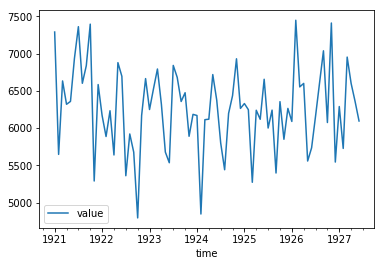

In [204]:
pd.DataFrame(obs - decomp.seasonal).plot()
plt.show()

In [25]:
def seasonality(data,n_period,n_seq):
    seasonal=data
    seasonality_forecast=[]
   
    if n_period==4:
        seasonality_forecast = [None] * 8
        for i in range (0,n_seq):
            seasonality_forecast[i]= seasonal[i]
            
    if n_period==12:
        seasonality_forecast = [None] * 18
        for i in range (0,n_seq):
            seasonality_forecast[i]= seasonal[i]
            
    return seasonality_forecast 

In [195]:
fcast_seasonal = seasonality(seasonal, 12, 18)

In [196]:
fcast = np.add(forecast, fcast_seasonal)

In [197]:
fcast

array([3832.45729149, 4005.54010012, 4680.85265192, 5871.79246264,
       7575.46933748, 8325.47023147, 9496.48875908, 8931.03785515,
       7861.34643676, 6394.81638862, 4000.42096515, 3465.73378965,
       3836.90651024, 3994.61724856, 4650.55821833, 5805.2284978 ,
       7592.03086092, 8356.4199385 ])

In [21]:
def evaluate_forecasts(actual, forecast):

   # rmse = np.sqrt(mean_squared_error(actual, forecast))
    #print('RMSE: ',rmse)
    mape = np.mean(np.abs((np.array(actual) - np.array(forecast)) / np.array(actual) )) * 100
    print ('MAPE: ', mape)
    return mape
#evaluate_forecasts(test, fcast, n_lag, n_seq)

In [336]:
example=pd.DataFrame(LstmDict(lstm_data)['N1412'])
example['Forecast'] = example['value']
for i in range(n_seq):
    example['Forecast'][-(n_seq-i)]=fcast[i]

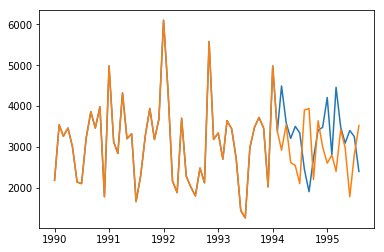

In [337]:
plt.plot(example[['Forecast', 'value']])
plt.show()

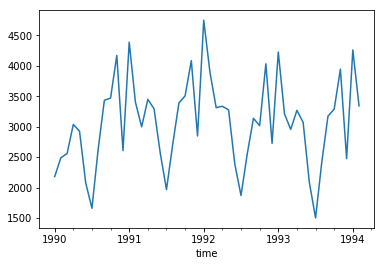

In [338]:
np.add(obs, seasonal).plot()
plt.show()

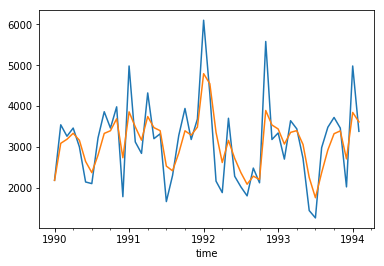

In [344]:
train1.plot()
(train1.ewm(alpha = 0.5).mean()).plot()
plt.show()

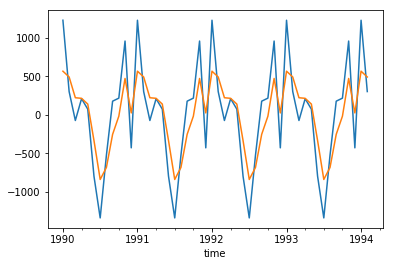

In [346]:
seasonal.plot()
seas.plot()
plt.show()

In [345]:
train12 = train1.ewm(alpha = 0.5).mean()
stl = decompose(train12, period=12)
seas = stl.seasonal #stl.seasonal #
